In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import os


import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from tensorflow.keras.callbacks import TensorBoard

## https://github.com/tuvovan/Vision_Transformer_Keras/blob/master/vit.py

In [2]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        #attention takes three inputs: queries, keys, and values,
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        #use the product between the queries and the keys 
        #to know "how much" each element is the sequence is important with the rest
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        #resulting vector, score is divided by a scaling factor based on the size of the embedding
        #scaling fcator is square root of the embeding dimension
        scaled_score = score / tf.math.sqrt(dim_key)
        #the attention scaled_score is then softmaxed
        weights = tf.nn.softmax(scaled_score, axis=-1)
        #Attention(Q, K, V ) = softmax[(QK)/√dim_key]V
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
         
        batch_size = tf.shape(inputs)[0]
        #MSA takes the queries, keys, and values  as input from the previous layer 
        #and projects them using the three linear layers.
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        #self attention of different heads are concatenated  
        output = self.combine_heads(concat_attention)
        return output


In [3]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        # Transfromer block multi-head Self Attention
        self.multiheadselfattention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training):
        out1 = self.layernorm1(inputs)       
        attention_output = self.multiheadselfattention(out1)
        attention_output = self.dropout1(attention_output, training=training)       
        out2 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [4]:
class VisionTransformer(tf.keras.Model):
    def __init__(
        self,
        image_size,
        patch_size,
        num_layers,
        num_classes,
        d_model,
        num_heads,
        mlp_dim,
        channels=3,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        # create patches based on patch_size
        # image_size/patch_size==0
        num_patches=self.create_patch(image_size,patch_size, channels)
        self.d_model = d_model
        self.rescale = Rescaling(1./255)
        self.patch_proj= self.create_postional_embedding(num_patches, d_model)
        self.enc_layers = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]
        self.mlp_head = tf.keras.Sequential(
            [
                Dense(mlp_dim, activation=tfa.activations.gelu),
                Dropout(dropout),
                Dense(num_classes),
            ]
        )

    def create_patch(self, image_size, patch_size, channels):
        num_patches = (image_size // patch_size) ** 2
        self.patch_dim = channels * patch_size ** 2
        self.patch_size = patch_size
        return num_patches
    def create_postional_embedding(self,num_patches, d_model):
        self.pos_emb = self.add_weight("pos_emb", shape=(1, num_patches + 1, d_model))
        self.class_emb = self.add_weight("class_emb", shape=(1, 1, d_model))
        print(self.class_emb.shape)
        return Dense(d_model)
   
        
    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        #rescale 
        x = self.rescale(x)
        # extract the patches from the image
        patches = self.extract_patches(x)
        # Apply the postio embedding
        x = self.patch_proj(patches)        
        class_emb = tf.broadcast_to(
            self.class_emb, [batch_size, 1, self.d_model]
        )              
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb        
        for layer in self.enc_layers:
            x = layer(x, training)
        x = self.mlp_head(x[:, 0])
        return x

In [57]:



AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE=32
PATCH_SIZE=4 
NUM_LAYERS=8
NUM_HEADS=16
MLP_DIM=128
lr=0.001
WEIGHT_DECAY=1e-4
BATCH_SIZE=64
epochs=30

ds, info = tfds.load("cifar10", as_supervised=True, with_info=True)
ds_train = (
    ds["train"]
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
ds_test, info = (
    ds["test"]
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


model = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=10,
    d_model=64,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    channels=3,
    dropout=0.1,
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=WEIGHT_DECAY),
    metrics=["accuracy"],
)

early_stop = tf.keras.callbacks.EarlyStopping(patience=10),
mcp = tf.keras.callbacks.ModelCheckpoint(filepath='weights/best.h5', 
                                         save_best_only=True, 
                                         monitor='val_loss', 
                                         mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.1, 
                                                 patience=3, 
                                                 verbose=0, 
                                                 mode='auto',
min_delta=0.0001, cooldown=0, min_lr=0)    

model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=epochs,
    callbacks=[early_stop, mcp, reduce_lr],
)
model.save_weights(os.path.join('.', "vit"))

(1, 1, 64)
Epoch 1/30


185/782 [======>.......................] - ETA: 0s - loss: 2.5178 - accuracy: 0.09 - ETA: 37s - loss: 2.4911 - accuracy: 0.117 - ETA: 47s - loss: 2.4594 - accuracy: 0.104 - ETA: 53s - loss: 2.4385 - accuracy: 0.121 - ETA: 54s - loss: 2.4322 - accuracy: 0.109 - ETA: 53s - loss: 2.4137 - accuracy: 0.106 - ETA: 54s - loss: 2.4149 - accuracy: 0.104 - ETA: 54s - loss: 2.3930 - accuracy: 0.119 - ETA: 54s - loss: 2.3907 - accuracy: 0.111 - ETA: 53s - loss: 2.3817 - accuracy: 0.107 - ETA: 53s - loss: 2.3821 - accuracy: 0.108 - ETA: 53s - loss: 2.3840 - accuracy: 0.104 - ETA: 53s - loss: 2.3811 - accuracy: 0.101 - ETA: 53s - loss: 2.3797 - accuracy: 0.100 - ETA: 53s - loss: 2.3758 - accuracy: 0.102 - ETA: 53s - loss: 2.3718 - accuracy: 0.103 - ETA: 53s - loss: 2.3711 - accuracy: 0.105 - ETA: 52s - loss: 2.3744 - accuracy: 0.105 - ETA: 52s - loss: 2.3721 - accuracy: 0.107 - ETA: 52s - loss: 2.3660 - accuracy: 0.110 - ETA: 52s - loss: 2.3640 - accuracy: 0.112 - ETA: 52s - loss: 2.3625 - accuracy:

371/782 [=============>................] - ETA: 41s - loss: 2.1794 - accuracy: 0.165 - ETA: 41s - loss: 2.1783 - accuracy: 0.165 - ETA: 41s - loss: 2.1781 - accuracy: 0.165 - ETA: 41s - loss: 2.1774 - accuracy: 0.165 - ETA: 41s - loss: 2.1763 - accuracy: 0.165 - ETA: 41s - loss: 2.1761 - accuracy: 0.165 - ETA: 41s - loss: 2.1755 - accuracy: 0.165 - ETA: 40s - loss: 2.1749 - accuracy: 0.165 - ETA: 40s - loss: 2.1740 - accuracy: 0.166 - ETA: 40s - loss: 2.1732 - accuracy: 0.166 - ETA: 40s - loss: 2.1724 - accuracy: 0.166 - ETA: 40s - loss: 2.1714 - accuracy: 0.166 - ETA: 40s - loss: 2.1703 - accuracy: 0.167 - ETA: 40s - loss: 2.1694 - accuracy: 0.167 - ETA: 40s - loss: 2.1682 - accuracy: 0.167 - ETA: 40s - loss: 2.1666 - accuracy: 0.167 - ETA: 40s - loss: 2.1648 - accuracy: 0.167 - ETA: 40s - loss: 2.1632 - accuracy: 0.168 - ETA: 40s - loss: 2.1632 - accuracy: 0.168 - ETA: 40s - loss: 2.1619 - accuracy: 0.168 - ETA: 40s - loss: 2.1607 - accuracy: 0.168 - ETA: 40s - loss: 2.1608 - accurac

557/782 [====================>.........] - ETA: 28s - loss: 2.0701 - accuracy: 0.191 - ETA: 28s - loss: 2.0695 - accuracy: 0.191 - ETA: 28s - loss: 2.0691 - accuracy: 0.191 - ETA: 28s - loss: 2.0682 - accuracy: 0.191 - ETA: 28s - loss: 2.0679 - accuracy: 0.191 - ETA: 28s - loss: 2.0675 - accuracy: 0.192 - ETA: 28s - loss: 2.0671 - accuracy: 0.192 - ETA: 28s - loss: 2.0667 - accuracy: 0.192 - ETA: 28s - loss: 2.0662 - accuracy: 0.192 - ETA: 28s - loss: 2.0658 - accuracy: 0.192 - ETA: 28s - loss: 2.0654 - accuracy: 0.192 - ETA: 28s - loss: 2.0651 - accuracy: 0.192 - ETA: 28s - loss: 2.0646 - accuracy: 0.192 - ETA: 28s - loss: 2.0642 - accuracy: 0.192 - ETA: 27s - loss: 2.0637 - accuracy: 0.192 - ETA: 27s - loss: 2.0633 - accuracy: 0.192 - ETA: 27s - loss: 2.0631 - accuracy: 0.192 - ETA: 27s - loss: 2.0630 - accuracy: 0.192 - ETA: 27s - loss: 2.0625 - accuracy: 0.193 - ETA: 27s - loss: 2.0620 - accuracy: 0.193 - ETA: 27s - loss: 2.0613 - accuracy: 0.193 - ETA: 27s - loss: 2.0615 - accurac

748/782 [===========================>..] - ETA: 15s - loss: 2.0249 - accuracy: 0.207 - ETA: 15s - loss: 2.0247 - accuracy: 0.207 - ETA: 15s - loss: 2.0246 - accuracy: 0.207 - ETA: 15s - loss: 2.0245 - accuracy: 0.207 - ETA: 15s - loss: 2.0241 - accuracy: 0.207 - ETA: 15s - loss: 2.0237 - accuracy: 0.207 - ETA: 15s - loss: 2.0233 - accuracy: 0.207 - ETA: 15s - loss: 2.0229 - accuracy: 0.207 - ETA: 15s - loss: 2.0226 - accuracy: 0.208 - ETA: 15s - loss: 2.0225 - accuracy: 0.208 - ETA: 15s - loss: 2.0221 - accuracy: 0.208 - ETA: 15s - loss: 2.0218 - accuracy: 0.208 - ETA: 15s - loss: 2.0214 - accuracy: 0.208 - ETA: 14s - loss: 2.0215 - accuracy: 0.208 - ETA: 14s - loss: 2.0212 - accuracy: 0.208 - ETA: 14s - loss: 2.0210 - accuracy: 0.208 - ETA: 14s - loss: 2.0207 - accuracy: 0.208 - ETA: 14s - loss: 2.0204 - accuracy: 0.208 - ETA: 14s - loss: 2.0204 - accuracy: 0.208 - ETA: 14s - loss: 2.0203 - accuracy: 0.208 - ETA: 14s - loss: 2.0202 - accuracy: 0.209 - ETA: 14s - loss: 2.0201 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.9907 - accuracy: 0.21 - ETA: 2s - loss: 1.9905 - accuracy: 0.21 - ETA: 2s - loss: 1.9905 - accuracy: 0.21 - ETA: 2s - loss: 1.9903 - accuracy: 0.21 - ETA: 2s - loss: 1.9901 - accuracy: 0.21 - ETA: 1s - loss: 1.9898 - accuracy: 0.21 - ETA: 1s - loss: 1.9896 - accuracy: 0.21 - ETA: 1s - loss: 1.9894 - accuracy: 0.21 - ETA: 1s - loss: 1.9892 - accuracy: 0.21 - ETA: 1s - loss: 1.9889 - accuracy: 0.21 - ETA: 1s - loss: 1.9887 - accuracy: 0.21 - ETA: 1s - loss: 1.9886 - accuracy: 0.21 - ETA: 1s - loss: 1.9885 - accuracy: 0.21 - ETA: 1s - loss: 1.9882 - accuracy: 0.21 - ETA: 1s - loss: 1.9881 - accuracy: 0.21 - ETA: 1s - loss: 1.9879 - accuracy: 0.21 - ETA: 1s - loss: 1.9877 - accuracy: 0.21 - ETA: 1s - loss: 1.9874 - accuracy: 0.22 - ETA: 1s - loss: 1.9871 - accuracy: 0.22 - ETA: 0s - loss: 1.9870 - accuracy: 0.22 - ETA: 0s - loss: 1.9868 - accuracy: 0.22 - ETA: 0s - loss: 1.9864 - accuracy: 0.22 - ETA: 0s - loss: 1.9861 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.8872 - accuracy: 0.29 - ETA: 31s - loss: 1.9122 - accuracy: 0.257 - ETA: 39s - loss: 1.9068 - accuracy: 0.276 - ETA: 43s - loss: 1.8765 - accuracy: 0.257 - ETA: 47s - loss: 1.8504 - accuracy: 0.268 - ETA: 48s - loss: 1.8600 - accuracy: 0.270 - ETA: 50s - loss: 1.8459 - accuracy: 0.281 - ETA: 50s - loss: 1.8422 - accuracy: 0.287 - ETA: 50s - loss: 1.8345 - accuracy: 0.286 - ETA: 51s - loss: 1.8435 - accuracy: 0.281 - ETA: 51s - loss: 1.8397 - accuracy: 0.284 - ETA: 51s - loss: 1.8489 - accuracy: 0.278 - ETA: 52s - loss: 1.8500 - accuracy: 0.274 - ETA: 51s - loss: 1.8511 - accuracy: 0.276 - ETA: 52s - loss: 1.8625 - accuracy: 0.275 - ETA: 52s - loss: 1.8646 - accuracy: 0.275 - ETA: 52s - loss: 1.8699 - accuracy: 0.273 - ETA: 52s - loss: 1.8713 - accuracy: 0.275 - ETA: 52s - loss: 1.8643 - accuracy: 0.276 - ETA: 52s - loss: 1.8642 - accuracy: 0.275 - ETA: 53s - loss: 1.8618 - accuracy: 0.278 - ETA: 52s - loss: 1.8580 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 2.0317 - accuracy: 0.227 - ETA: 42s - loss: 2.0317 - accuracy: 0.227 - ETA: 42s - loss: 2.0317 - accuracy: 0.227 - ETA: 42s - loss: 2.0318 - accuracy: 0.227 - ETA: 42s - loss: 2.0319 - accuracy: 0.227 - ETA: 42s - loss: 2.0318 - accuracy: 0.227 - ETA: 42s - loss: 2.0316 - accuracy: 0.226 - ETA: 42s - loss: 2.0309 - accuracy: 0.227 - ETA: 42s - loss: 2.0307 - accuracy: 0.226 - ETA: 42s - loss: 2.0308 - accuracy: 0.226 - ETA: 42s - loss: 2.0305 - accuracy: 0.225 - ETA: 42s - loss: 2.0306 - accuracy: 0.225 - ETA: 41s - loss: 2.0304 - accuracy: 0.225 - ETA: 41s - loss: 2.0303 - accuracy: 0.224 - ETA: 41s - loss: 2.0297 - accuracy: 0.224 - ETA: 41s - loss: 2.0290 - accuracy: 0.224 - ETA: 41s - loss: 2.0290 - accuracy: 0.223 - ETA: 41s - loss: 2.0287 - accuracy: 0.223 - ETA: 41s - loss: 2.0290 - accuracy: 0.223 - ETA: 41s - loss: 2.0288 - accuracy: 0.223 - ETA: 41s - loss: 2.0286 - accuracy: 0.223 - ETA: 41s - loss: 2.0281 - accurac

558/782 [====================>.........] - ETA: 29s - loss: 1.9703 - accuracy: 0.227 - ETA: 29s - loss: 1.9693 - accuracy: 0.228 - ETA: 29s - loss: 1.9688 - accuracy: 0.228 - ETA: 29s - loss: 1.9686 - accuracy: 0.228 - ETA: 29s - loss: 1.9683 - accuracy: 0.228 - ETA: 29s - loss: 1.9681 - accuracy: 0.228 - ETA: 29s - loss: 1.9676 - accuracy: 0.228 - ETA: 28s - loss: 1.9673 - accuracy: 0.228 - ETA: 28s - loss: 1.9668 - accuracy: 0.228 - ETA: 28s - loss: 1.9672 - accuracy: 0.228 - ETA: 28s - loss: 1.9665 - accuracy: 0.228 - ETA: 28s - loss: 1.9662 - accuracy: 0.228 - ETA: 28s - loss: 1.9662 - accuracy: 0.228 - ETA: 28s - loss: 1.9662 - accuracy: 0.229 - ETA: 28s - loss: 1.9664 - accuracy: 0.229 - ETA: 28s - loss: 1.9658 - accuracy: 0.229 - ETA: 28s - loss: 1.9655 - accuracy: 0.229 - ETA: 28s - loss: 1.9653 - accuracy: 0.229 - ETA: 28s - loss: 1.9647 - accuracy: 0.229 - ETA: 28s - loss: 1.9647 - accuracy: 0.229 - ETA: 27s - loss: 1.9646 - accuracy: 0.229 - ETA: 27s - loss: 1.9645 - accurac

749/782 [===========================>..] - ETA: 16s - loss: 1.9283 - accuracy: 0.241 - ETA: 15s - loss: 1.9281 - accuracy: 0.241 - ETA: 15s - loss: 1.9282 - accuracy: 0.241 - ETA: 15s - loss: 1.9278 - accuracy: 0.241 - ETA: 15s - loss: 1.9278 - accuracy: 0.241 - ETA: 15s - loss: 1.9275 - accuracy: 0.241 - ETA: 15s - loss: 1.9276 - accuracy: 0.241 - ETA: 15s - loss: 1.9275 - accuracy: 0.241 - ETA: 15s - loss: 1.9272 - accuracy: 0.241 - ETA: 15s - loss: 1.9275 - accuracy: 0.241 - ETA: 15s - loss: 1.9275 - accuracy: 0.241 - ETA: 15s - loss: 1.9272 - accuracy: 0.241 - ETA: 15s - loss: 1.9269 - accuracy: 0.241 - ETA: 15s - loss: 1.9267 - accuracy: 0.241 - ETA: 14s - loss: 1.9267 - accuracy: 0.241 - ETA: 14s - loss: 1.9267 - accuracy: 0.241 - ETA: 14s - loss: 1.9266 - accuracy: 0.241 - ETA: 14s - loss: 1.9264 - accuracy: 0.241 - ETA: 14s - loss: 1.9267 - accuracy: 0.241 - ETA: 14s - loss: 1.9266 - accuracy: 0.241 - ETA: 14s - loss: 1.9263 - accuracy: 0.241 - ETA: 14s - loss: 1.9259 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.9097 - accuracy: 0.24 - ETA: 2s - loss: 1.9097 - accuracy: 0.24 - ETA: 2s - loss: 1.9097 - accuracy: 0.24 - ETA: 2s - loss: 1.9094 - accuracy: 0.24 - ETA: 2s - loss: 1.9096 - accuracy: 0.24 - ETA: 1s - loss: 1.9095 - accuracy: 0.24 - ETA: 1s - loss: 1.9094 - accuracy: 0.24 - ETA: 1s - loss: 1.9092 - accuracy: 0.24 - ETA: 1s - loss: 1.9090 - accuracy: 0.24 - ETA: 1s - loss: 1.9086 - accuracy: 0.24 - ETA: 1s - loss: 1.9086 - accuracy: 0.24 - ETA: 1s - loss: 1.9085 - accuracy: 0.24 - ETA: 1s - loss: 1.9085 - accuracy: 0.24 - ETA: 1s - loss: 1.9081 - accuracy: 0.24 - ETA: 1s - loss: 1.9079 - accuracy: 0.24 - ETA: 1s - loss: 1.9079 - accuracy: 0.24 - ETA: 1s - loss: 1.9077 - accuracy: 0.24 - ETA: 1s - loss: 1.9076 - accuracy: 0.24 - ETA: 1s - loss: 1.9075 - accuracy: 0.24 - ETA: 0s - loss: 1.9072 - accuracy: 0.24 - ETA: 0s - loss: 1.9074 - accuracy: 0.24 - ETA: 0s - loss: 1.9074 - accuracy: 0.24 - ETA: 0s - loss: 1.9074 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.8291 - accuracy: 0.25 - ETA: 28s - loss: 1.8260 - accuracy: 0.265 - ETA: 37s - loss: 1.8601 - accuracy: 0.307 - ETA: 42s - loss: 1.9247 - accuracy: 0.257 - ETA: 46s - loss: 1.9274 - accuracy: 0.259 - ETA: 47s - loss: 1.9523 - accuracy: 0.257 - ETA: 48s - loss: 1.9181 - accuracy: 0.256 - ETA: 49s - loss: 1.9006 - accuracy: 0.265 - ETA: 50s - loss: 1.8914 - accuracy: 0.267 - ETA: 50s - loss: 1.8898 - accuracy: 0.268 - ETA: 51s - loss: 1.8698 - accuracy: 0.268 - ETA: 51s - loss: 1.8683 - accuracy: 0.261 - ETA: 51s - loss: 1.8647 - accuracy: 0.266 - ETA: 51s - loss: 1.8630 - accuracy: 0.273 - ETA: 51s - loss: 1.8560 - accuracy: 0.275 - ETA: 51s - loss: 1.8550 - accuracy: 0.277 - ETA: 51s - loss: 1.8493 - accuracy: 0.280 - ETA: 51s - loss: 1.8459 - accuracy: 0.277 - ETA: 51s - loss: 1.8529 - accuracy: 0.277 - ETA: 51s - loss: 1.8553 - accuracy: 0.277 - ETA: 51s - loss: 1.8560 - accuracy: 0.275 - ETA: 51s - loss: 1.8521 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 1.8168 - accuracy: 0.286 - ETA: 42s - loss: 1.8164 - accuracy: 0.286 - ETA: 42s - loss: 1.8173 - accuracy: 0.286 - ETA: 42s - loss: 1.8165 - accuracy: 0.286 - ETA: 42s - loss: 1.8164 - accuracy: 0.286 - ETA: 42s - loss: 1.8161 - accuracy: 0.286 - ETA: 42s - loss: 1.8155 - accuracy: 0.286 - ETA: 42s - loss: 1.8152 - accuracy: 0.286 - ETA: 42s - loss: 1.8149 - accuracy: 0.286 - ETA: 42s - loss: 1.8148 - accuracy: 0.286 - ETA: 42s - loss: 1.8146 - accuracy: 0.287 - ETA: 42s - loss: 1.8143 - accuracy: 0.287 - ETA: 41s - loss: 1.8138 - accuracy: 0.287 - ETA: 41s - loss: 1.8126 - accuracy: 0.287 - ETA: 41s - loss: 1.8115 - accuracy: 0.288 - ETA: 41s - loss: 1.8118 - accuracy: 0.288 - ETA: 41s - loss: 1.8113 - accuracy: 0.288 - ETA: 41s - loss: 1.8117 - accuracy: 0.287 - ETA: 41s - loss: 1.8116 - accuracy: 0.287 - ETA: 41s - loss: 1.8118 - accuracy: 0.287 - ETA: 41s - loss: 1.8120 - accuracy: 0.287 - ETA: 41s - loss: 1.8122 - accurac

558/782 [====================>.........] - ETA: 29s - loss: 1.8029 - accuracy: 0.284 - ETA: 29s - loss: 1.8030 - accuracy: 0.284 - ETA: 29s - loss: 1.8032 - accuracy: 0.284 - ETA: 29s - loss: 1.8031 - accuracy: 0.284 - ETA: 29s - loss: 1.8032 - accuracy: 0.284 - ETA: 29s - loss: 1.8027 - accuracy: 0.285 - ETA: 28s - loss: 1.8026 - accuracy: 0.285 - ETA: 28s - loss: 1.8025 - accuracy: 0.285 - ETA: 28s - loss: 1.8025 - accuracy: 0.285 - ETA: 28s - loss: 1.8024 - accuracy: 0.285 - ETA: 28s - loss: 1.8023 - accuracy: 0.285 - ETA: 28s - loss: 1.8023 - accuracy: 0.285 - ETA: 28s - loss: 1.8025 - accuracy: 0.285 - ETA: 28s - loss: 1.8024 - accuracy: 0.284 - ETA: 28s - loss: 1.8026 - accuracy: 0.285 - ETA: 28s - loss: 1.8025 - accuracy: 0.285 - ETA: 28s - loss: 1.8022 - accuracy: 0.285 - ETA: 28s - loss: 1.8020 - accuracy: 0.285 - ETA: 28s - loss: 1.8016 - accuracy: 0.285 - ETA: 28s - loss: 1.8010 - accuracy: 0.286 - ETA: 27s - loss: 1.8009 - accuracy: 0.286 - ETA: 27s - loss: 1.8013 - accurac

748/782 [===========================>..] - ETA: 16s - loss: 1.7782 - accuracy: 0.293 - ETA: 16s - loss: 1.7781 - accuracy: 0.293 - ETA: 15s - loss: 1.7780 - accuracy: 0.293 - ETA: 15s - loss: 1.7777 - accuracy: 0.293 - ETA: 15s - loss: 1.7779 - accuracy: 0.293 - ETA: 15s - loss: 1.7779 - accuracy: 0.293 - ETA: 15s - loss: 1.7777 - accuracy: 0.293 - ETA: 15s - loss: 1.7774 - accuracy: 0.293 - ETA: 15s - loss: 1.7770 - accuracy: 0.293 - ETA: 15s - loss: 1.7772 - accuracy: 0.293 - ETA: 15s - loss: 1.7775 - accuracy: 0.293 - ETA: 15s - loss: 1.7771 - accuracy: 0.293 - ETA: 15s - loss: 1.7768 - accuracy: 0.293 - ETA: 15s - loss: 1.7768 - accuracy: 0.293 - ETA: 15s - loss: 1.7767 - accuracy: 0.293 - ETA: 15s - loss: 1.7767 - accuracy: 0.293 - ETA: 14s - loss: 1.7767 - accuracy: 0.293 - ETA: 14s - loss: 1.7764 - accuracy: 0.293 - ETA: 14s - loss: 1.7762 - accuracy: 0.293 - ETA: 14s - loss: 1.7762 - accuracy: 0.293 - ETA: 14s - loss: 1.7760 - accuracy: 0.293 - ETA: 14s - loss: 1.7761 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.7580 - accuracy: 0.29 - ETA: 2s - loss: 1.7582 - accuracy: 0.29 - ETA: 2s - loss: 1.7582 - accuracy: 0.29 - ETA: 2s - loss: 1.7581 - accuracy: 0.29 - ETA: 2s - loss: 1.7581 - accuracy: 0.29 - ETA: 2s - loss: 1.7579 - accuracy: 0.29 - ETA: 1s - loss: 1.7579 - accuracy: 0.29 - ETA: 1s - loss: 1.7577 - accuracy: 0.29 - ETA: 1s - loss: 1.7578 - accuracy: 0.29 - ETA: 1s - loss: 1.7576 - accuracy: 0.29 - ETA: 1s - loss: 1.7573 - accuracy: 0.29 - ETA: 1s - loss: 1.7573 - accuracy: 0.29 - ETA: 1s - loss: 1.7572 - accuracy: 0.29 - ETA: 1s - loss: 1.7569 - accuracy: 0.30 - ETA: 1s - loss: 1.7568 - accuracy: 0.30 - ETA: 1s - loss: 1.7569 - accuracy: 0.30 - ETA: 1s - loss: 1.7567 - accuracy: 0.30 - ETA: 1s - loss: 1.7565 - accuracy: 0.30 - ETA: 1s - loss: 1.7564 - accuracy: 0.30 - ETA: 1s - loss: 1.7562 - accuracy: 0.30 - ETA: 0s - loss: 1.7561 - accuracy: 0.30 - ETA: 0s - loss: 1.7559 - accuracy: 0.30 - ETA: 0s - loss: 1.7555 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.8651 - accuracy: 0.23 - ETA: 31s - loss: 1.7177 - accuracy: 0.312 - ETA: 40s - loss: 1.6979 - accuracy: 0.328 - ETA: 44s - loss: 1.6852 - accuracy: 0.308 - ETA: 47s - loss: 1.6813 - accuracy: 0.312 - ETA: 48s - loss: 1.7102 - accuracy: 0.309 - ETA: 49s - loss: 1.6974 - accuracy: 0.323 - ETA: 50s - loss: 1.6843 - accuracy: 0.332 - ETA: 51s - loss: 1.6758 - accuracy: 0.326 - ETA: 51s - loss: 1.6748 - accuracy: 0.323 - ETA: 52s - loss: 1.6781 - accuracy: 0.319 - ETA: 52s - loss: 1.6847 - accuracy: 0.320 - ETA: 52s - loss: 1.6827 - accuracy: 0.320 - ETA: 53s - loss: 1.6982 - accuracy: 0.322 - ETA: 53s - loss: 1.6928 - accuracy: 0.317 - ETA: 53s - loss: 1.7115 - accuracy: 0.311 - ETA: 53s - loss: 1.7216 - accuracy: 0.307 - ETA: 53s - loss: 1.7130 - accuracy: 0.311 - ETA: 53s - loss: 1.7075 - accuracy: 0.310 - ETA: 53s - loss: 1.7043 - accuracy: 0.312 - ETA: 53s - loss: 1.7112 - accuracy: 0.313 - ETA: 53s - loss: 1.7205 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 1.7067 - accuracy: 0.317 - ETA: 42s - loss: 1.7062 - accuracy: 0.316 - ETA: 42s - loss: 1.7060 - accuracy: 0.317 - ETA: 42s - loss: 1.7055 - accuracy: 0.317 - ETA: 42s - loss: 1.7053 - accuracy: 0.317 - ETA: 42s - loss: 1.7055 - accuracy: 0.318 - ETA: 42s - loss: 1.7064 - accuracy: 0.317 - ETA: 42s - loss: 1.7053 - accuracy: 0.318 - ETA: 42s - loss: 1.7052 - accuracy: 0.318 - ETA: 42s - loss: 1.7044 - accuracy: 0.318 - ETA: 42s - loss: 1.7047 - accuracy: 0.318 - ETA: 42s - loss: 1.7031 - accuracy: 0.319 - ETA: 42s - loss: 1.7030 - accuracy: 0.318 - ETA: 41s - loss: 1.7038 - accuracy: 0.318 - ETA: 41s - loss: 1.7050 - accuracy: 0.318 - ETA: 41s - loss: 1.7049 - accuracy: 0.318 - ETA: 41s - loss: 1.7053 - accuracy: 0.318 - ETA: 41s - loss: 1.7058 - accuracy: 0.318 - ETA: 41s - loss: 1.7059 - accuracy: 0.318 - ETA: 41s - loss: 1.7066 - accuracy: 0.317 - ETA: 41s - loss: 1.7067 - accuracy: 0.317 - ETA: 41s - loss: 1.7067 - accurac

558/782 [====================>.........] - ETA: 29s - loss: 1.6916 - accuracy: 0.322 - ETA: 29s - loss: 1.6912 - accuracy: 0.322 - ETA: 29s - loss: 1.6909 - accuracy: 0.322 - ETA: 29s - loss: 1.6907 - accuracy: 0.323 - ETA: 29s - loss: 1.6900 - accuracy: 0.323 - ETA: 29s - loss: 1.6903 - accuracy: 0.323 - ETA: 28s - loss: 1.6908 - accuracy: 0.323 - ETA: 28s - loss: 1.6906 - accuracy: 0.323 - ETA: 28s - loss: 1.6907 - accuracy: 0.323 - ETA: 28s - loss: 1.6908 - accuracy: 0.323 - ETA: 28s - loss: 1.6903 - accuracy: 0.323 - ETA: 28s - loss: 1.6899 - accuracy: 0.323 - ETA: 28s - loss: 1.6897 - accuracy: 0.323 - ETA: 28s - loss: 1.6894 - accuracy: 0.324 - ETA: 28s - loss: 1.6895 - accuracy: 0.324 - ETA: 28s - loss: 1.6893 - accuracy: 0.324 - ETA: 28s - loss: 1.6895 - accuracy: 0.324 - ETA: 28s - loss: 1.6894 - accuracy: 0.324 - ETA: 28s - loss: 1.6896 - accuracy: 0.324 - ETA: 28s - loss: 1.6893 - accuracy: 0.324 - ETA: 27s - loss: 1.6888 - accuracy: 0.324 - ETA: 27s - loss: 1.6888 - accurac

749/782 [===========================>..] - ETA: 16s - loss: 1.6805 - accuracy: 0.329 - ETA: 15s - loss: 1.6801 - accuracy: 0.329 - ETA: 15s - loss: 1.6798 - accuracy: 0.329 - ETA: 15s - loss: 1.6798 - accuracy: 0.329 - ETA: 15s - loss: 1.6799 - accuracy: 0.329 - ETA: 15s - loss: 1.6801 - accuracy: 0.329 - ETA: 15s - loss: 1.6800 - accuracy: 0.329 - ETA: 15s - loss: 1.6801 - accuracy: 0.330 - ETA: 15s - loss: 1.6801 - accuracy: 0.330 - ETA: 15s - loss: 1.6801 - accuracy: 0.330 - ETA: 15s - loss: 1.6800 - accuracy: 0.330 - ETA: 15s - loss: 1.6800 - accuracy: 0.330 - ETA: 15s - loss: 1.6799 - accuracy: 0.330 - ETA: 15s - loss: 1.6798 - accuracy: 0.330 - ETA: 15s - loss: 1.6797 - accuracy: 0.330 - ETA: 14s - loss: 1.6795 - accuracy: 0.329 - ETA: 14s - loss: 1.6793 - accuracy: 0.330 - ETA: 14s - loss: 1.6792 - accuracy: 0.330 - ETA: 14s - loss: 1.6793 - accuracy: 0.330 - ETA: 14s - loss: 1.6794 - accuracy: 0.330 - ETA: 14s - loss: 1.6791 - accuracy: 0.330 - ETA: 14s - loss: 1.6793 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.6658 - accuracy: 0.33 - ETA: 2s - loss: 1.6658 - accuracy: 0.33 - ETA: 2s - loss: 1.6659 - accuracy: 0.33 - ETA: 2s - loss: 1.6658 - accuracy: 0.33 - ETA: 2s - loss: 1.6659 - accuracy: 0.33 - ETA: 1s - loss: 1.6659 - accuracy: 0.33 - ETA: 1s - loss: 1.6655 - accuracy: 0.33 - ETA: 1s - loss: 1.6654 - accuracy: 0.33 - ETA: 1s - loss: 1.6655 - accuracy: 0.33 - ETA: 1s - loss: 1.6653 - accuracy: 0.33 - ETA: 1s - loss: 1.6651 - accuracy: 0.33 - ETA: 1s - loss: 1.6651 - accuracy: 0.33 - ETA: 1s - loss: 1.6650 - accuracy: 0.33 - ETA: 1s - loss: 1.6647 - accuracy: 0.33 - ETA: 1s - loss: 1.6645 - accuracy: 0.33 - ETA: 1s - loss: 1.6640 - accuracy: 0.33 - ETA: 1s - loss: 1.6640 - accuracy: 0.33 - ETA: 1s - loss: 1.6639 - accuracy: 0.33 - ETA: 1s - loss: 1.6638 - accuracy: 0.33 - ETA: 0s - loss: 1.6636 - accuracy: 0.33 - ETA: 0s - loss: 1.6635 - accuracy: 0.33 - ETA: 0s - loss: 1.6635 - accuracy: 0.33 - ETA: 0s - loss: 1.6635 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.5244 - accuracy: 0.29 - ETA: 30s - loss: 1.5478 - accuracy: 0.320 - ETA: 38s - loss: 1.5147 - accuracy: 0.349 - ETA: 43s - loss: 1.5433 - accuracy: 0.339 - ETA: 45s - loss: 1.5642 - accuracy: 0.337 - ETA: 48s - loss: 1.5959 - accuracy: 0.312 - ETA: 49s - loss: 1.5965 - accuracy: 0.321 - ETA: 50s - loss: 1.5883 - accuracy: 0.328 - ETA: 50s - loss: 1.5997 - accuracy: 0.335 - ETA: 50s - loss: 1.5841 - accuracy: 0.345 - ETA: 51s - loss: 1.5848 - accuracy: 0.350 - ETA: 51s - loss: 1.6060 - accuracy: 0.351 - ETA: 51s - loss: 1.6183 - accuracy: 0.345 - ETA: 51s - loss: 1.6349 - accuracy: 0.347 - ETA: 52s - loss: 1.6347 - accuracy: 0.343 - ETA: 52s - loss: 1.6388 - accuracy: 0.343 - ETA: 52s - loss: 1.6333 - accuracy: 0.345 - ETA: 52s - loss: 1.6369 - accuracy: 0.351 - ETA: 52s - loss: 1.6400 - accuracy: 0.355 - ETA: 52s - loss: 1.6358 - accuracy: 0.359 - ETA: 52s - loss: 1.6371 - accuracy: 0.360 - ETA: 52s - loss: 1.6361 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 1.5996 - accuracy: 0.384 - ETA: 42s - loss: 1.5993 - accuracy: 0.384 - ETA: 42s - loss: 1.5990 - accuracy: 0.384 - ETA: 42s - loss: 1.5994 - accuracy: 0.384 - ETA: 42s - loss: 1.5987 - accuracy: 0.384 - ETA: 42s - loss: 1.5987 - accuracy: 0.384 - ETA: 42s - loss: 1.5981 - accuracy: 0.384 - ETA: 42s - loss: 1.5977 - accuracy: 0.384 - ETA: 42s - loss: 1.5979 - accuracy: 0.384 - ETA: 42s - loss: 1.5969 - accuracy: 0.384 - ETA: 41s - loss: 1.5970 - accuracy: 0.385 - ETA: 41s - loss: 1.5961 - accuracy: 0.385 - ETA: 41s - loss: 1.5953 - accuracy: 0.385 - ETA: 41s - loss: 1.5958 - accuracy: 0.385 - ETA: 41s - loss: 1.5957 - accuracy: 0.385 - ETA: 41s - loss: 1.5958 - accuracy: 0.385 - ETA: 41s - loss: 1.5946 - accuracy: 0.385 - ETA: 41s - loss: 1.5944 - accuracy: 0.385 - ETA: 41s - loss: 1.5938 - accuracy: 0.385 - ETA: 41s - loss: 1.5940 - accuracy: 0.385 - ETA: 41s - loss: 1.5949 - accuracy: 0.385 - ETA: 41s - loss: 1.5942 - accurac

558/782 [====================>.........] - ETA: 29s - loss: 1.5894 - accuracy: 0.385 - ETA: 29s - loss: 1.5893 - accuracy: 0.385 - ETA: 29s - loss: 1.5891 - accuracy: 0.385 - ETA: 29s - loss: 1.5888 - accuracy: 0.385 - ETA: 29s - loss: 1.5890 - accuracy: 0.385 - ETA: 29s - loss: 1.5896 - accuracy: 0.385 - ETA: 29s - loss: 1.5899 - accuracy: 0.385 - ETA: 28s - loss: 1.5895 - accuracy: 0.385 - ETA: 28s - loss: 1.5895 - accuracy: 0.385 - ETA: 28s - loss: 1.5896 - accuracy: 0.385 - ETA: 28s - loss: 1.5887 - accuracy: 0.386 - ETA: 28s - loss: 1.5888 - accuracy: 0.386 - ETA: 28s - loss: 1.5892 - accuracy: 0.385 - ETA: 28s - loss: 1.5891 - accuracy: 0.386 - ETA: 28s - loss: 1.5889 - accuracy: 0.386 - ETA: 28s - loss: 1.5887 - accuracy: 0.386 - ETA: 28s - loss: 1.5886 - accuracy: 0.386 - ETA: 28s - loss: 1.5883 - accuracy: 0.386 - ETA: 28s - loss: 1.5883 - accuracy: 0.386 - ETA: 28s - loss: 1.5880 - accuracy: 0.386 - ETA: 28s - loss: 1.5880 - accuracy: 0.387 - ETA: 27s - loss: 1.5875 - accurac

748/782 [===========================>..] - ETA: 16s - loss: 1.5684 - accuracy: 0.394 - ETA: 16s - loss: 1.5684 - accuracy: 0.394 - ETA: 15s - loss: 1.5683 - accuracy: 0.394 - ETA: 15s - loss: 1.5686 - accuracy: 0.394 - ETA: 15s - loss: 1.5684 - accuracy: 0.394 - ETA: 15s - loss: 1.5688 - accuracy: 0.394 - ETA: 15s - loss: 1.5687 - accuracy: 0.394 - ETA: 15s - loss: 1.5685 - accuracy: 0.394 - ETA: 15s - loss: 1.5688 - accuracy: 0.394 - ETA: 15s - loss: 1.5685 - accuracy: 0.394 - ETA: 15s - loss: 1.5681 - accuracy: 0.394 - ETA: 15s - loss: 1.5681 - accuracy: 0.394 - ETA: 15s - loss: 1.5676 - accuracy: 0.395 - ETA: 15s - loss: 1.5671 - accuracy: 0.395 - ETA: 15s - loss: 1.5668 - accuracy: 0.395 - ETA: 15s - loss: 1.5671 - accuracy: 0.395 - ETA: 14s - loss: 1.5673 - accuracy: 0.395 - ETA: 14s - loss: 1.5675 - accuracy: 0.395 - ETA: 14s - loss: 1.5675 - accuracy: 0.395 - ETA: 14s - loss: 1.5676 - accuracy: 0.395 - ETA: 14s - loss: 1.5675 - accuracy: 0.395 - ETA: 14s - loss: 1.5677 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.5614 - accuracy: 0.39 - ETA: 2s - loss: 1.5614 - accuracy: 0.39 - ETA: 2s - loss: 1.5612 - accuracy: 0.39 - ETA: 2s - loss: 1.5613 - accuracy: 0.39 - ETA: 2s - loss: 1.5613 - accuracy: 0.39 - ETA: 2s - loss: 1.5615 - accuracy: 0.39 - ETA: 1s - loss: 1.5613 - accuracy: 0.39 - ETA: 1s - loss: 1.5614 - accuracy: 0.39 - ETA: 1s - loss: 1.5614 - accuracy: 0.39 - ETA: 1s - loss: 1.5614 - accuracy: 0.39 - ETA: 1s - loss: 1.5612 - accuracy: 0.39 - ETA: 1s - loss: 1.5614 - accuracy: 0.39 - ETA: 1s - loss: 1.5613 - accuracy: 0.39 - ETA: 1s - loss: 1.5613 - accuracy: 0.39 - ETA: 1s - loss: 1.5613 - accuracy: 0.39 - ETA: 1s - loss: 1.5612 - accuracy: 0.39 - ETA: 1s - loss: 1.5615 - accuracy: 0.39 - ETA: 1s - loss: 1.5615 - accuracy: 0.39 - ETA: 1s - loss: 1.5612 - accuracy: 0.39 - ETA: 1s - loss: 1.5612 - accuracy: 0.39 - ETA: 0s - loss: 1.5611 - accuracy: 0.39 - ETA: 0s - loss: 1.5610 - accuracy: 0.39 - ETA: 0s - loss: 1.5610 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.4034 - accuracy: 0.50 - ETA: 29s - loss: 1.5731 - accuracy: 0.460 - ETA: 37s - loss: 1.5595 - accuracy: 0.474 - ETA: 42s - loss: 1.5187 - accuracy: 0.460 - ETA: 44s - loss: 1.5455 - accuracy: 0.450 - ETA: 45s - loss: 1.5369 - accuracy: 0.445 - ETA: 46s - loss: 1.4993 - accuracy: 0.442 - ETA: 47s - loss: 1.5038 - accuracy: 0.441 - ETA: 48s - loss: 1.5125 - accuracy: 0.439 - ETA: 48s - loss: 1.5184 - accuracy: 0.426 - ETA: 49s - loss: 1.5003 - accuracy: 0.429 - ETA: 49s - loss: 1.4939 - accuracy: 0.429 - ETA: 50s - loss: 1.4926 - accuracy: 0.427 - ETA: 50s - loss: 1.4915 - accuracy: 0.430 - ETA: 50s - loss: 1.4922 - accuracy: 0.432 - ETA: 50s - loss: 1.4873 - accuracy: 0.439 - ETA: 50s - loss: 1.4816 - accuracy: 0.439 - ETA: 50s - loss: 1.4895 - accuracy: 0.436 - ETA: 51s - loss: 1.4967 - accuracy: 0.430 - ETA: 51s - loss: 1.5007 - accuracy: 0.424 - ETA: 51s - loss: 1.4979 - accuracy: 0.421 - ETA: 51s - loss: 1.4976 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.5042 - accuracy: 0.434 - ETA: 41s - loss: 1.5044 - accuracy: 0.434 - ETA: 41s - loss: 1.5044 - accuracy: 0.434 - ETA: 41s - loss: 1.5050 - accuracy: 0.434 - ETA: 41s - loss: 1.5033 - accuracy: 0.435 - ETA: 41s - loss: 1.5037 - accuracy: 0.435 - ETA: 41s - loss: 1.5029 - accuracy: 0.435 - ETA: 41s - loss: 1.5033 - accuracy: 0.435 - ETA: 41s - loss: 1.5026 - accuracy: 0.436 - ETA: 41s - loss: 1.5021 - accuracy: 0.436 - ETA: 40s - loss: 1.5019 - accuracy: 0.436 - ETA: 40s - loss: 1.5014 - accuracy: 0.436 - ETA: 40s - loss: 1.5012 - accuracy: 0.436 - ETA: 40s - loss: 1.4995 - accuracy: 0.437 - ETA: 40s - loss: 1.4998 - accuracy: 0.437 - ETA: 40s - loss: 1.4989 - accuracy: 0.438 - ETA: 40s - loss: 1.4987 - accuracy: 0.438 - ETA: 40s - loss: 1.4994 - accuracy: 0.438 - ETA: 40s - loss: 1.4991 - accuracy: 0.438 - ETA: 40s - loss: 1.4990 - accuracy: 0.438 - ETA: 40s - loss: 1.4994 - accuracy: 0.438 - ETA: 40s - loss: 1.4992 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.4758 - accuracy: 0.446 - ETA: 28s - loss: 1.4753 - accuracy: 0.446 - ETA: 28s - loss: 1.4748 - accuracy: 0.446 - ETA: 28s - loss: 1.4743 - accuracy: 0.446 - ETA: 28s - loss: 1.4742 - accuracy: 0.446 - ETA: 28s - loss: 1.4744 - accuracy: 0.446 - ETA: 28s - loss: 1.4744 - accuracy: 0.446 - ETA: 28s - loss: 1.4738 - accuracy: 0.446 - ETA: 28s - loss: 1.4738 - accuracy: 0.446 - ETA: 28s - loss: 1.4732 - accuracy: 0.446 - ETA: 28s - loss: 1.4734 - accuracy: 0.446 - ETA: 28s - loss: 1.4737 - accuracy: 0.446 - ETA: 27s - loss: 1.4737 - accuracy: 0.446 - ETA: 27s - loss: 1.4741 - accuracy: 0.446 - ETA: 27s - loss: 1.4739 - accuracy: 0.446 - ETA: 27s - loss: 1.4737 - accuracy: 0.446 - ETA: 27s - loss: 1.4734 - accuracy: 0.446 - ETA: 27s - loss: 1.4730 - accuracy: 0.447 - ETA: 27s - loss: 1.4727 - accuracy: 0.447 - ETA: 27s - loss: 1.4728 - accuracy: 0.447 - ETA: 27s - loss: 1.4724 - accuracy: 0.447 - ETA: 27s - loss: 1.4727 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.4527 - accuracy: 0.454 - ETA: 15s - loss: 1.4526 - accuracy: 0.454 - ETA: 15s - loss: 1.4526 - accuracy: 0.454 - ETA: 15s - loss: 1.4523 - accuracy: 0.454 - ETA: 15s - loss: 1.4519 - accuracy: 0.454 - ETA: 15s - loss: 1.4519 - accuracy: 0.454 - ETA: 15s - loss: 1.4519 - accuracy: 0.454 - ETA: 15s - loss: 1.4517 - accuracy: 0.454 - ETA: 15s - loss: 1.4515 - accuracy: 0.454 - ETA: 15s - loss: 1.4518 - accuracy: 0.454 - ETA: 14s - loss: 1.4520 - accuracy: 0.454 - ETA: 14s - loss: 1.4517 - accuracy: 0.454 - ETA: 14s - loss: 1.4512 - accuracy: 0.454 - ETA: 14s - loss: 1.4511 - accuracy: 0.454 - ETA: 14s - loss: 1.4506 - accuracy: 0.454 - ETA: 14s - loss: 1.4508 - accuracy: 0.454 - ETA: 14s - loss: 1.4507 - accuracy: 0.454 - ETA: 14s - loss: 1.4505 - accuracy: 0.454 - ETA: 14s - loss: 1.4501 - accuracy: 0.454 - ETA: 14s - loss: 1.4496 - accuracy: 0.455 - ETA: 14s - loss: 1.4498 - accuracy: 0.454 - ETA: 14s - loss: 1.4499 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.4374 - accuracy: 0.46 - ETA: 2s - loss: 1.4374 - accuracy: 0.46 - ETA: 2s - loss: 1.4374 - accuracy: 0.46 - ETA: 2s - loss: 1.4372 - accuracy: 0.46 - ETA: 1s - loss: 1.4370 - accuracy: 0.46 - ETA: 1s - loss: 1.4365 - accuracy: 0.46 - ETA: 1s - loss: 1.4363 - accuracy: 0.46 - ETA: 1s - loss: 1.4360 - accuracy: 0.46 - ETA: 1s - loss: 1.4361 - accuracy: 0.46 - ETA: 1s - loss: 1.4359 - accuracy: 0.46 - ETA: 1s - loss: 1.4357 - accuracy: 0.46 - ETA: 1s - loss: 1.4358 - accuracy: 0.46 - ETA: 1s - loss: 1.4355 - accuracy: 0.46 - ETA: 1s - loss: 1.4356 - accuracy: 0.46 - ETA: 1s - loss: 1.4357 - accuracy: 0.46 - ETA: 1s - loss: 1.4354 - accuracy: 0.46 - ETA: 1s - loss: 1.4353 - accuracy: 0.46 - ETA: 1s - loss: 1.4352 - accuracy: 0.46 - ETA: 0s - loss: 1.4348 - accuracy: 0.46 - ETA: 0s - loss: 1.4347 - accuracy: 0.46 - ETA: 0s - loss: 1.4349 - accuracy: 0.46 - ETA: 0s - loss: 1.4349 - accuracy: 0.46 - ETA: 0s - loss: 1.4347 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.3228 - accuracy: 0.46 - ETA: 30s - loss: 1.4060 - accuracy: 0.445 - ETA: 40s - loss: 1.4324 - accuracy: 0.427 - ETA: 45s - loss: 1.4406 - accuracy: 0.425 - ETA: 47s - loss: 1.3927 - accuracy: 0.456 - ETA: 48s - loss: 1.4043 - accuracy: 0.463 - ETA: 50s - loss: 1.4071 - accuracy: 0.464 - ETA: 50s - loss: 1.4103 - accuracy: 0.464 - ETA: 50s - loss: 1.4052 - accuracy: 0.467 - ETA: 51s - loss: 1.4139 - accuracy: 0.468 - ETA: 51s - loss: 1.3853 - accuracy: 0.481 - ETA: 51s - loss: 1.3860 - accuracy: 0.479 - ETA: 51s - loss: 1.3708 - accuracy: 0.482 - ETA: 51s - loss: 1.3633 - accuracy: 0.481 - ETA: 52s - loss: 1.3546 - accuracy: 0.482 - ETA: 52s - loss: 1.3618 - accuracy: 0.482 - ETA: 52s - loss: 1.3655 - accuracy: 0.479 - ETA: 52s - loss: 1.3639 - accuracy: 0.480 - ETA: 52s - loss: 1.3731 - accuracy: 0.478 - ETA: 52s - loss: 1.3597 - accuracy: 0.484 - ETA: 52s - loss: 1.3696 - accuracy: 0.483 - ETA: 52s - loss: 1.3741 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.3657 - accuracy: 0.490 - ETA: 41s - loss: 1.3659 - accuracy: 0.490 - ETA: 41s - loss: 1.3659 - accuracy: 0.490 - ETA: 41s - loss: 1.3655 - accuracy: 0.490 - ETA: 41s - loss: 1.3645 - accuracy: 0.490 - ETA: 41s - loss: 1.3656 - accuracy: 0.490 - ETA: 41s - loss: 1.3651 - accuracy: 0.490 - ETA: 41s - loss: 1.3646 - accuracy: 0.491 - ETA: 41s - loss: 1.3647 - accuracy: 0.491 - ETA: 41s - loss: 1.3639 - accuracy: 0.492 - ETA: 40s - loss: 1.3645 - accuracy: 0.492 - ETA: 40s - loss: 1.3645 - accuracy: 0.492 - ETA: 40s - loss: 1.3629 - accuracy: 0.492 - ETA: 40s - loss: 1.3623 - accuracy: 0.493 - ETA: 40s - loss: 1.3620 - accuracy: 0.493 - ETA: 40s - loss: 1.3626 - accuracy: 0.493 - ETA: 40s - loss: 1.3619 - accuracy: 0.494 - ETA: 40s - loss: 1.3611 - accuracy: 0.494 - ETA: 40s - loss: 1.3617 - accuracy: 0.494 - ETA: 40s - loss: 1.3619 - accuracy: 0.494 - ETA: 40s - loss: 1.3622 - accuracy: 0.494 - ETA: 40s - loss: 1.3622 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.3537 - accuracy: 0.498 - ETA: 28s - loss: 1.3538 - accuracy: 0.497 - ETA: 28s - loss: 1.3539 - accuracy: 0.497 - ETA: 28s - loss: 1.3539 - accuracy: 0.497 - ETA: 28s - loss: 1.3543 - accuracy: 0.497 - ETA: 28s - loss: 1.3545 - accuracy: 0.497 - ETA: 28s - loss: 1.3540 - accuracy: 0.497 - ETA: 28s - loss: 1.3541 - accuracy: 0.497 - ETA: 28s - loss: 1.3543 - accuracy: 0.497 - ETA: 28s - loss: 1.3540 - accuracy: 0.497 - ETA: 28s - loss: 1.3544 - accuracy: 0.497 - ETA: 28s - loss: 1.3545 - accuracy: 0.497 - ETA: 28s - loss: 1.3546 - accuracy: 0.497 - ETA: 27s - loss: 1.3545 - accuracy: 0.497 - ETA: 27s - loss: 1.3541 - accuracy: 0.497 - ETA: 27s - loss: 1.3542 - accuracy: 0.497 - ETA: 27s - loss: 1.3539 - accuracy: 0.497 - ETA: 27s - loss: 1.3541 - accuracy: 0.497 - ETA: 27s - loss: 1.3543 - accuracy: 0.497 - ETA: 27s - loss: 1.3541 - accuracy: 0.497 - ETA: 27s - loss: 1.3537 - accuracy: 0.497 - ETA: 27s - loss: 1.3537 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.3386 - accuracy: 0.503 - ETA: 15s - loss: 1.3386 - accuracy: 0.503 - ETA: 15s - loss: 1.3389 - accuracy: 0.503 - ETA: 15s - loss: 1.3386 - accuracy: 0.503 - ETA: 15s - loss: 1.3387 - accuracy: 0.503 - ETA: 15s - loss: 1.3389 - accuracy: 0.503 - ETA: 15s - loss: 1.3390 - accuracy: 0.503 - ETA: 15s - loss: 1.3393 - accuracy: 0.503 - ETA: 15s - loss: 1.3392 - accuracy: 0.503 - ETA: 15s - loss: 1.3395 - accuracy: 0.503 - ETA: 15s - loss: 1.3396 - accuracy: 0.503 - ETA: 14s - loss: 1.3393 - accuracy: 0.503 - ETA: 14s - loss: 1.3390 - accuracy: 0.503 - ETA: 14s - loss: 1.3389 - accuracy: 0.503 - ETA: 14s - loss: 1.3388 - accuracy: 0.503 - ETA: 14s - loss: 1.3387 - accuracy: 0.503 - ETA: 14s - loss: 1.3389 - accuracy: 0.503 - ETA: 14s - loss: 1.3388 - accuracy: 0.503 - ETA: 14s - loss: 1.3389 - accuracy: 0.503 - ETA: 14s - loss: 1.3389 - accuracy: 0.503 - ETA: 14s - loss: 1.3390 - accuracy: 0.503 - ETA: 14s - loss: 1.3391 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.3328 - accuracy: 0.50 - ETA: 2s - loss: 1.3329 - accuracy: 0.50 - ETA: 2s - loss: 1.3328 - accuracy: 0.50 - ETA: 2s - loss: 1.3325 - accuracy: 0.50 - ETA: 1s - loss: 1.3325 - accuracy: 0.50 - ETA: 1s - loss: 1.3325 - accuracy: 0.50 - ETA: 1s - loss: 1.3324 - accuracy: 0.50 - ETA: 1s - loss: 1.3323 - accuracy: 0.50 - ETA: 1s - loss: 1.3321 - accuracy: 0.50 - ETA: 1s - loss: 1.3320 - accuracy: 0.50 - ETA: 1s - loss: 1.3319 - accuracy: 0.50 - ETA: 1s - loss: 1.3320 - accuracy: 0.50 - ETA: 1s - loss: 1.3321 - accuracy: 0.50 - ETA: 1s - loss: 1.3320 - accuracy: 0.50 - ETA: 1s - loss: 1.3319 - accuracy: 0.50 - ETA: 1s - loss: 1.3320 - accuracy: 0.50 - ETA: 1s - loss: 1.3319 - accuracy: 0.50 - ETA: 1s - loss: 1.3319 - accuracy: 0.50 - ETA: 0s - loss: 1.3316 - accuracy: 0.50 - ETA: 0s - loss: 1.3314 - accuracy: 0.50 - ETA: 0s - loss: 1.3309 - accuracy: 0.50 - ETA: 0s - loss: 1.3305 - accuracy: 0.50 - ETA: 0s - loss: 1.3305 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.2698 - accuracy: 0.48 - ETA: 25s - loss: 1.2924 - accuracy: 0.500 - ETA: 39s - loss: 1.3451 - accuracy: 0.520 - ETA: 43s - loss: 1.3239 - accuracy: 0.527 - ETA: 45s - loss: 1.3475 - accuracy: 0.531 - ETA: 46s - loss: 1.3142 - accuracy: 0.544 - ETA: 47s - loss: 1.2632 - accuracy: 0.562 - ETA: 48s - loss: 1.2711 - accuracy: 0.552 - ETA: 48s - loss: 1.2643 - accuracy: 0.555 - ETA: 49s - loss: 1.2633 - accuracy: 0.557 - ETA: 49s - loss: 1.2793 - accuracy: 0.548 - ETA: 50s - loss: 1.2870 - accuracy: 0.541 - ETA: 50s - loss: 1.2975 - accuracy: 0.533 - ETA: 50s - loss: 1.2992 - accuracy: 0.535 - ETA: 50s - loss: 1.3113 - accuracy: 0.532 - ETA: 50s - loss: 1.3053 - accuracy: 0.536 - ETA: 50s - loss: 1.3106 - accuracy: 0.533 - ETA: 50s - loss: 1.3120 - accuracy: 0.529 - ETA: 50s - loss: 1.3257 - accuracy: 0.523 - ETA: 50s - loss: 1.3346 - accuracy: 0.521 - ETA: 51s - loss: 1.3321 - accuracy: 0.526 - ETA: 50s - loss: 1.3227 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.2976 - accuracy: 0.529 - ETA: 41s - loss: 1.2971 - accuracy: 0.529 - ETA: 41s - loss: 1.2967 - accuracy: 0.529 - ETA: 41s - loss: 1.2970 - accuracy: 0.530 - ETA: 41s - loss: 1.2959 - accuracy: 0.530 - ETA: 41s - loss: 1.2949 - accuracy: 0.531 - ETA: 41s - loss: 1.2955 - accuracy: 0.531 - ETA: 41s - loss: 1.2945 - accuracy: 0.531 - ETA: 41s - loss: 1.2951 - accuracy: 0.531 - ETA: 41s - loss: 1.2948 - accuracy: 0.531 - ETA: 41s - loss: 1.2940 - accuracy: 0.531 - ETA: 41s - loss: 1.2935 - accuracy: 0.531 - ETA: 40s - loss: 1.2944 - accuracy: 0.531 - ETA: 40s - loss: 1.2946 - accuracy: 0.531 - ETA: 40s - loss: 1.2944 - accuracy: 0.531 - ETA: 40s - loss: 1.2944 - accuracy: 0.530 - ETA: 40s - loss: 1.2942 - accuracy: 0.530 - ETA: 40s - loss: 1.2938 - accuracy: 0.530 - ETA: 40s - loss: 1.2935 - accuracy: 0.530 - ETA: 40s - loss: 1.2943 - accuracy: 0.530 - ETA: 40s - loss: 1.2936 - accuracy: 0.530 - ETA: 40s - loss: 1.2935 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.2852 - accuracy: 0.531 - ETA: 28s - loss: 1.2861 - accuracy: 0.530 - ETA: 28s - loss: 1.2858 - accuracy: 0.530 - ETA: 28s - loss: 1.2861 - accuracy: 0.530 - ETA: 28s - loss: 1.2860 - accuracy: 0.530 - ETA: 28s - loss: 1.2863 - accuracy: 0.531 - ETA: 28s - loss: 1.2864 - accuracy: 0.531 - ETA: 28s - loss: 1.2865 - accuracy: 0.530 - ETA: 28s - loss: 1.2862 - accuracy: 0.531 - ETA: 28s - loss: 1.2861 - accuracy: 0.531 - ETA: 28s - loss: 1.2866 - accuracy: 0.530 - ETA: 27s - loss: 1.2868 - accuracy: 0.530 - ETA: 27s - loss: 1.2870 - accuracy: 0.530 - ETA: 27s - loss: 1.2873 - accuracy: 0.530 - ETA: 27s - loss: 1.2873 - accuracy: 0.530 - ETA: 27s - loss: 1.2874 - accuracy: 0.530 - ETA: 27s - loss: 1.2874 - accuracy: 0.530 - ETA: 27s - loss: 1.2875 - accuracy: 0.530 - ETA: 27s - loss: 1.2879 - accuracy: 0.530 - ETA: 27s - loss: 1.2877 - accuracy: 0.530 - ETA: 27s - loss: 1.2881 - accuracy: 0.530 - ETA: 27s - loss: 1.2883 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.2789 - accuracy: 0.533 - ETA: 15s - loss: 1.2787 - accuracy: 0.533 - ETA: 15s - loss: 1.2788 - accuracy: 0.533 - ETA: 15s - loss: 1.2791 - accuracy: 0.532 - ETA: 15s - loss: 1.2789 - accuracy: 0.532 - ETA: 15s - loss: 1.2785 - accuracy: 0.533 - ETA: 15s - loss: 1.2785 - accuracy: 0.533 - ETA: 15s - loss: 1.2785 - accuracy: 0.533 - ETA: 15s - loss: 1.2788 - accuracy: 0.533 - ETA: 15s - loss: 1.2788 - accuracy: 0.533 - ETA: 15s - loss: 1.2787 - accuracy: 0.533 - ETA: 14s - loss: 1.2783 - accuracy: 0.533 - ETA: 14s - loss: 1.2784 - accuracy: 0.533 - ETA: 14s - loss: 1.2782 - accuracy: 0.533 - ETA: 14s - loss: 1.2784 - accuracy: 0.533 - ETA: 14s - loss: 1.2786 - accuracy: 0.533 - ETA: 14s - loss: 1.2786 - accuracy: 0.533 - ETA: 14s - loss: 1.2783 - accuracy: 0.533 - ETA: 14s - loss: 1.2782 - accuracy: 0.533 - ETA: 14s - loss: 1.2781 - accuracy: 0.533 - ETA: 14s - loss: 1.2786 - accuracy: 0.533 - ETA: 14s - loss: 1.2785 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.2743 - accuracy: 0.53 - ETA: 2s - loss: 1.2743 - accuracy: 0.53 - ETA: 2s - loss: 1.2744 - accuracy: 0.53 - ETA: 2s - loss: 1.2742 - accuracy: 0.53 - ETA: 1s - loss: 1.2741 - accuracy: 0.53 - ETA: 1s - loss: 1.2740 - accuracy: 0.53 - ETA: 1s - loss: 1.2738 - accuracy: 0.53 - ETA: 1s - loss: 1.2735 - accuracy: 0.53 - ETA: 1s - loss: 1.2735 - accuracy: 0.53 - ETA: 1s - loss: 1.2736 - accuracy: 0.53 - ETA: 1s - loss: 1.2736 - accuracy: 0.53 - ETA: 1s - loss: 1.2736 - accuracy: 0.53 - ETA: 1s - loss: 1.2739 - accuracy: 0.53 - ETA: 1s - loss: 1.2737 - accuracy: 0.53 - ETA: 1s - loss: 1.2736 - accuracy: 0.53 - ETA: 1s - loss: 1.2737 - accuracy: 0.53 - ETA: 1s - loss: 1.2734 - accuracy: 0.53 - ETA: 1s - loss: 1.2732 - accuracy: 0.53 - ETA: 0s - loss: 1.2732 - accuracy: 0.53 - ETA: 0s - loss: 1.2728 - accuracy: 0.53 - ETA: 0s - loss: 1.2727 - accuracy: 0.53 - ETA: 0s - loss: 1.2727 - accuracy: 0.53 - ETA: 0s - loss: 1.2727 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.0872 - accuracy: 0.54 - ETA: 31s - loss: 1.1587 - accuracy: 0.507 - ETA: 41s - loss: 1.2426 - accuracy: 0.500 - ETA: 45s - loss: 1.1784 - accuracy: 0.550 - ETA: 45s - loss: 1.1779 - accuracy: 0.537 - ETA: 48s - loss: 1.2231 - accuracy: 0.523 - ETA: 49s - loss: 1.2415 - accuracy: 0.513 - ETA: 50s - loss: 1.2290 - accuracy: 0.509 - ETA: 51s - loss: 1.2656 - accuracy: 0.515 - ETA: 51s - loss: 1.2578 - accuracy: 0.520 - ETA: 52s - loss: 1.2804 - accuracy: 0.519 - ETA: 52s - loss: 1.2906 - accuracy: 0.515 - ETA: 52s - loss: 1.2955 - accuracy: 0.514 - ETA: 52s - loss: 1.2811 - accuracy: 0.519 - ETA: 52s - loss: 1.2833 - accuracy: 0.518 - ETA: 52s - loss: 1.2764 - accuracy: 0.521 - ETA: 52s - loss: 1.2808 - accuracy: 0.519 - ETA: 52s - loss: 1.2830 - accuracy: 0.515 - ETA: 52s - loss: 1.2874 - accuracy: 0.513 - ETA: 53s - loss: 1.2796 - accuracy: 0.519 - ETA: 53s - loss: 1.2785 - accuracy: 0.521 - ETA: 52s - loss: 1.2749 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 1.2563 - accuracy: 0.546 - ETA: 42s - loss: 1.2560 - accuracy: 0.546 - ETA: 42s - loss: 1.2564 - accuracy: 0.546 - ETA: 41s - loss: 1.2552 - accuracy: 0.546 - ETA: 41s - loss: 1.2553 - accuracy: 0.546 - ETA: 41s - loss: 1.2557 - accuracy: 0.546 - ETA: 41s - loss: 1.2549 - accuracy: 0.547 - ETA: 41s - loss: 1.2556 - accuracy: 0.547 - ETA: 41s - loss: 1.2556 - accuracy: 0.547 - ETA: 41s - loss: 1.2560 - accuracy: 0.546 - ETA: 41s - loss: 1.2567 - accuracy: 0.546 - ETA: 41s - loss: 1.2549 - accuracy: 0.547 - ETA: 41s - loss: 1.2539 - accuracy: 0.547 - ETA: 41s - loss: 1.2545 - accuracy: 0.547 - ETA: 41s - loss: 1.2546 - accuracy: 0.547 - ETA: 41s - loss: 1.2545 - accuracy: 0.547 - ETA: 41s - loss: 1.2540 - accuracy: 0.548 - ETA: 40s - loss: 1.2539 - accuracy: 0.548 - ETA: 40s - loss: 1.2534 - accuracy: 0.548 - ETA: 40s - loss: 1.2523 - accuracy: 0.548 - ETA: 40s - loss: 1.2520 - accuracy: 0.548 - ETA: 40s - loss: 1.2511 - accurac

558/782 [====================>.........] - ETA: 29s - loss: 1.2405 - accuracy: 0.550 - ETA: 28s - loss: 1.2409 - accuracy: 0.550 - ETA: 28s - loss: 1.2408 - accuracy: 0.550 - ETA: 28s - loss: 1.2406 - accuracy: 0.550 - ETA: 28s - loss: 1.2404 - accuracy: 0.550 - ETA: 28s - loss: 1.2406 - accuracy: 0.550 - ETA: 28s - loss: 1.2409 - accuracy: 0.550 - ETA: 28s - loss: 1.2408 - accuracy: 0.550 - ETA: 28s - loss: 1.2404 - accuracy: 0.550 - ETA: 28s - loss: 1.2406 - accuracy: 0.550 - ETA: 28s - loss: 1.2406 - accuracy: 0.550 - ETA: 28s - loss: 1.2409 - accuracy: 0.550 - ETA: 28s - loss: 1.2412 - accuracy: 0.549 - ETA: 28s - loss: 1.2409 - accuracy: 0.550 - ETA: 28s - loss: 1.2410 - accuracy: 0.549 - ETA: 27s - loss: 1.2409 - accuracy: 0.549 - ETA: 27s - loss: 1.2406 - accuracy: 0.550 - ETA: 27s - loss: 1.2402 - accuracy: 0.550 - ETA: 27s - loss: 1.2398 - accuracy: 0.550 - ETA: 27s - loss: 1.2401 - accuracy: 0.550 - ETA: 27s - loss: 1.2402 - accuracy: 0.549 - ETA: 27s - loss: 1.2396 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.2293 - accuracy: 0.554 - ETA: 15s - loss: 1.2291 - accuracy: 0.554 - ETA: 15s - loss: 1.2290 - accuracy: 0.554 - ETA: 15s - loss: 1.2292 - accuracy: 0.554 - ETA: 15s - loss: 1.2291 - accuracy: 0.554 - ETA: 15s - loss: 1.2292 - accuracy: 0.554 - ETA: 15s - loss: 1.2289 - accuracy: 0.554 - ETA: 15s - loss: 1.2287 - accuracy: 0.554 - ETA: 15s - loss: 1.2287 - accuracy: 0.554 - ETA: 15s - loss: 1.2290 - accuracy: 0.554 - ETA: 15s - loss: 1.2291 - accuracy: 0.553 - ETA: 15s - loss: 1.2288 - accuracy: 0.554 - ETA: 14s - loss: 1.2288 - accuracy: 0.554 - ETA: 14s - loss: 1.2286 - accuracy: 0.554 - ETA: 14s - loss: 1.2284 - accuracy: 0.554 - ETA: 14s - loss: 1.2281 - accuracy: 0.554 - ETA: 14s - loss: 1.2282 - accuracy: 0.554 - ETA: 14s - loss: 1.2285 - accuracy: 0.554 - ETA: 14s - loss: 1.2282 - accuracy: 0.554 - ETA: 14s - loss: 1.2281 - accuracy: 0.554 - ETA: 14s - loss: 1.2279 - accuracy: 0.554 - ETA: 14s - loss: 1.2279 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.2254 - accuracy: 0.55 - ETA: 2s - loss: 1.2252 - accuracy: 0.55 - ETA: 2s - loss: 1.2252 - accuracy: 0.55 - ETA: 2s - loss: 1.2251 - accuracy: 0.55 - ETA: 1s - loss: 1.2250 - accuracy: 0.55 - ETA: 1s - loss: 1.2248 - accuracy: 0.55 - ETA: 1s - loss: 1.2247 - accuracy: 0.55 - ETA: 1s - loss: 1.2247 - accuracy: 0.55 - ETA: 1s - loss: 1.2247 - accuracy: 0.55 - ETA: 1s - loss: 1.2246 - accuracy: 0.55 - ETA: 1s - loss: 1.2244 - accuracy: 0.55 - ETA: 1s - loss: 1.2244 - accuracy: 0.55 - ETA: 1s - loss: 1.2242 - accuracy: 0.55 - ETA: 1s - loss: 1.2244 - accuracy: 0.55 - ETA: 1s - loss: 1.2241 - accuracy: 0.55 - ETA: 1s - loss: 1.2240 - accuracy: 0.55 - ETA: 1s - loss: 1.2237 - accuracy: 0.55 - ETA: 1s - loss: 1.2236 - accuracy: 0.55 - ETA: 0s - loss: 1.2232 - accuracy: 0.55 - ETA: 0s - loss: 1.2232 - accuracy: 0.55 - ETA: 0s - loss: 1.2233 - accuracy: 0.55 - ETA: 0s - loss: 1.2234 - accuracy: 0.55 - ETA: 0s - loss: 1.2233 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.0586 - accuracy: 0.60 - ETA: 27s - loss: 1.1672 - accuracy: 0.609 - ETA: 38s - loss: 1.1883 - accuracy: 0.614 - ETA: 44s - loss: 1.2824 - accuracy: 0.574 - ETA: 45s - loss: 1.2107 - accuracy: 0.593 - ETA: 47s - loss: 1.1954 - accuracy: 0.617 - ETA: 47s - loss: 1.2168 - accuracy: 0.611 - ETA: 47s - loss: 1.2188 - accuracy: 0.601 - ETA: 48s - loss: 1.2219 - accuracy: 0.590 - ETA: 49s - loss: 1.2362 - accuracy: 0.582 - ETA: 49s - loss: 1.2676 - accuracy: 0.571 - ETA: 49s - loss: 1.2568 - accuracy: 0.570 - ETA: 50s - loss: 1.2455 - accuracy: 0.567 - ETA: 50s - loss: 1.2511 - accuracy: 0.563 - ETA: 50s - loss: 1.2486 - accuracy: 0.565 - ETA: 50s - loss: 1.2711 - accuracy: 0.557 - ETA: 51s - loss: 1.2585 - accuracy: 0.561 - ETA: 51s - loss: 1.2602 - accuracy: 0.557 - ETA: 51s - loss: 1.2686 - accuracy: 0.551 - ETA: 51s - loss: 1.2715 - accuracy: 0.550 - ETA: 51s - loss: 1.2615 - accuracy: 0.554 - ETA: 51s - loss: 1.2571 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.2125 - accuracy: 0.564 - ETA: 41s - loss: 1.2131 - accuracy: 0.563 - ETA: 41s - loss: 1.2124 - accuracy: 0.564 - ETA: 41s - loss: 1.2120 - accuracy: 0.564 - ETA: 41s - loss: 1.2127 - accuracy: 0.563 - ETA: 41s - loss: 1.2119 - accuracy: 0.563 - ETA: 41s - loss: 1.2120 - accuracy: 0.563 - ETA: 41s - loss: 1.2120 - accuracy: 0.563 - ETA: 41s - loss: 1.2119 - accuracy: 0.563 - ETA: 41s - loss: 1.2116 - accuracy: 0.563 - ETA: 41s - loss: 1.2111 - accuracy: 0.563 - ETA: 41s - loss: 1.2100 - accuracy: 0.564 - ETA: 41s - loss: 1.2103 - accuracy: 0.564 - ETA: 41s - loss: 1.2107 - accuracy: 0.564 - ETA: 40s - loss: 1.2101 - accuracy: 0.564 - ETA: 40s - loss: 1.2103 - accuracy: 0.564 - ETA: 40s - loss: 1.2104 - accuracy: 0.564 - ETA: 40s - loss: 1.2098 - accuracy: 0.564 - ETA: 40s - loss: 1.2098 - accuracy: 0.564 - ETA: 40s - loss: 1.2084 - accuracy: 0.564 - ETA: 40s - loss: 1.2087 - accuracy: 0.564 - ETA: 40s - loss: 1.2084 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.1994 - accuracy: 0.566 - ETA: 28s - loss: 1.1990 - accuracy: 0.567 - ETA: 28s - loss: 1.1999 - accuracy: 0.566 - ETA: 28s - loss: 1.1998 - accuracy: 0.566 - ETA: 28s - loss: 1.2001 - accuracy: 0.566 - ETA: 28s - loss: 1.2000 - accuracy: 0.566 - ETA: 28s - loss: 1.2001 - accuracy: 0.566 - ETA: 28s - loss: 1.1998 - accuracy: 0.566 - ETA: 28s - loss: 1.2000 - accuracy: 0.566 - ETA: 28s - loss: 1.2001 - accuracy: 0.566 - ETA: 28s - loss: 1.2001 - accuracy: 0.566 - ETA: 28s - loss: 1.2001 - accuracy: 0.566 - ETA: 28s - loss: 1.2005 - accuracy: 0.566 - ETA: 27s - loss: 1.1998 - accuracy: 0.566 - ETA: 27s - loss: 1.1997 - accuracy: 0.566 - ETA: 27s - loss: 1.1996 - accuracy: 0.566 - ETA: 27s - loss: 1.1996 - accuracy: 0.566 - ETA: 27s - loss: 1.2009 - accuracy: 0.566 - ETA: 27s - loss: 1.2011 - accuracy: 0.566 - ETA: 27s - loss: 1.2011 - accuracy: 0.566 - ETA: 27s - loss: 1.2012 - accuracy: 0.565 - ETA: 27s - loss: 1.2012 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.1888 - accuracy: 0.569 - ETA: 15s - loss: 1.1892 - accuracy: 0.569 - ETA: 15s - loss: 1.1889 - accuracy: 0.569 - ETA: 15s - loss: 1.1887 - accuracy: 0.569 - ETA: 15s - loss: 1.1889 - accuracy: 0.569 - ETA: 15s - loss: 1.1891 - accuracy: 0.569 - ETA: 15s - loss: 1.1892 - accuracy: 0.569 - ETA: 15s - loss: 1.1895 - accuracy: 0.569 - ETA: 15s - loss: 1.1901 - accuracy: 0.569 - ETA: 15s - loss: 1.1901 - accuracy: 0.569 - ETA: 15s - loss: 1.1901 - accuracy: 0.569 - ETA: 14s - loss: 1.1900 - accuracy: 0.569 - ETA: 14s - loss: 1.1898 - accuracy: 0.569 - ETA: 14s - loss: 1.1896 - accuracy: 0.569 - ETA: 14s - loss: 1.1894 - accuracy: 0.569 - ETA: 14s - loss: 1.1894 - accuracy: 0.569 - ETA: 14s - loss: 1.1890 - accuracy: 0.569 - ETA: 14s - loss: 1.1888 - accuracy: 0.569 - ETA: 14s - loss: 1.1885 - accuracy: 0.569 - ETA: 14s - loss: 1.1887 - accuracy: 0.569 - ETA: 14s - loss: 1.1892 - accuracy: 0.569 - ETA: 14s - loss: 1.1888 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.1875 - accuracy: 0.57 - ETA: 2s - loss: 1.1872 - accuracy: 0.57 - ETA: 2s - loss: 1.1868 - accuracy: 0.57 - ETA: 2s - loss: 1.1869 - accuracy: 0.57 - ETA: 1s - loss: 1.1865 - accuracy: 0.57 - ETA: 1s - loss: 1.1864 - accuracy: 0.57 - ETA: 1s - loss: 1.1858 - accuracy: 0.57 - ETA: 1s - loss: 1.1858 - accuracy: 0.57 - ETA: 1s - loss: 1.1860 - accuracy: 0.57 - ETA: 1s - loss: 1.1861 - accuracy: 0.57 - ETA: 1s - loss: 1.1858 - accuracy: 0.57 - ETA: 1s - loss: 1.1856 - accuracy: 0.57 - ETA: 1s - loss: 1.1858 - accuracy: 0.57 - ETA: 1s - loss: 1.1856 - accuracy: 0.57 - ETA: 1s - loss: 1.1855 - accuracy: 0.57 - ETA: 1s - loss: 1.1854 - accuracy: 0.57 - ETA: 1s - loss: 1.1853 - accuracy: 0.57 - ETA: 1s - loss: 1.1852 - accuracy: 0.57 - ETA: 0s - loss: 1.1853 - accuracy: 0.57 - ETA: 0s - loss: 1.1853 - accuracy: 0.57 - ETA: 0s - loss: 1.1857 - accuracy: 0.57 - ETA: 0s - loss: 1.1853 - accuracy: 0.57 - ETA: 0s - loss: 1.1854 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.3633 - accuracy: 0.50 - ETA: 27s - loss: 1.3261 - accuracy: 0.539 - ETA: 34s - loss: 1.3193 - accuracy: 0.520 - ETA: 42s - loss: 1.3195 - accuracy: 0.535 - ETA: 43s - loss: 1.2417 - accuracy: 0.571 - ETA: 44s - loss: 1.2677 - accuracy: 0.554 - ETA: 46s - loss: 1.2348 - accuracy: 0.564 - ETA: 47s - loss: 1.2020 - accuracy: 0.580 - ETA: 48s - loss: 1.2157 - accuracy: 0.572 - ETA: 48s - loss: 1.2123 - accuracy: 0.570 - ETA: 48s - loss: 1.2180 - accuracy: 0.566 - ETA: 49s - loss: 1.2253 - accuracy: 0.569 - ETA: 49s - loss: 1.2297 - accuracy: 0.564 - ETA: 49s - loss: 1.2254 - accuracy: 0.561 - ETA: 49s - loss: 1.2184 - accuracy: 0.563 - ETA: 49s - loss: 1.2100 - accuracy: 0.562 - ETA: 49s - loss: 1.2078 - accuracy: 0.560 - ETA: 49s - loss: 1.1924 - accuracy: 0.566 - ETA: 49s - loss: 1.1939 - accuracy: 0.565 - ETA: 50s - loss: 1.1863 - accuracy: 0.566 - ETA: 50s - loss: 1.1922 - accuracy: 0.564 - ETA: 50s - loss: 1.1953 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.1784 - accuracy: 0.575 - ETA: 41s - loss: 1.1784 - accuracy: 0.575 - ETA: 41s - loss: 1.1793 - accuracy: 0.574 - ETA: 41s - loss: 1.1780 - accuracy: 0.575 - ETA: 41s - loss: 1.1776 - accuracy: 0.575 - ETA: 41s - loss: 1.1778 - accuracy: 0.575 - ETA: 41s - loss: 1.1787 - accuracy: 0.574 - ETA: 41s - loss: 1.1775 - accuracy: 0.574 - ETA: 41s - loss: 1.1761 - accuracy: 0.575 - ETA: 41s - loss: 1.1756 - accuracy: 0.575 - ETA: 41s - loss: 1.1757 - accuracy: 0.576 - ETA: 40s - loss: 1.1747 - accuracy: 0.576 - ETA: 40s - loss: 1.1751 - accuracy: 0.575 - ETA: 40s - loss: 1.1746 - accuracy: 0.576 - ETA: 40s - loss: 1.1737 - accuracy: 0.576 - ETA: 40s - loss: 1.1739 - accuracy: 0.576 - ETA: 40s - loss: 1.1732 - accuracy: 0.576 - ETA: 40s - loss: 1.1717 - accuracy: 0.576 - ETA: 40s - loss: 1.1713 - accuracy: 0.577 - ETA: 40s - loss: 1.1715 - accuracy: 0.577 - ETA: 40s - loss: 1.1713 - accuracy: 0.577 - ETA: 40s - loss: 1.1705 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.1683 - accuracy: 0.576 - ETA: 28s - loss: 1.1675 - accuracy: 0.576 - ETA: 28s - loss: 1.1680 - accuracy: 0.576 - ETA: 28s - loss: 1.1678 - accuracy: 0.576 - ETA: 28s - loss: 1.1676 - accuracy: 0.576 - ETA: 28s - loss: 1.1674 - accuracy: 0.576 - ETA: 28s - loss: 1.1672 - accuracy: 0.576 - ETA: 28s - loss: 1.1670 - accuracy: 0.576 - ETA: 28s - loss: 1.1663 - accuracy: 0.576 - ETA: 28s - loss: 1.1653 - accuracy: 0.577 - ETA: 28s - loss: 1.1649 - accuracy: 0.577 - ETA: 27s - loss: 1.1646 - accuracy: 0.577 - ETA: 27s - loss: 1.1640 - accuracy: 0.577 - ETA: 27s - loss: 1.1641 - accuracy: 0.577 - ETA: 27s - loss: 1.1643 - accuracy: 0.577 - ETA: 27s - loss: 1.1647 - accuracy: 0.577 - ETA: 27s - loss: 1.1651 - accuracy: 0.577 - ETA: 27s - loss: 1.1649 - accuracy: 0.577 - ETA: 27s - loss: 1.1650 - accuracy: 0.577 - ETA: 27s - loss: 1.1657 - accuracy: 0.577 - ETA: 27s - loss: 1.1661 - accuracy: 0.577 - ETA: 27s - loss: 1.1662 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.1564 - accuracy: 0.581 - ETA: 15s - loss: 1.1562 - accuracy: 0.581 - ETA: 15s - loss: 1.1565 - accuracy: 0.581 - ETA: 15s - loss: 1.1567 - accuracy: 0.581 - ETA: 15s - loss: 1.1569 - accuracy: 0.581 - ETA: 15s - loss: 1.1565 - accuracy: 0.581 - ETA: 15s - loss: 1.1567 - accuracy: 0.581 - ETA: 15s - loss: 1.1567 - accuracy: 0.581 - ETA: 15s - loss: 1.1567 - accuracy: 0.581 - ETA: 15s - loss: 1.1568 - accuracy: 0.581 - ETA: 14s - loss: 1.1568 - accuracy: 0.581 - ETA: 14s - loss: 1.1570 - accuracy: 0.581 - ETA: 14s - loss: 1.1569 - accuracy: 0.581 - ETA: 14s - loss: 1.1571 - accuracy: 0.581 - ETA: 14s - loss: 1.1570 - accuracy: 0.581 - ETA: 14s - loss: 1.1575 - accuracy: 0.581 - ETA: 14s - loss: 1.1571 - accuracy: 0.581 - ETA: 14s - loss: 1.1578 - accuracy: 0.581 - ETA: 14s - loss: 1.1576 - accuracy: 0.581 - ETA: 14s - loss: 1.1573 - accuracy: 0.581 - ETA: 14s - loss: 1.1575 - accuracy: 0.581 - ETA: 14s - loss: 1.1573 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.1565 - accuracy: 0.58 - ETA: 2s - loss: 1.1564 - accuracy: 0.58 - ETA: 2s - loss: 1.1564 - accuracy: 0.58 - ETA: 2s - loss: 1.1562 - accuracy: 0.58 - ETA: 1s - loss: 1.1561 - accuracy: 0.58 - ETA: 1s - loss: 1.1557 - accuracy: 0.58 - ETA: 1s - loss: 1.1560 - accuracy: 0.58 - ETA: 1s - loss: 1.1557 - accuracy: 0.58 - ETA: 1s - loss: 1.1557 - accuracy: 0.58 - ETA: 1s - loss: 1.1554 - accuracy: 0.58 - ETA: 1s - loss: 1.1553 - accuracy: 0.58 - ETA: 1s - loss: 1.1551 - accuracy: 0.58 - ETA: 1s - loss: 1.1552 - accuracy: 0.58 - ETA: 1s - loss: 1.1552 - accuracy: 0.58 - ETA: 1s - loss: 1.1548 - accuracy: 0.58 - ETA: 1s - loss: 1.1547 - accuracy: 0.58 - ETA: 1s - loss: 1.1545 - accuracy: 0.58 - ETA: 1s - loss: 1.1544 - accuracy: 0.58 - ETA: 0s - loss: 1.1545 - accuracy: 0.58 - ETA: 0s - loss: 1.1545 - accuracy: 0.58 - ETA: 0s - loss: 1.1542 - accuracy: 0.58 - ETA: 0s - loss: 1.1541 - accuracy: 0.58 - ETA: 0s - loss: 1.1540 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.5242 - accuracy: 0.53 - ETA: 28s - loss: 1.3081 - accuracy: 0.578 - ETA: 39s - loss: 1.2558 - accuracy: 0.562 - ETA: 44s - loss: 1.2984 - accuracy: 0.531 - ETA: 44s - loss: 1.2987 - accuracy: 0.525 - ETA: 47s - loss: 1.2583 - accuracy: 0.531 - ETA: 48s - loss: 1.2549 - accuracy: 0.531 - ETA: 48s - loss: 1.2393 - accuracy: 0.533 - ETA: 48s - loss: 1.2211 - accuracy: 0.541 - ETA: 49s - loss: 1.2021 - accuracy: 0.551 - ETA: 50s - loss: 1.1869 - accuracy: 0.556 - ETA: 50s - loss: 1.1907 - accuracy: 0.554 - ETA: 50s - loss: 1.1907 - accuracy: 0.555 - ETA: 51s - loss: 1.2200 - accuracy: 0.550 - ETA: 51s - loss: 1.2192 - accuracy: 0.556 - ETA: 51s - loss: 1.2040 - accuracy: 0.566 - ETA: 51s - loss: 1.1957 - accuracy: 0.571 - ETA: 51s - loss: 1.1986 - accuracy: 0.571 - ETA: 50s - loss: 1.2003 - accuracy: 0.569 - ETA: 51s - loss: 1.1951 - accuracy: 0.568 - ETA: 51s - loss: 1.1914 - accuracy: 0.569 - ETA: 51s - loss: 1.1867 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.1348 - accuracy: 0.593 - ETA: 41s - loss: 1.1352 - accuracy: 0.593 - ETA: 41s - loss: 1.1354 - accuracy: 0.593 - ETA: 41s - loss: 1.1344 - accuracy: 0.593 - ETA: 41s - loss: 1.1339 - accuracy: 0.593 - ETA: 41s - loss: 1.1352 - accuracy: 0.593 - ETA: 40s - loss: 1.1347 - accuracy: 0.593 - ETA: 40s - loss: 1.1352 - accuracy: 0.593 - ETA: 40s - loss: 1.1342 - accuracy: 0.593 - ETA: 40s - loss: 1.1341 - accuracy: 0.594 - ETA: 40s - loss: 1.1341 - accuracy: 0.593 - ETA: 40s - loss: 1.1333 - accuracy: 0.593 - ETA: 40s - loss: 1.1323 - accuracy: 0.594 - ETA: 40s - loss: 1.1322 - accuracy: 0.594 - ETA: 40s - loss: 1.1323 - accuracy: 0.593 - ETA: 40s - loss: 1.1328 - accuracy: 0.593 - ETA: 40s - loss: 1.1337 - accuracy: 0.592 - ETA: 40s - loss: 1.1340 - accuracy: 0.593 - ETA: 40s - loss: 1.1336 - accuracy: 0.593 - ETA: 40s - loss: 1.1326 - accuracy: 0.593 - ETA: 40s - loss: 1.1319 - accuracy: 0.593 - ETA: 40s - loss: 1.1313 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.1352 - accuracy: 0.588 - ETA: 28s - loss: 1.1350 - accuracy: 0.588 - ETA: 28s - loss: 1.1356 - accuracy: 0.588 - ETA: 28s - loss: 1.1356 - accuracy: 0.588 - ETA: 28s - loss: 1.1362 - accuracy: 0.588 - ETA: 28s - loss: 1.1359 - accuracy: 0.588 - ETA: 28s - loss: 1.1354 - accuracy: 0.588 - ETA: 28s - loss: 1.1359 - accuracy: 0.588 - ETA: 28s - loss: 1.1355 - accuracy: 0.588 - ETA: 28s - loss: 1.1353 - accuracy: 0.588 - ETA: 27s - loss: 1.1356 - accuracy: 0.588 - ETA: 27s - loss: 1.1358 - accuracy: 0.588 - ETA: 27s - loss: 1.1357 - accuracy: 0.588 - ETA: 27s - loss: 1.1351 - accuracy: 0.588 - ETA: 27s - loss: 1.1353 - accuracy: 0.588 - ETA: 27s - loss: 1.1348 - accuracy: 0.588 - ETA: 27s - loss: 1.1350 - accuracy: 0.588 - ETA: 27s - loss: 1.1346 - accuracy: 0.588 - ETA: 27s - loss: 1.1346 - accuracy: 0.588 - ETA: 27s - loss: 1.1347 - accuracy: 0.588 - ETA: 27s - loss: 1.1352 - accuracy: 0.588 - ETA: 27s - loss: 1.1349 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.1257 - accuracy: 0.592 - ETA: 15s - loss: 1.1256 - accuracy: 0.592 - ETA: 15s - loss: 1.1255 - accuracy: 0.592 - ETA: 15s - loss: 1.1261 - accuracy: 0.592 - ETA: 15s - loss: 1.1263 - accuracy: 0.592 - ETA: 15s - loss: 1.1261 - accuracy: 0.592 - ETA: 15s - loss: 1.1258 - accuracy: 0.592 - ETA: 15s - loss: 1.1254 - accuracy: 0.592 - ETA: 15s - loss: 1.1254 - accuracy: 0.592 - ETA: 15s - loss: 1.1252 - accuracy: 0.593 - ETA: 15s - loss: 1.1250 - accuracy: 0.593 - ETA: 14s - loss: 1.1252 - accuracy: 0.592 - ETA: 14s - loss: 1.1255 - accuracy: 0.592 - ETA: 14s - loss: 1.1252 - accuracy: 0.593 - ETA: 14s - loss: 1.1253 - accuracy: 0.592 - ETA: 14s - loss: 1.1252 - accuracy: 0.592 - ETA: 14s - loss: 1.1254 - accuracy: 0.592 - ETA: 14s - loss: 1.1256 - accuracy: 0.592 - ETA: 14s - loss: 1.1256 - accuracy: 0.592 - ETA: 14s - loss: 1.1257 - accuracy: 0.592 - ETA: 14s - loss: 1.1254 - accuracy: 0.592 - ETA: 14s - loss: 1.1251 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.1260 - accuracy: 0.59 - ETA: 2s - loss: 1.1257 - accuracy: 0.59 - ETA: 2s - loss: 1.1258 - accuracy: 0.59 - ETA: 2s - loss: 1.1257 - accuracy: 0.59 - ETA: 1s - loss: 1.1255 - accuracy: 0.59 - ETA: 1s - loss: 1.1254 - accuracy: 0.59 - ETA: 1s - loss: 1.1253 - accuracy: 0.59 - ETA: 1s - loss: 1.1252 - accuracy: 0.59 - ETA: 1s - loss: 1.1251 - accuracy: 0.59 - ETA: 1s - loss: 1.1249 - accuracy: 0.59 - ETA: 1s - loss: 1.1249 - accuracy: 0.59 - ETA: 1s - loss: 1.1250 - accuracy: 0.59 - ETA: 1s - loss: 1.1251 - accuracy: 0.59 - ETA: 1s - loss: 1.1251 - accuracy: 0.59 - ETA: 1s - loss: 1.1250 - accuracy: 0.59 - ETA: 1s - loss: 1.1252 - accuracy: 0.59 - ETA: 1s - loss: 1.1250 - accuracy: 0.59 - ETA: 1s - loss: 1.1247 - accuracy: 0.59 - ETA: 0s - loss: 1.1245 - accuracy: 0.59 - ETA: 0s - loss: 1.1244 - accuracy: 0.59 - ETA: 0s - loss: 1.1242 - accuracy: 0.59 - ETA: 0s - loss: 1.1239 - accuracy: 0.59 - ETA: 0s - loss: 1.1239 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.2282 - accuracy: 0.48 - ETA: 32s - loss: 1.2238 - accuracy: 0.507 - ETA: 42s - loss: 1.2109 - accuracy: 0.510 - ETA: 44s - loss: 1.2710 - accuracy: 0.496 - ETA: 46s - loss: 1.2422 - accuracy: 0.509 - ETA: 49s - loss: 1.2497 - accuracy: 0.515 - ETA: 50s - loss: 1.2087 - accuracy: 0.535 - ETA: 50s - loss: 1.1914 - accuracy: 0.548 - ETA: 51s - loss: 1.1724 - accuracy: 0.557 - ETA: 50s - loss: 1.1707 - accuracy: 0.562 - ETA: 51s - loss: 1.1674 - accuracy: 0.566 - ETA: 51s - loss: 1.1540 - accuracy: 0.572 - ETA: 52s - loss: 1.1379 - accuracy: 0.578 - ETA: 51s - loss: 1.1414 - accuracy: 0.582 - ETA: 52s - loss: 1.1264 - accuracy: 0.588 - ETA: 52s - loss: 1.1210 - accuracy: 0.588 - ETA: 52s - loss: 1.1264 - accuracy: 0.585 - ETA: 52s - loss: 1.1255 - accuracy: 0.587 - ETA: 52s - loss: 1.1162 - accuracy: 0.590 - ETA: 52s - loss: 1.1173 - accuracy: 0.591 - ETA: 52s - loss: 1.1136 - accuracy: 0.593 - ETA: 52s - loss: 1.1092 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 1.1057 - accuracy: 0.607 - ETA: 42s - loss: 1.1056 - accuracy: 0.608 - ETA: 41s - loss: 1.1074 - accuracy: 0.607 - ETA: 41s - loss: 1.1077 - accuracy: 0.607 - ETA: 41s - loss: 1.1075 - accuracy: 0.607 - ETA: 41s - loss: 1.1073 - accuracy: 0.607 - ETA: 41s - loss: 1.1069 - accuracy: 0.608 - ETA: 41s - loss: 1.1070 - accuracy: 0.607 - ETA: 41s - loss: 1.1064 - accuracy: 0.608 - ETA: 41s - loss: 1.1069 - accuracy: 0.607 - ETA: 41s - loss: 1.1071 - accuracy: 0.608 - ETA: 41s - loss: 1.1065 - accuracy: 0.608 - ETA: 41s - loss: 1.1060 - accuracy: 0.608 - ETA: 41s - loss: 1.1057 - accuracy: 0.608 - ETA: 41s - loss: 1.1067 - accuracy: 0.608 - ETA: 41s - loss: 1.1065 - accuracy: 0.608 - ETA: 40s - loss: 1.1064 - accuracy: 0.608 - ETA: 40s - loss: 1.1055 - accuracy: 0.608 - ETA: 40s - loss: 1.1045 - accuracy: 0.609 - ETA: 40s - loss: 1.1043 - accuracy: 0.608 - ETA: 40s - loss: 1.1052 - accuracy: 0.608 - ETA: 40s - loss: 1.1047 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.1103 - accuracy: 0.602 - ETA: 28s - loss: 1.1100 - accuracy: 0.602 - ETA: 28s - loss: 1.1108 - accuracy: 0.602 - ETA: 28s - loss: 1.1110 - accuracy: 0.602 - ETA: 28s - loss: 1.1112 - accuracy: 0.602 - ETA: 28s - loss: 1.1111 - accuracy: 0.602 - ETA: 28s - loss: 1.1106 - accuracy: 0.602 - ETA: 28s - loss: 1.1106 - accuracy: 0.602 - ETA: 28s - loss: 1.1105 - accuracy: 0.602 - ETA: 28s - loss: 1.1106 - accuracy: 0.602 - ETA: 28s - loss: 1.1105 - accuracy: 0.602 - ETA: 28s - loss: 1.1104 - accuracy: 0.602 - ETA: 28s - loss: 1.1095 - accuracy: 0.602 - ETA: 27s - loss: 1.1096 - accuracy: 0.602 - ETA: 27s - loss: 1.1098 - accuracy: 0.602 - ETA: 27s - loss: 1.1100 - accuracy: 0.602 - ETA: 27s - loss: 1.1107 - accuracy: 0.602 - ETA: 27s - loss: 1.1109 - accuracy: 0.602 - ETA: 27s - loss: 1.1106 - accuracy: 0.602 - ETA: 27s - loss: 1.1103 - accuracy: 0.602 - ETA: 27s - loss: 1.1100 - accuracy: 0.602 - ETA: 27s - loss: 1.1095 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.1028 - accuracy: 0.604 - ETA: 15s - loss: 1.1028 - accuracy: 0.604 - ETA: 15s - loss: 1.1028 - accuracy: 0.604 - ETA: 15s - loss: 1.1030 - accuracy: 0.604 - ETA: 15s - loss: 1.1031 - accuracy: 0.604 - ETA: 15s - loss: 1.1026 - accuracy: 0.604 - ETA: 15s - loss: 1.1029 - accuracy: 0.604 - ETA: 15s - loss: 1.1026 - accuracy: 0.604 - ETA: 15s - loss: 1.1023 - accuracy: 0.604 - ETA: 15s - loss: 1.1024 - accuracy: 0.604 - ETA: 15s - loss: 1.1026 - accuracy: 0.604 - ETA: 14s - loss: 1.1029 - accuracy: 0.604 - ETA: 14s - loss: 1.1029 - accuracy: 0.604 - ETA: 14s - loss: 1.1026 - accuracy: 0.604 - ETA: 14s - loss: 1.1024 - accuracy: 0.604 - ETA: 14s - loss: 1.1023 - accuracy: 0.604 - ETA: 14s - loss: 1.1025 - accuracy: 0.604 - ETA: 14s - loss: 1.1027 - accuracy: 0.604 - ETA: 14s - loss: 1.1024 - accuracy: 0.604 - ETA: 14s - loss: 1.1020 - accuracy: 0.604 - ETA: 14s - loss: 1.1019 - accuracy: 0.604 - ETA: 14s - loss: 1.1018 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.1009 - accuracy: 0.60 - ETA: 2s - loss: 1.1009 - accuracy: 0.60 - ETA: 2s - loss: 1.1008 - accuracy: 0.60 - ETA: 2s - loss: 1.1007 - accuracy: 0.60 - ETA: 1s - loss: 1.1005 - accuracy: 0.60 - ETA: 1s - loss: 1.1000 - accuracy: 0.60 - ETA: 1s - loss: 1.0996 - accuracy: 0.60 - ETA: 1s - loss: 1.0994 - accuracy: 0.60 - ETA: 1s - loss: 1.0992 - accuracy: 0.60 - ETA: 1s - loss: 1.0994 - accuracy: 0.60 - ETA: 1s - loss: 1.0991 - accuracy: 0.60 - ETA: 1s - loss: 1.0989 - accuracy: 0.60 - ETA: 1s - loss: 1.0986 - accuracy: 0.60 - ETA: 1s - loss: 1.0985 - accuracy: 0.60 - ETA: 1s - loss: 1.0983 - accuracy: 0.60 - ETA: 1s - loss: 1.0985 - accuracy: 0.60 - ETA: 1s - loss: 1.0987 - accuracy: 0.60 - ETA: 1s - loss: 1.0987 - accuracy: 0.60 - ETA: 0s - loss: 1.0984 - accuracy: 0.60 - ETA: 0s - loss: 1.0983 - accuracy: 0.60 - ETA: 0s - loss: 1.0983 - accuracy: 0.60 - ETA: 0s - loss: 1.0980 - accuracy: 0.60 - ETA: 0s - loss: 1.0980 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.1994 - accuracy: 0.60 - ETA: 34s - loss: 1.1039 - accuracy: 0.625 - ETA: 42s - loss: 1.0756 - accuracy: 0.630 - ETA: 45s - loss: 1.1319 - accuracy: 0.605 - ETA: 48s - loss: 1.1414 - accuracy: 0.603 - ETA: 51s - loss: 1.1524 - accuracy: 0.583 - ETA: 50s - loss: 1.1370 - accuracy: 0.593 - ETA: 51s - loss: 1.1172 - accuracy: 0.597 - ETA: 50s - loss: 1.1191 - accuracy: 0.586 - ETA: 52s - loss: 1.1005 - accuracy: 0.598 - ETA: 51s - loss: 1.1181 - accuracy: 0.589 - ETA: 52s - loss: 1.1151 - accuracy: 0.593 - ETA: 53s - loss: 1.1295 - accuracy: 0.591 - ETA: 53s - loss: 1.1337 - accuracy: 0.588 - ETA: 53s - loss: 1.1441 - accuracy: 0.587 - ETA: 53s - loss: 1.1464 - accuracy: 0.585 - ETA: 53s - loss: 1.1481 - accuracy: 0.584 - ETA: 53s - loss: 1.1452 - accuracy: 0.583 - ETA: 52s - loss: 1.1531 - accuracy: 0.583 - ETA: 53s - loss: 1.1614 - accuracy: 0.581 - ETA: 52s - loss: 1.1537 - accuracy: 0.587 - ETA: 52s - loss: 1.1567 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 1.0965 - accuracy: 0.606 - ETA: 42s - loss: 1.0957 - accuracy: 0.607 - ETA: 42s - loss: 1.0950 - accuracy: 0.607 - ETA: 41s - loss: 1.0947 - accuracy: 0.607 - ETA: 41s - loss: 1.0945 - accuracy: 0.607 - ETA: 41s - loss: 1.0943 - accuracy: 0.607 - ETA: 41s - loss: 1.0945 - accuracy: 0.607 - ETA: 41s - loss: 1.0939 - accuracy: 0.607 - ETA: 41s - loss: 1.0930 - accuracy: 0.608 - ETA: 41s - loss: 1.0924 - accuracy: 0.608 - ETA: 41s - loss: 1.0912 - accuracy: 0.608 - ETA: 41s - loss: 1.0922 - accuracy: 0.608 - ETA: 41s - loss: 1.0926 - accuracy: 0.608 - ETA: 41s - loss: 1.0917 - accuracy: 0.608 - ETA: 41s - loss: 1.0906 - accuracy: 0.609 - ETA: 41s - loss: 1.0901 - accuracy: 0.609 - ETA: 40s - loss: 1.0909 - accuracy: 0.608 - ETA: 40s - loss: 1.0904 - accuracy: 0.609 - ETA: 40s - loss: 1.0906 - accuracy: 0.608 - ETA: 40s - loss: 1.0910 - accuracy: 0.608 - ETA: 40s - loss: 1.0896 - accuracy: 0.609 - ETA: 40s - loss: 1.0893 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.0943 - accuracy: 0.606 - ETA: 28s - loss: 1.0940 - accuracy: 0.606 - ETA: 28s - loss: 1.0949 - accuracy: 0.606 - ETA: 28s - loss: 1.0951 - accuracy: 0.605 - ETA: 28s - loss: 1.0950 - accuracy: 0.605 - ETA: 28s - loss: 1.0947 - accuracy: 0.605 - ETA: 28s - loss: 1.0952 - accuracy: 0.605 - ETA: 28s - loss: 1.0950 - accuracy: 0.605 - ETA: 28s - loss: 1.0946 - accuracy: 0.605 - ETA: 28s - loss: 1.0947 - accuracy: 0.606 - ETA: 28s - loss: 1.0944 - accuracy: 0.606 - ETA: 28s - loss: 1.0953 - accuracy: 0.605 - ETA: 28s - loss: 1.0951 - accuracy: 0.605 - ETA: 28s - loss: 1.0951 - accuracy: 0.605 - ETA: 27s - loss: 1.0958 - accuracy: 0.605 - ETA: 27s - loss: 1.0965 - accuracy: 0.605 - ETA: 27s - loss: 1.0970 - accuracy: 0.604 - ETA: 27s - loss: 1.0967 - accuracy: 0.605 - ETA: 27s - loss: 1.0972 - accuracy: 0.604 - ETA: 27s - loss: 1.0968 - accuracy: 0.605 - ETA: 27s - loss: 1.0964 - accuracy: 0.605 - ETA: 27s - loss: 1.0964 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.0860 - accuracy: 0.607 - ETA: 15s - loss: 1.0863 - accuracy: 0.607 - ETA: 15s - loss: 1.0864 - accuracy: 0.607 - ETA: 15s - loss: 1.0862 - accuracy: 0.607 - ETA: 15s - loss: 1.0863 - accuracy: 0.607 - ETA: 15s - loss: 1.0866 - accuracy: 0.607 - ETA: 15s - loss: 1.0866 - accuracy: 0.607 - ETA: 15s - loss: 1.0866 - accuracy: 0.607 - ETA: 15s - loss: 1.0863 - accuracy: 0.607 - ETA: 15s - loss: 1.0866 - accuracy: 0.607 - ETA: 15s - loss: 1.0864 - accuracy: 0.607 - ETA: 15s - loss: 1.0860 - accuracy: 0.607 - ETA: 14s - loss: 1.0858 - accuracy: 0.607 - ETA: 14s - loss: 1.0852 - accuracy: 0.607 - ETA: 14s - loss: 1.0848 - accuracy: 0.608 - ETA: 14s - loss: 1.0849 - accuracy: 0.608 - ETA: 14s - loss: 1.0853 - accuracy: 0.607 - ETA: 14s - loss: 1.0856 - accuracy: 0.607 - ETA: 14s - loss: 1.0859 - accuracy: 0.607 - ETA: 14s - loss: 1.0857 - accuracy: 0.607 - ETA: 14s - loss: 1.0855 - accuracy: 0.607 - ETA: 14s - loss: 1.0856 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.0842 - accuracy: 0.60 - ETA: 2s - loss: 1.0840 - accuracy: 0.60 - ETA: 2s - loss: 1.0840 - accuracy: 0.60 - ETA: 2s - loss: 1.0839 - accuracy: 0.60 - ETA: 1s - loss: 1.0839 - accuracy: 0.60 - ETA: 1s - loss: 1.0837 - accuracy: 0.60 - ETA: 1s - loss: 1.0833 - accuracy: 0.60 - ETA: 1s - loss: 1.0832 - accuracy: 0.60 - ETA: 1s - loss: 1.0830 - accuracy: 0.60 - ETA: 1s - loss: 1.0830 - accuracy: 0.60 - ETA: 1s - loss: 1.0831 - accuracy: 0.60 - ETA: 1s - loss: 1.0834 - accuracy: 0.60 - ETA: 1s - loss: 1.0835 - accuracy: 0.60 - ETA: 1s - loss: 1.0834 - accuracy: 0.60 - ETA: 1s - loss: 1.0829 - accuracy: 0.60 - ETA: 1s - loss: 1.0830 - accuracy: 0.60 - ETA: 1s - loss: 1.0831 - accuracy: 0.60 - ETA: 1s - loss: 1.0833 - accuracy: 0.60 - ETA: 0s - loss: 1.0830 - accuracy: 0.60 - ETA: 0s - loss: 1.0827 - accuracy: 0.60 - ETA: 0s - loss: 1.0825 - accuracy: 0.60 - ETA: 0s - loss: 1.0823 - accuracy: 0.60 - ETA: 0s - loss: 1.0823 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.2138 - accuracy: 0.56 - ETA: 31s - loss: 1.0629 - accuracy: 0.601 - ETA: 40s - loss: 1.0570 - accuracy: 0.630 - ETA: 44s - loss: 1.0780 - accuracy: 0.625 - ETA: 46s - loss: 1.0624 - accuracy: 0.631 - ETA: 47s - loss: 1.0674 - accuracy: 0.627 - ETA: 47s - loss: 1.1089 - accuracy: 0.616 - ETA: 49s - loss: 1.0960 - accuracy: 0.611 - ETA: 49s - loss: 1.0863 - accuracy: 0.607 - ETA: 50s - loss: 1.0949 - accuracy: 0.606 - ETA: 51s - loss: 1.0904 - accuracy: 0.608 - ETA: 52s - loss: 1.0854 - accuracy: 0.613 - ETA: 52s - loss: 1.0924 - accuracy: 0.610 - ETA: 52s - loss: 1.1005 - accuracy: 0.604 - ETA: 52s - loss: 1.1033 - accuracy: 0.605 - ETA: 52s - loss: 1.1032 - accuracy: 0.609 - ETA: 51s - loss: 1.1031 - accuracy: 0.609 - ETA: 52s - loss: 1.1030 - accuracy: 0.610 - ETA: 51s - loss: 1.0962 - accuracy: 0.611 - ETA: 52s - loss: 1.1040 - accuracy: 0.607 - ETA: 51s - loss: 1.1032 - accuracy: 0.607 - ETA: 51s - loss: 1.1015 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.0753 - accuracy: 0.616 - ETA: 41s - loss: 1.0749 - accuracy: 0.617 - ETA: 41s - loss: 1.0751 - accuracy: 0.616 - ETA: 41s - loss: 1.0744 - accuracy: 0.617 - ETA: 41s - loss: 1.0748 - accuracy: 0.617 - ETA: 41s - loss: 1.0749 - accuracy: 0.617 - ETA: 41s - loss: 1.0741 - accuracy: 0.617 - ETA: 41s - loss: 1.0733 - accuracy: 0.617 - ETA: 41s - loss: 1.0726 - accuracy: 0.617 - ETA: 41s - loss: 1.0712 - accuracy: 0.618 - ETA: 41s - loss: 1.0705 - accuracy: 0.618 - ETA: 41s - loss: 1.0704 - accuracy: 0.618 - ETA: 41s - loss: 1.0721 - accuracy: 0.618 - ETA: 41s - loss: 1.0729 - accuracy: 0.618 - ETA: 41s - loss: 1.0727 - accuracy: 0.617 - ETA: 40s - loss: 1.0729 - accuracy: 0.617 - ETA: 40s - loss: 1.0721 - accuracy: 0.618 - ETA: 40s - loss: 1.0729 - accuracy: 0.618 - ETA: 40s - loss: 1.0729 - accuracy: 0.617 - ETA: 40s - loss: 1.0730 - accuracy: 0.617 - ETA: 40s - loss: 1.0734 - accuracy: 0.617 - ETA: 40s - loss: 1.0736 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.0714 - accuracy: 0.615 - ETA: 28s - loss: 1.0716 - accuracy: 0.615 - ETA: 28s - loss: 1.0714 - accuracy: 0.615 - ETA: 28s - loss: 1.0710 - accuracy: 0.615 - ETA: 28s - loss: 1.0708 - accuracy: 0.615 - ETA: 28s - loss: 1.0710 - accuracy: 0.615 - ETA: 28s - loss: 1.0708 - accuracy: 0.616 - ETA: 28s - loss: 1.0704 - accuracy: 0.616 - ETA: 28s - loss: 1.0701 - accuracy: 0.616 - ETA: 28s - loss: 1.0701 - accuracy: 0.616 - ETA: 28s - loss: 1.0705 - accuracy: 0.615 - ETA: 28s - loss: 1.0702 - accuracy: 0.616 - ETA: 28s - loss: 1.0700 - accuracy: 0.616 - ETA: 28s - loss: 1.0700 - accuracy: 0.616 - ETA: 27s - loss: 1.0700 - accuracy: 0.616 - ETA: 27s - loss: 1.0701 - accuracy: 0.615 - ETA: 27s - loss: 1.0701 - accuracy: 0.615 - ETA: 27s - loss: 1.0701 - accuracy: 0.615 - ETA: 27s - loss: 1.0701 - accuracy: 0.615 - ETA: 27s - loss: 1.0703 - accuracy: 0.615 - ETA: 27s - loss: 1.0707 - accuracy: 0.615 - ETA: 27s - loss: 1.0711 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.0636 - accuracy: 0.618 - ETA: 15s - loss: 1.0636 - accuracy: 0.618 - ETA: 15s - loss: 1.0639 - accuracy: 0.618 - ETA: 15s - loss: 1.0637 - accuracy: 0.618 - ETA: 15s - loss: 1.0640 - accuracy: 0.618 - ETA: 15s - loss: 1.0639 - accuracy: 0.618 - ETA: 15s - loss: 1.0637 - accuracy: 0.618 - ETA: 15s - loss: 1.0636 - accuracy: 0.618 - ETA: 15s - loss: 1.0631 - accuracy: 0.619 - ETA: 15s - loss: 1.0627 - accuracy: 0.619 - ETA: 15s - loss: 1.0628 - accuracy: 0.619 - ETA: 15s - loss: 1.0631 - accuracy: 0.619 - ETA: 14s - loss: 1.0632 - accuracy: 0.619 - ETA: 14s - loss: 1.0629 - accuracy: 0.619 - ETA: 14s - loss: 1.0624 - accuracy: 0.619 - ETA: 14s - loss: 1.0626 - accuracy: 0.619 - ETA: 14s - loss: 1.0627 - accuracy: 0.619 - ETA: 14s - loss: 1.0625 - accuracy: 0.619 - ETA: 14s - loss: 1.0625 - accuracy: 0.619 - ETA: 14s - loss: 1.0628 - accuracy: 0.619 - ETA: 14s - loss: 1.0628 - accuracy: 0.619 - ETA: 14s - loss: 1.0627 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.0636 - accuracy: 0.61 - ETA: 2s - loss: 1.0634 - accuracy: 0.61 - ETA: 2s - loss: 1.0632 - accuracy: 0.61 - ETA: 2s - loss: 1.0632 - accuracy: 0.61 - ETA: 1s - loss: 1.0633 - accuracy: 0.61 - ETA: 1s - loss: 1.0633 - accuracy: 0.61 - ETA: 1s - loss: 1.0632 - accuracy: 0.61 - ETA: 1s - loss: 1.0629 - accuracy: 0.61 - ETA: 1s - loss: 1.0628 - accuracy: 0.61 - ETA: 1s - loss: 1.0628 - accuracy: 0.61 - ETA: 1s - loss: 1.0623 - accuracy: 0.62 - ETA: 1s - loss: 1.0622 - accuracy: 0.62 - ETA: 1s - loss: 1.0619 - accuracy: 0.62 - ETA: 1s - loss: 1.0617 - accuracy: 0.62 - ETA: 1s - loss: 1.0619 - accuracy: 0.62 - ETA: 1s - loss: 1.0621 - accuracy: 0.62 - ETA: 1s - loss: 1.0619 - accuracy: 0.62 - ETA: 1s - loss: 1.0622 - accuracy: 0.62 - ETA: 0s - loss: 1.0622 - accuracy: 0.62 - ETA: 0s - loss: 1.0622 - accuracy: 0.62 - ETA: 0s - loss: 1.0621 - accuracy: 0.61 - ETA: 0s - loss: 1.0622 - accuracy: 0.61 - ETA: 0s - loss: 1.0621 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.1846 - accuracy: 0.57 - ETA: 29s - loss: 1.0013 - accuracy: 0.601 - ETA: 41s - loss: 1.0266 - accuracy: 0.593 - ETA: 44s - loss: 1.1074 - accuracy: 0.570 - ETA: 45s - loss: 1.1804 - accuracy: 0.550 - ETA: 46s - loss: 1.1913 - accuracy: 0.549 - ETA: 47s - loss: 1.1603 - accuracy: 0.567 - ETA: 47s - loss: 1.1706 - accuracy: 0.568 - ETA: 49s - loss: 1.1761 - accuracy: 0.571 - ETA: 50s - loss: 1.1773 - accuracy: 0.568 - ETA: 51s - loss: 1.1884 - accuracy: 0.573 - ETA: 51s - loss: 1.1809 - accuracy: 0.574 - ETA: 52s - loss: 1.1641 - accuracy: 0.581 - ETA: 52s - loss: 1.1561 - accuracy: 0.581 - ETA: 52s - loss: 1.1659 - accuracy: 0.577 - ETA: 52s - loss: 1.1563 - accuracy: 0.583 - ETA: 52s - loss: 1.1468 - accuracy: 0.584 - ETA: 51s - loss: 1.1423 - accuracy: 0.587 - ETA: 51s - loss: 1.1403 - accuracy: 0.588 - ETA: 52s - loss: 1.1284 - accuracy: 0.596 - ETA: 52s - loss: 1.1314 - accuracy: 0.594 - ETA: 51s - loss: 1.1265 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.0625 - accuracy: 0.622 - ETA: 41s - loss: 1.0631 - accuracy: 0.622 - ETA: 41s - loss: 1.0618 - accuracy: 0.622 - ETA: 41s - loss: 1.0625 - accuracy: 0.622 - ETA: 41s - loss: 1.0631 - accuracy: 0.622 - ETA: 41s - loss: 1.0638 - accuracy: 0.621 - ETA: 41s - loss: 1.0661 - accuracy: 0.620 - ETA: 41s - loss: 1.0660 - accuracy: 0.620 - ETA: 41s - loss: 1.0656 - accuracy: 0.620 - ETA: 41s - loss: 1.0663 - accuracy: 0.620 - ETA: 41s - loss: 1.0656 - accuracy: 0.620 - ETA: 40s - loss: 1.0664 - accuracy: 0.620 - ETA: 40s - loss: 1.0665 - accuracy: 0.620 - ETA: 40s - loss: 1.0664 - accuracy: 0.620 - ETA: 40s - loss: 1.0666 - accuracy: 0.619 - ETA: 40s - loss: 1.0660 - accuracy: 0.619 - ETA: 40s - loss: 1.0654 - accuracy: 0.620 - ETA: 40s - loss: 1.0662 - accuracy: 0.619 - ETA: 40s - loss: 1.0671 - accuracy: 0.619 - ETA: 40s - loss: 1.0677 - accuracy: 0.618 - ETA: 40s - loss: 1.0681 - accuracy: 0.618 - ETA: 40s - loss: 1.0675 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.0615 - accuracy: 0.617 - ETA: 28s - loss: 1.0619 - accuracy: 0.617 - ETA: 28s - loss: 1.0619 - accuracy: 0.617 - ETA: 28s - loss: 1.0622 - accuracy: 0.617 - ETA: 28s - loss: 1.0619 - accuracy: 0.617 - ETA: 28s - loss: 1.0617 - accuracy: 0.617 - ETA: 28s - loss: 1.0616 - accuracy: 0.617 - ETA: 28s - loss: 1.0612 - accuracy: 0.617 - ETA: 28s - loss: 1.0615 - accuracy: 0.617 - ETA: 28s - loss: 1.0616 - accuracy: 0.617 - ETA: 28s - loss: 1.0616 - accuracy: 0.617 - ETA: 27s - loss: 1.0620 - accuracy: 0.616 - ETA: 27s - loss: 1.0622 - accuracy: 0.616 - ETA: 27s - loss: 1.0622 - accuracy: 0.616 - ETA: 27s - loss: 1.0622 - accuracy: 0.616 - ETA: 27s - loss: 1.0628 - accuracy: 0.616 - ETA: 27s - loss: 1.0631 - accuracy: 0.616 - ETA: 27s - loss: 1.0633 - accuracy: 0.616 - ETA: 27s - loss: 1.0639 - accuracy: 0.616 - ETA: 27s - loss: 1.0637 - accuracy: 0.616 - ETA: 27s - loss: 1.0642 - accuracy: 0.616 - ETA: 27s - loss: 1.0643 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.0575 - accuracy: 0.620 - ETA: 15s - loss: 1.0573 - accuracy: 0.620 - ETA: 15s - loss: 1.0570 - accuracy: 0.620 - ETA: 15s - loss: 1.0568 - accuracy: 0.620 - ETA: 15s - loss: 1.0567 - accuracy: 0.620 - ETA: 15s - loss: 1.0569 - accuracy: 0.620 - ETA: 15s - loss: 1.0570 - accuracy: 0.620 - ETA: 15s - loss: 1.0569 - accuracy: 0.620 - ETA: 15s - loss: 1.0567 - accuracy: 0.620 - ETA: 15s - loss: 1.0569 - accuracy: 0.620 - ETA: 14s - loss: 1.0567 - accuracy: 0.620 - ETA: 14s - loss: 1.0568 - accuracy: 0.620 - ETA: 14s - loss: 1.0567 - accuracy: 0.620 - ETA: 14s - loss: 1.0567 - accuracy: 0.620 - ETA: 14s - loss: 1.0564 - accuracy: 0.620 - ETA: 14s - loss: 1.0562 - accuracy: 0.620 - ETA: 14s - loss: 1.0559 - accuracy: 0.620 - ETA: 14s - loss: 1.0556 - accuracy: 0.620 - ETA: 14s - loss: 1.0554 - accuracy: 0.620 - ETA: 14s - loss: 1.0557 - accuracy: 0.620 - ETA: 14s - loss: 1.0558 - accuracy: 0.620 - ETA: 14s - loss: 1.0557 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.0558 - accuracy: 0.62 - ETA: 2s - loss: 1.0558 - accuracy: 0.62 - ETA: 2s - loss: 1.0554 - accuracy: 0.62 - ETA: 2s - loss: 1.0554 - accuracy: 0.62 - ETA: 1s - loss: 1.0555 - accuracy: 0.62 - ETA: 1s - loss: 1.0554 - accuracy: 0.62 - ETA: 1s - loss: 1.0553 - accuracy: 0.62 - ETA: 1s - loss: 1.0553 - accuracy: 0.62 - ETA: 1s - loss: 1.0554 - accuracy: 0.62 - ETA: 1s - loss: 1.0554 - accuracy: 0.62 - ETA: 1s - loss: 1.0553 - accuracy: 0.62 - ETA: 1s - loss: 1.0555 - accuracy: 0.62 - ETA: 1s - loss: 1.0554 - accuracy: 0.62 - ETA: 1s - loss: 1.0556 - accuracy: 0.62 - ETA: 1s - loss: 1.0557 - accuracy: 0.62 - ETA: 1s - loss: 1.0556 - accuracy: 0.62 - ETA: 1s - loss: 1.0552 - accuracy: 0.62 - ETA: 1s - loss: 1.0552 - accuracy: 0.62 - ETA: 0s - loss: 1.0551 - accuracy: 0.62 - ETA: 0s - loss: 1.0550 - accuracy: 0.62 - ETA: 0s - loss: 1.0549 - accuracy: 0.62 - ETA: 0s - loss: 1.0546 - accuracy: 0.62 - ETA: 0s - loss: 1.0546 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.0788 - accuracy: 0.60 - ETA: 27s - loss: 1.1550 - accuracy: 0.570 - ETA: 36s - loss: 1.1882 - accuracy: 0.567 - ETA: 41s - loss: 1.1163 - accuracy: 0.593 - ETA: 42s - loss: 1.1463 - accuracy: 0.593 - ETA: 43s - loss: 1.0960 - accuracy: 0.609 - ETA: 45s - loss: 1.1012 - accuracy: 0.598 - ETA: 46s - loss: 1.0810 - accuracy: 0.605 - ETA: 47s - loss: 1.1042 - accuracy: 0.600 - ETA: 48s - loss: 1.0997 - accuracy: 0.601 - ETA: 48s - loss: 1.1103 - accuracy: 0.600 - ETA: 49s - loss: 1.1039 - accuracy: 0.604 - ETA: 49s - loss: 1.1089 - accuracy: 0.602 - ETA: 49s - loss: 1.1028 - accuracy: 0.601 - ETA: 49s - loss: 1.0991 - accuracy: 0.603 - ETA: 50s - loss: 1.0923 - accuracy: 0.605 - ETA: 50s - loss: 1.0865 - accuracy: 0.607 - ETA: 51s - loss: 1.0874 - accuracy: 0.607 - ETA: 51s - loss: 1.0878 - accuracy: 0.606 - ETA: 51s - loss: 1.0786 - accuracy: 0.611 - ETA: 51s - loss: 1.0766 - accuracy: 0.614 - ETA: 51s - loss: 1.0836 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.0392 - accuracy: 0.630 - ETA: 41s - loss: 1.0392 - accuracy: 0.630 - ETA: 41s - loss: 1.0393 - accuracy: 0.629 - ETA: 41s - loss: 1.0398 - accuracy: 0.629 - ETA: 41s - loss: 1.0401 - accuracy: 0.629 - ETA: 41s - loss: 1.0405 - accuracy: 0.629 - ETA: 40s - loss: 1.0399 - accuracy: 0.629 - ETA: 40s - loss: 1.0396 - accuracy: 0.629 - ETA: 40s - loss: 1.0389 - accuracy: 0.629 - ETA: 40s - loss: 1.0391 - accuracy: 0.629 - ETA: 40s - loss: 1.0384 - accuracy: 0.629 - ETA: 40s - loss: 1.0377 - accuracy: 0.629 - ETA: 40s - loss: 1.0375 - accuracy: 0.629 - ETA: 40s - loss: 1.0374 - accuracy: 0.630 - ETA: 40s - loss: 1.0367 - accuracy: 0.630 - ETA: 40s - loss: 1.0364 - accuracy: 0.630 - ETA: 40s - loss: 1.0369 - accuracy: 0.630 - ETA: 40s - loss: 1.0381 - accuracy: 0.629 - ETA: 40s - loss: 1.0380 - accuracy: 0.630 - ETA: 40s - loss: 1.0378 - accuracy: 0.630 - ETA: 39s - loss: 1.0381 - accuracy: 0.630 - ETA: 39s - loss: 1.0386 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.0433 - accuracy: 0.626 - ETA: 28s - loss: 1.0433 - accuracy: 0.626 - ETA: 28s - loss: 1.0434 - accuracy: 0.625 - ETA: 28s - loss: 1.0437 - accuracy: 0.625 - ETA: 28s - loss: 1.0433 - accuracy: 0.626 - ETA: 28s - loss: 1.0435 - accuracy: 0.625 - ETA: 28s - loss: 1.0432 - accuracy: 0.625 - ETA: 28s - loss: 1.0429 - accuracy: 0.626 - ETA: 27s - loss: 1.0427 - accuracy: 0.626 - ETA: 27s - loss: 1.0425 - accuracy: 0.626 - ETA: 27s - loss: 1.0424 - accuracy: 0.626 - ETA: 27s - loss: 1.0424 - accuracy: 0.626 - ETA: 27s - loss: 1.0423 - accuracy: 0.626 - ETA: 27s - loss: 1.0423 - accuracy: 0.626 - ETA: 27s - loss: 1.0425 - accuracy: 0.626 - ETA: 27s - loss: 1.0420 - accuracy: 0.626 - ETA: 27s - loss: 1.0426 - accuracy: 0.626 - ETA: 27s - loss: 1.0425 - accuracy: 0.626 - ETA: 27s - loss: 1.0428 - accuracy: 0.626 - ETA: 27s - loss: 1.0429 - accuracy: 0.626 - ETA: 27s - loss: 1.0428 - accuracy: 0.626 - ETA: 27s - loss: 1.0426 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.0334 - accuracy: 0.627 - ETA: 15s - loss: 1.0335 - accuracy: 0.627 - ETA: 15s - loss: 1.0337 - accuracy: 0.627 - ETA: 15s - loss: 1.0339 - accuracy: 0.627 - ETA: 15s - loss: 1.0338 - accuracy: 0.627 - ETA: 15s - loss: 1.0338 - accuracy: 0.627 - ETA: 15s - loss: 1.0337 - accuracy: 0.627 - ETA: 15s - loss: 1.0334 - accuracy: 0.627 - ETA: 15s - loss: 1.0336 - accuracy: 0.627 - ETA: 15s - loss: 1.0337 - accuracy: 0.627 - ETA: 14s - loss: 1.0339 - accuracy: 0.627 - ETA: 14s - loss: 1.0339 - accuracy: 0.627 - ETA: 14s - loss: 1.0336 - accuracy: 0.627 - ETA: 14s - loss: 1.0336 - accuracy: 0.627 - ETA: 14s - loss: 1.0338 - accuracy: 0.627 - ETA: 14s - loss: 1.0336 - accuracy: 0.627 - ETA: 14s - loss: 1.0333 - accuracy: 0.627 - ETA: 14s - loss: 1.0332 - accuracy: 0.627 - ETA: 14s - loss: 1.0331 - accuracy: 0.627 - ETA: 14s - loss: 1.0330 - accuracy: 0.627 - ETA: 14s - loss: 1.0330 - accuracy: 0.627 - ETA: 14s - loss: 1.0329 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.0323 - accuracy: 0.62 - ETA: 2s - loss: 1.0322 - accuracy: 0.62 - ETA: 2s - loss: 1.0323 - accuracy: 0.62 - ETA: 2s - loss: 1.0321 - accuracy: 0.62 - ETA: 1s - loss: 1.0323 - accuracy: 0.62 - ETA: 1s - loss: 1.0322 - accuracy: 0.62 - ETA: 1s - loss: 1.0321 - accuracy: 0.62 - ETA: 1s - loss: 1.0319 - accuracy: 0.62 - ETA: 1s - loss: 1.0316 - accuracy: 0.62 - ETA: 1s - loss: 1.0317 - accuracy: 0.62 - ETA: 1s - loss: 1.0320 - accuracy: 0.62 - ETA: 1s - loss: 1.0318 - accuracy: 0.62 - ETA: 1s - loss: 1.0318 - accuracy: 0.62 - ETA: 1s - loss: 1.0317 - accuracy: 0.62 - ETA: 1s - loss: 1.0320 - accuracy: 0.62 - ETA: 1s - loss: 1.0323 - accuracy: 0.62 - ETA: 1s - loss: 1.0322 - accuracy: 0.62 - ETA: 1s - loss: 1.0322 - accuracy: 0.62 - ETA: 0s - loss: 1.0321 - accuracy: 0.62 - ETA: 0s - loss: 1.0320 - accuracy: 0.62 - ETA: 0s - loss: 1.0318 - accuracy: 0.62 - ETA: 0s - loss: 1.0317 - accuracy: 0.62 - ETA: 0s - loss: 1.0318 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.1059 - accuracy: 0.60 - ETA: 27s - loss: 1.0989 - accuracy: 0.585 - ETA: 37s - loss: 1.0394 - accuracy: 0.593 - ETA: 41s - loss: 1.0779 - accuracy: 0.593 - ETA: 42s - loss: 1.0954 - accuracy: 0.600 - ETA: 44s - loss: 1.1188 - accuracy: 0.593 - ETA: 46s - loss: 1.1285 - accuracy: 0.593 - ETA: 47s - loss: 1.1481 - accuracy: 0.580 - ETA: 48s - loss: 1.1266 - accuracy: 0.585 - ETA: 48s - loss: 1.1220 - accuracy: 0.590 - ETA: 48s - loss: 1.1362 - accuracy: 0.585 - ETA: 49s - loss: 1.1360 - accuracy: 0.588 - ETA: 49s - loss: 1.1184 - accuracy: 0.592 - ETA: 50s - loss: 1.1026 - accuracy: 0.594 - ETA: 49s - loss: 1.0900 - accuracy: 0.601 - ETA: 50s - loss: 1.0912 - accuracy: 0.603 - ETA: 49s - loss: 1.0747 - accuracy: 0.610 - ETA: 50s - loss: 1.0760 - accuracy: 0.609 - ETA: 50s - loss: 1.0727 - accuracy: 0.610 - ETA: 50s - loss: 1.0679 - accuracy: 0.614 - ETA: 50s - loss: 1.0586 - accuracy: 0.616 - ETA: 50s - loss: 1.0479 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.0450 - accuracy: 0.627 - ETA: 41s - loss: 1.0444 - accuracy: 0.627 - ETA: 41s - loss: 1.0446 - accuracy: 0.627 - ETA: 41s - loss: 1.0433 - accuracy: 0.627 - ETA: 41s - loss: 1.0436 - accuracy: 0.627 - ETA: 41s - loss: 1.0430 - accuracy: 0.627 - ETA: 41s - loss: 1.0428 - accuracy: 0.628 - ETA: 41s - loss: 1.0427 - accuracy: 0.628 - ETA: 41s - loss: 1.0425 - accuracy: 0.627 - ETA: 40s - loss: 1.0421 - accuracy: 0.627 - ETA: 40s - loss: 1.0426 - accuracy: 0.627 - ETA: 40s - loss: 1.0428 - accuracy: 0.627 - ETA: 40s - loss: 1.0422 - accuracy: 0.627 - ETA: 40s - loss: 1.0420 - accuracy: 0.627 - ETA: 40s - loss: 1.0423 - accuracy: 0.627 - ETA: 40s - loss: 1.0420 - accuracy: 0.627 - ETA: 40s - loss: 1.0433 - accuracy: 0.627 - ETA: 40s - loss: 1.0427 - accuracy: 0.627 - ETA: 40s - loss: 1.0421 - accuracy: 0.628 - ETA: 40s - loss: 1.0425 - accuracy: 0.627 - ETA: 40s - loss: 1.0428 - accuracy: 0.627 - ETA: 40s - loss: 1.0417 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.0385 - accuracy: 0.626 - ETA: 28s - loss: 1.0387 - accuracy: 0.626 - ETA: 28s - loss: 1.0388 - accuracy: 0.626 - ETA: 28s - loss: 1.0389 - accuracy: 0.626 - ETA: 28s - loss: 1.0382 - accuracy: 0.626 - ETA: 28s - loss: 1.0376 - accuracy: 0.627 - ETA: 28s - loss: 1.0372 - accuracy: 0.627 - ETA: 28s - loss: 1.0370 - accuracy: 0.627 - ETA: 28s - loss: 1.0365 - accuracy: 0.627 - ETA: 27s - loss: 1.0369 - accuracy: 0.627 - ETA: 27s - loss: 1.0368 - accuracy: 0.627 - ETA: 27s - loss: 1.0367 - accuracy: 0.627 - ETA: 27s - loss: 1.0368 - accuracy: 0.627 - ETA: 27s - loss: 1.0363 - accuracy: 0.627 - ETA: 27s - loss: 1.0370 - accuracy: 0.627 - ETA: 27s - loss: 1.0373 - accuracy: 0.627 - ETA: 27s - loss: 1.0370 - accuracy: 0.627 - ETA: 27s - loss: 1.0371 - accuracy: 0.627 - ETA: 27s - loss: 1.0365 - accuracy: 0.628 - ETA: 27s - loss: 1.0364 - accuracy: 0.628 - ETA: 27s - loss: 1.0366 - accuracy: 0.627 - ETA: 27s - loss: 1.0366 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.0278 - accuracy: 0.631 - ETA: 15s - loss: 1.0276 - accuracy: 0.631 - ETA: 15s - loss: 1.0279 - accuracy: 0.631 - ETA: 15s - loss: 1.0282 - accuracy: 0.631 - ETA: 15s - loss: 1.0284 - accuracy: 0.631 - ETA: 15s - loss: 1.0285 - accuracy: 0.631 - ETA: 15s - loss: 1.0284 - accuracy: 0.631 - ETA: 15s - loss: 1.0282 - accuracy: 0.631 - ETA: 15s - loss: 1.0288 - accuracy: 0.631 - ETA: 15s - loss: 1.0292 - accuracy: 0.631 - ETA: 14s - loss: 1.0293 - accuracy: 0.631 - ETA: 14s - loss: 1.0296 - accuracy: 0.631 - ETA: 14s - loss: 1.0297 - accuracy: 0.631 - ETA: 14s - loss: 1.0298 - accuracy: 0.631 - ETA: 14s - loss: 1.0299 - accuracy: 0.631 - ETA: 14s - loss: 1.0296 - accuracy: 0.631 - ETA: 14s - loss: 1.0297 - accuracy: 0.631 - ETA: 14s - loss: 1.0293 - accuracy: 0.631 - ETA: 14s - loss: 1.0296 - accuracy: 0.631 - ETA: 14s - loss: 1.0294 - accuracy: 0.631 - ETA: 14s - loss: 1.0292 - accuracy: 0.631 - ETA: 14s - loss: 1.0295 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.0268 - accuracy: 0.63 - ETA: 2s - loss: 1.0267 - accuracy: 0.63 - ETA: 2s - loss: 1.0264 - accuracy: 0.63 - ETA: 2s - loss: 1.0268 - accuracy: 0.63 - ETA: 1s - loss: 1.0267 - accuracy: 0.63 - ETA: 1s - loss: 1.0265 - accuracy: 0.63 - ETA: 1s - loss: 1.0265 - accuracy: 0.63 - ETA: 1s - loss: 1.0264 - accuracy: 0.63 - ETA: 1s - loss: 1.0261 - accuracy: 0.63 - ETA: 1s - loss: 1.0258 - accuracy: 0.63 - ETA: 1s - loss: 1.0256 - accuracy: 0.63 - ETA: 1s - loss: 1.0257 - accuracy: 0.63 - ETA: 1s - loss: 1.0259 - accuracy: 0.63 - ETA: 1s - loss: 1.0258 - accuracy: 0.63 - ETA: 1s - loss: 1.0259 - accuracy: 0.63 - ETA: 1s - loss: 1.0258 - accuracy: 0.63 - ETA: 1s - loss: 1.0257 - accuracy: 0.63 - ETA: 1s - loss: 1.0256 - accuracy: 0.63 - ETA: 0s - loss: 1.0257 - accuracy: 0.63 - ETA: 0s - loss: 1.0256 - accuracy: 0.63 - ETA: 0s - loss: 1.0259 - accuracy: 0.63 - ETA: 0s - loss: 1.0259 - accuracy: 0.63 - ETA: 0s - loss: 1.0258 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 0.9267 - accuracy: 0.64 - ETA: 29s - loss: 0.9885 - accuracy: 0.632 - ETA: 37s - loss: 1.0106 - accuracy: 0.645 - ETA: 41s - loss: 1.0447 - accuracy: 0.625 - ETA: 43s - loss: 1.0541 - accuracy: 0.621 - ETA: 46s - loss: 1.0710 - accuracy: 0.622 - ETA: 47s - loss: 1.0680 - accuracy: 0.627 - ETA: 48s - loss: 1.0677 - accuracy: 0.627 - ETA: 48s - loss: 1.0802 - accuracy: 0.628 - ETA: 48s - loss: 1.0696 - accuracy: 0.631 - ETA: 49s - loss: 1.0837 - accuracy: 0.625 - ETA: 48s - loss: 1.0867 - accuracy: 0.625 - ETA: 48s - loss: 1.0755 - accuracy: 0.623 - ETA: 49s - loss: 1.0854 - accuracy: 0.615 - ETA: 49s - loss: 1.0709 - accuracy: 0.621 - ETA: 50s - loss: 1.0829 - accuracy: 0.615 - ETA: 50s - loss: 1.0750 - accuracy: 0.614 - ETA: 50s - loss: 1.0776 - accuracy: 0.618 - ETA: 50s - loss: 1.0713 - accuracy: 0.620 - ETA: 50s - loss: 1.0626 - accuracy: 0.622 - ETA: 50s - loss: 1.0587 - accuracy: 0.625 - ETA: 50s - loss: 1.0655 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 1.0298 - accuracy: 0.628 - ETA: 41s - loss: 1.0301 - accuracy: 0.628 - ETA: 41s - loss: 1.0293 - accuracy: 0.629 - ETA: 41s - loss: 1.0292 - accuracy: 0.629 - ETA: 41s - loss: 1.0285 - accuracy: 0.629 - ETA: 41s - loss: 1.0279 - accuracy: 0.629 - ETA: 40s - loss: 1.0269 - accuracy: 0.630 - ETA: 40s - loss: 1.0276 - accuracy: 0.629 - ETA: 40s - loss: 1.0272 - accuracy: 0.630 - ETA: 40s - loss: 1.0270 - accuracy: 0.630 - ETA: 40s - loss: 1.0268 - accuracy: 0.630 - ETA: 40s - loss: 1.0271 - accuracy: 0.630 - ETA: 40s - loss: 1.0263 - accuracy: 0.630 - ETA: 40s - loss: 1.0259 - accuracy: 0.630 - ETA: 40s - loss: 1.0258 - accuracy: 0.630 - ETA: 40s - loss: 1.0243 - accuracy: 0.631 - ETA: 40s - loss: 1.0243 - accuracy: 0.631 - ETA: 40s - loss: 1.0242 - accuracy: 0.631 - ETA: 40s - loss: 1.0245 - accuracy: 0.630 - ETA: 40s - loss: 1.0246 - accuracy: 0.630 - ETA: 39s - loss: 1.0244 - accuracy: 0.630 - ETA: 39s - loss: 1.0239 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.0257 - accuracy: 0.631 - ETA: 28s - loss: 1.0258 - accuracy: 0.631 - ETA: 28s - loss: 1.0257 - accuracy: 0.631 - ETA: 28s - loss: 1.0258 - accuracy: 0.631 - ETA: 28s - loss: 1.0262 - accuracy: 0.631 - ETA: 28s - loss: 1.0262 - accuracy: 0.631 - ETA: 28s - loss: 1.0260 - accuracy: 0.631 - ETA: 28s - loss: 1.0266 - accuracy: 0.631 - ETA: 28s - loss: 1.0267 - accuracy: 0.630 - ETA: 27s - loss: 1.0266 - accuracy: 0.631 - ETA: 27s - loss: 1.0263 - accuracy: 0.631 - ETA: 27s - loss: 1.0260 - accuracy: 0.631 - ETA: 27s - loss: 1.0256 - accuracy: 0.631 - ETA: 27s - loss: 1.0252 - accuracy: 0.631 - ETA: 27s - loss: 1.0247 - accuracy: 0.631 - ETA: 27s - loss: 1.0251 - accuracy: 0.631 - ETA: 27s - loss: 1.0247 - accuracy: 0.631 - ETA: 27s - loss: 1.0246 - accuracy: 0.631 - ETA: 27s - loss: 1.0249 - accuracy: 0.631 - ETA: 27s - loss: 1.0251 - accuracy: 0.631 - ETA: 27s - loss: 1.0250 - accuracy: 0.631 - ETA: 27s - loss: 1.0252 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.0122 - accuracy: 0.637 - ETA: 15s - loss: 1.0123 - accuracy: 0.637 - ETA: 15s - loss: 1.0121 - accuracy: 0.637 - ETA: 15s - loss: 1.0122 - accuracy: 0.637 - ETA: 15s - loss: 1.0120 - accuracy: 0.637 - ETA: 15s - loss: 1.0121 - accuracy: 0.637 - ETA: 15s - loss: 1.0119 - accuracy: 0.637 - ETA: 15s - loss: 1.0119 - accuracy: 0.637 - ETA: 15s - loss: 1.0124 - accuracy: 0.637 - ETA: 15s - loss: 1.0124 - accuracy: 0.637 - ETA: 14s - loss: 1.0120 - accuracy: 0.637 - ETA: 14s - loss: 1.0123 - accuracy: 0.637 - ETA: 14s - loss: 1.0126 - accuracy: 0.637 - ETA: 14s - loss: 1.0123 - accuracy: 0.637 - ETA: 14s - loss: 1.0120 - accuracy: 0.637 - ETA: 14s - loss: 1.0121 - accuracy: 0.637 - ETA: 14s - loss: 1.0125 - accuracy: 0.637 - ETA: 14s - loss: 1.0123 - accuracy: 0.637 - ETA: 14s - loss: 1.0121 - accuracy: 0.637 - ETA: 14s - loss: 1.0121 - accuracy: 0.637 - ETA: 14s - loss: 1.0122 - accuracy: 0.637 - ETA: 14s - loss: 1.0122 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.0093 - accuracy: 0.63 - ETA: 2s - loss: 1.0094 - accuracy: 0.63 - ETA: 2s - loss: 1.0096 - accuracy: 0.63 - ETA: 2s - loss: 1.0097 - accuracy: 0.63 - ETA: 1s - loss: 1.0095 - accuracy: 0.63 - ETA: 1s - loss: 1.0097 - accuracy: 0.63 - ETA: 1s - loss: 1.0097 - accuracy: 0.63 - ETA: 1s - loss: 1.0095 - accuracy: 0.63 - ETA: 1s - loss: 1.0094 - accuracy: 0.63 - ETA: 1s - loss: 1.0093 - accuracy: 0.63 - ETA: 1s - loss: 1.0090 - accuracy: 0.63 - ETA: 1s - loss: 1.0090 - accuracy: 0.63 - ETA: 1s - loss: 1.0093 - accuracy: 0.63 - ETA: 1s - loss: 1.0090 - accuracy: 0.63 - ETA: 1s - loss: 1.0089 - accuracy: 0.63 - ETA: 1s - loss: 1.0089 - accuracy: 0.63 - ETA: 1s - loss: 1.0090 - accuracy: 0.63 - ETA: 1s - loss: 1.0089 - accuracy: 0.63 - ETA: 0s - loss: 1.0088 - accuracy: 0.63 - ETA: 0s - loss: 1.0088 - accuracy: 0.63 - ETA: 0s - loss: 1.0086 - accuracy: 0.63 - ETA: 0s - loss: 1.0084 - accuracy: 0.63 - ETA: 0s - loss: 1.0085 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.0483 - accuracy: 0.65 - ETA: 32s - loss: 1.0122 - accuracy: 0.671 - ETA: 40s - loss: 1.0272 - accuracy: 0.666 - ETA: 46s - loss: 1.0635 - accuracy: 0.652 - ETA: 48s - loss: 1.0761 - accuracy: 0.631 - ETA: 49s - loss: 1.0780 - accuracy: 0.627 - ETA: 50s - loss: 1.0664 - accuracy: 0.622 - ETA: 49s - loss: 1.0554 - accuracy: 0.630 - ETA: 51s - loss: 1.0565 - accuracy: 0.631 - ETA: 51s - loss: 1.0504 - accuracy: 0.637 - ETA: 50s - loss: 1.0413 - accuracy: 0.644 - ETA: 51s - loss: 1.0399 - accuracy: 0.645 - ETA: 52s - loss: 1.0323 - accuracy: 0.644 - ETA: 52s - loss: 1.0386 - accuracy: 0.638 - ETA: 52s - loss: 1.0200 - accuracy: 0.647 - ETA: 52s - loss: 1.0235 - accuracy: 0.648 - ETA: 52s - loss: 1.0245 - accuracy: 0.647 - ETA: 52s - loss: 1.0251 - accuracy: 0.645 - ETA: 52s - loss: 1.0163 - accuracy: 0.648 - ETA: 52s - loss: 1.0077 - accuracy: 0.651 - ETA: 52s - loss: 1.0091 - accuracy: 0.652 - ETA: 52s - loss: 1.0097 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.9978 - accuracy: 0.648 - ETA: 41s - loss: 0.9977 - accuracy: 0.648 - ETA: 41s - loss: 0.9980 - accuracy: 0.648 - ETA: 41s - loss: 0.9978 - accuracy: 0.648 - ETA: 41s - loss: 0.9970 - accuracy: 0.648 - ETA: 41s - loss: 0.9965 - accuracy: 0.648 - ETA: 41s - loss: 0.9972 - accuracy: 0.648 - ETA: 41s - loss: 0.9962 - accuracy: 0.649 - ETA: 41s - loss: 0.9958 - accuracy: 0.649 - ETA: 41s - loss: 0.9960 - accuracy: 0.649 - ETA: 41s - loss: 0.9960 - accuracy: 0.648 - ETA: 41s - loss: 0.9964 - accuracy: 0.648 - ETA: 41s - loss: 0.9963 - accuracy: 0.648 - ETA: 40s - loss: 0.9969 - accuracy: 0.648 - ETA: 40s - loss: 0.9959 - accuracy: 0.648 - ETA: 40s - loss: 0.9970 - accuracy: 0.648 - ETA: 40s - loss: 0.9965 - accuracy: 0.648 - ETA: 40s - loss: 0.9962 - accuracy: 0.648 - ETA: 40s - loss: 0.9960 - accuracy: 0.648 - ETA: 40s - loss: 0.9952 - accuracy: 0.648 - ETA: 40s - loss: 0.9952 - accuracy: 0.648 - ETA: 40s - loss: 0.9968 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 1.0057 - accuracy: 0.641 - ETA: 28s - loss: 1.0058 - accuracy: 0.641 - ETA: 28s - loss: 1.0061 - accuracy: 0.640 - ETA: 28s - loss: 1.0064 - accuracy: 0.640 - ETA: 28s - loss: 1.0063 - accuracy: 0.640 - ETA: 28s - loss: 1.0070 - accuracy: 0.640 - ETA: 28s - loss: 1.0075 - accuracy: 0.640 - ETA: 28s - loss: 1.0073 - accuracy: 0.640 - ETA: 28s - loss: 1.0074 - accuracy: 0.640 - ETA: 28s - loss: 1.0075 - accuracy: 0.640 - ETA: 28s - loss: 1.0078 - accuracy: 0.640 - ETA: 28s - loss: 1.0084 - accuracy: 0.639 - ETA: 27s - loss: 1.0080 - accuracy: 0.640 - ETA: 27s - loss: 1.0080 - accuracy: 0.640 - ETA: 27s - loss: 1.0082 - accuracy: 0.640 - ETA: 27s - loss: 1.0088 - accuracy: 0.639 - ETA: 27s - loss: 1.0083 - accuracy: 0.640 - ETA: 27s - loss: 1.0086 - accuracy: 0.639 - ETA: 27s - loss: 1.0082 - accuracy: 0.640 - ETA: 27s - loss: 1.0077 - accuracy: 0.640 - ETA: 27s - loss: 1.0077 - accuracy: 0.640 - ETA: 27s - loss: 1.0075 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 1.0007 - accuracy: 0.642 - ETA: 15s - loss: 1.0007 - accuracy: 0.642 - ETA: 15s - loss: 1.0007 - accuracy: 0.642 - ETA: 15s - loss: 1.0009 - accuracy: 0.642 - ETA: 15s - loss: 1.0009 - accuracy: 0.642 - ETA: 15s - loss: 1.0007 - accuracy: 0.642 - ETA: 15s - loss: 1.0000 - accuracy: 0.642 - ETA: 15s - loss: 1.0003 - accuracy: 0.642 - ETA: 15s - loss: 1.0006 - accuracy: 0.642 - ETA: 15s - loss: 1.0006 - accuracy: 0.642 - ETA: 15s - loss: 1.0006 - accuracy: 0.642 - ETA: 14s - loss: 1.0008 - accuracy: 0.642 - ETA: 14s - loss: 1.0009 - accuracy: 0.642 - ETA: 14s - loss: 1.0010 - accuracy: 0.642 - ETA: 14s - loss: 1.0010 - accuracy: 0.642 - ETA: 14s - loss: 1.0011 - accuracy: 0.642 - ETA: 14s - loss: 1.0012 - accuracy: 0.642 - ETA: 14s - loss: 1.0009 - accuracy: 0.642 - ETA: 14s - loss: 1.0006 - accuracy: 0.642 - ETA: 14s - loss: 1.0008 - accuracy: 0.642 - ETA: 14s - loss: 1.0008 - accuracy: 0.642 - ETA: 14s - loss: 1.0009 - accurac

782/782 [==============================] - ETA: 2s - loss: 1.0005 - accuracy: 0.64 - ETA: 2s - loss: 1.0003 - accuracy: 0.64 - ETA: 2s - loss: 1.0000 - accuracy: 0.64 - ETA: 2s - loss: 0.9999 - accuracy: 0.64 - ETA: 1s - loss: 0.9999 - accuracy: 0.64 - ETA: 1s - loss: 0.9999 - accuracy: 0.64 - ETA: 1s - loss: 1.0000 - accuracy: 0.64 - ETA: 1s - loss: 0.9997 - accuracy: 0.64 - ETA: 1s - loss: 0.9997 - accuracy: 0.64 - ETA: 1s - loss: 0.9995 - accuracy: 0.64 - ETA: 1s - loss: 0.9994 - accuracy: 0.64 - ETA: 1s - loss: 0.9992 - accuracy: 0.64 - ETA: 1s - loss: 0.9992 - accuracy: 0.64 - ETA: 1s - loss: 0.9989 - accuracy: 0.64 - ETA: 1s - loss: 0.9988 - accuracy: 0.64 - ETA: 1s - loss: 0.9988 - accuracy: 0.64 - ETA: 1s - loss: 0.9988 - accuracy: 0.64 - ETA: 1s - loss: 0.9986 - accuracy: 0.64 - ETA: 0s - loss: 0.9986 - accuracy: 0.64 - ETA: 0s - loss: 0.9988 - accuracy: 0.64 - ETA: 0s - loss: 0.9984 - accuracy: 0.64 - ETA: 0s - loss: 0.9982 - accuracy: 0.64 - ETA: 0s - loss: 0.9982 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.1472 - accuracy: 0.62 - ETA: 26s - loss: 0.9881 - accuracy: 0.656 - ETA: 37s - loss: 1.0950 - accuracy: 0.630 - ETA: 41s - loss: 1.0571 - accuracy: 0.632 - ETA: 43s - loss: 1.0569 - accuracy: 0.637 - ETA: 45s - loss: 1.0993 - accuracy: 0.625 - ETA: 45s - loss: 1.0587 - accuracy: 0.636 - ETA: 47s - loss: 1.0745 - accuracy: 0.628 - ETA: 48s - loss: 1.0470 - accuracy: 0.637 - ETA: 49s - loss: 1.0357 - accuracy: 0.634 - ETA: 48s - loss: 1.0087 - accuracy: 0.643 - ETA: 50s - loss: 1.0153 - accuracy: 0.639 - ETA: 49s - loss: 1.0158 - accuracy: 0.640 - ETA: 50s - loss: 1.0179 - accuracy: 0.639 - ETA: 50s - loss: 1.0278 - accuracy: 0.631 - ETA: 50s - loss: 1.0263 - accuracy: 0.632 - ETA: 50s - loss: 1.0238 - accuracy: 0.636 - ETA: 50s - loss: 1.0205 - accuracy: 0.640 - ETA: 50s - loss: 1.0243 - accuracy: 0.637 - ETA: 50s - loss: 1.0360 - accuracy: 0.634 - ETA: 50s - loss: 1.0387 - accuracy: 0.635 - ETA: 50s - loss: 1.0382 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.9917 - accuracy: 0.644 - ETA: 41s - loss: 0.9926 - accuracy: 0.644 - ETA: 41s - loss: 0.9925 - accuracy: 0.644 - ETA: 41s - loss: 0.9927 - accuracy: 0.644 - ETA: 41s - loss: 0.9926 - accuracy: 0.644 - ETA: 41s - loss: 0.9915 - accuracy: 0.644 - ETA: 41s - loss: 0.9909 - accuracy: 0.644 - ETA: 40s - loss: 0.9921 - accuracy: 0.644 - ETA: 40s - loss: 0.9939 - accuracy: 0.644 - ETA: 40s - loss: 0.9949 - accuracy: 0.643 - ETA: 40s - loss: 0.9947 - accuracy: 0.644 - ETA: 40s - loss: 0.9945 - accuracy: 0.644 - ETA: 40s - loss: 0.9943 - accuracy: 0.644 - ETA: 40s - loss: 0.9948 - accuracy: 0.644 - ETA: 40s - loss: 0.9942 - accuracy: 0.644 - ETA: 40s - loss: 0.9939 - accuracy: 0.644 - ETA: 40s - loss: 0.9934 - accuracy: 0.644 - ETA: 40s - loss: 0.9923 - accuracy: 0.645 - ETA: 40s - loss: 0.9925 - accuracy: 0.645 - ETA: 40s - loss: 0.9926 - accuracy: 0.644 - ETA: 40s - loss: 0.9918 - accuracy: 0.645 - ETA: 40s - loss: 0.9926 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 0.9961 - accuracy: 0.641 - ETA: 28s - loss: 0.9957 - accuracy: 0.641 - ETA: 28s - loss: 0.9958 - accuracy: 0.642 - ETA: 28s - loss: 0.9957 - accuracy: 0.642 - ETA: 28s - loss: 0.9959 - accuracy: 0.642 - ETA: 28s - loss: 0.9963 - accuracy: 0.641 - ETA: 28s - loss: 0.9965 - accuracy: 0.641 - ETA: 28s - loss: 0.9962 - accuracy: 0.641 - ETA: 28s - loss: 0.9963 - accuracy: 0.641 - ETA: 28s - loss: 0.9961 - accuracy: 0.641 - ETA: 27s - loss: 0.9965 - accuracy: 0.641 - ETA: 27s - loss: 0.9966 - accuracy: 0.641 - ETA: 27s - loss: 0.9964 - accuracy: 0.641 - ETA: 27s - loss: 0.9960 - accuracy: 0.641 - ETA: 27s - loss: 0.9965 - accuracy: 0.641 - ETA: 27s - loss: 0.9963 - accuracy: 0.641 - ETA: 27s - loss: 0.9966 - accuracy: 0.641 - ETA: 27s - loss: 0.9965 - accuracy: 0.641 - ETA: 27s - loss: 0.9965 - accuracy: 0.641 - ETA: 27s - loss: 0.9966 - accuracy: 0.641 - ETA: 27s - loss: 0.9967 - accuracy: 0.641 - ETA: 27s - loss: 0.9973 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.9906 - accuracy: 0.643 - ETA: 15s - loss: 0.9907 - accuracy: 0.643 - ETA: 15s - loss: 0.9908 - accuracy: 0.643 - ETA: 15s - loss: 0.9909 - accuracy: 0.643 - ETA: 15s - loss: 0.9910 - accuracy: 0.643 - ETA: 15s - loss: 0.9911 - accuracy: 0.643 - ETA: 15s - loss: 0.9912 - accuracy: 0.643 - ETA: 15s - loss: 0.9909 - accuracy: 0.643 - ETA: 15s - loss: 0.9912 - accuracy: 0.643 - ETA: 15s - loss: 0.9912 - accuracy: 0.643 - ETA: 14s - loss: 0.9914 - accuracy: 0.643 - ETA: 14s - loss: 0.9910 - accuracy: 0.643 - ETA: 14s - loss: 0.9907 - accuracy: 0.643 - ETA: 14s - loss: 0.9903 - accuracy: 0.643 - ETA: 14s - loss: 0.9899 - accuracy: 0.643 - ETA: 14s - loss: 0.9901 - accuracy: 0.643 - ETA: 14s - loss: 0.9899 - accuracy: 0.643 - ETA: 14s - loss: 0.9904 - accuracy: 0.643 - ETA: 14s - loss: 0.9904 - accuracy: 0.643 - ETA: 14s - loss: 0.9905 - accuracy: 0.643 - ETA: 14s - loss: 0.9907 - accuracy: 0.643 - ETA: 14s - loss: 0.9907 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.9885 - accuracy: 0.64 - ETA: 2s - loss: 0.9888 - accuracy: 0.64 - ETA: 2s - loss: 0.9891 - accuracy: 0.64 - ETA: 2s - loss: 0.9889 - accuracy: 0.64 - ETA: 1s - loss: 0.9889 - accuracy: 0.64 - ETA: 1s - loss: 0.9885 - accuracy: 0.64 - ETA: 1s - loss: 0.9883 - accuracy: 0.64 - ETA: 1s - loss: 0.9882 - accuracy: 0.64 - ETA: 1s - loss: 0.9881 - accuracy: 0.64 - ETA: 1s - loss: 0.9881 - accuracy: 0.64 - ETA: 1s - loss: 0.9881 - accuracy: 0.64 - ETA: 1s - loss: 0.9879 - accuracy: 0.64 - ETA: 1s - loss: 0.9879 - accuracy: 0.64 - ETA: 1s - loss: 0.9880 - accuracy: 0.64 - ETA: 1s - loss: 0.9878 - accuracy: 0.64 - ETA: 1s - loss: 0.9878 - accuracy: 0.64 - ETA: 1s - loss: 0.9877 - accuracy: 0.64 - ETA: 1s - loss: 0.9874 - accuracy: 0.64 - ETA: 0s - loss: 0.9873 - accuracy: 0.64 - ETA: 0s - loss: 0.9873 - accuracy: 0.64 - ETA: 0s - loss: 0.9871 - accuracy: 0.64 - ETA: 0s - loss: 0.9869 - accuracy: 0.64 - ETA: 0s - loss: 0.9868 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 0.9997 - accuracy: 0.62 - ETA: 28s - loss: 1.1323 - accuracy: 0.578 - ETA: 35s - loss: 1.1097 - accuracy: 0.588 - ETA: 42s - loss: 1.1423 - accuracy: 0.585 - ETA: 44s - loss: 1.1273 - accuracy: 0.590 - ETA: 45s - loss: 1.1104 - accuracy: 0.580 - ETA: 47s - loss: 1.1214 - accuracy: 0.580 - ETA: 47s - loss: 1.1135 - accuracy: 0.580 - ETA: 48s - loss: 1.1186 - accuracy: 0.585 - ETA: 48s - loss: 1.0905 - accuracy: 0.595 - ETA: 49s - loss: 1.0854 - accuracy: 0.599 - ETA: 49s - loss: 1.0568 - accuracy: 0.610 - ETA: 50s - loss: 1.0643 - accuracy: 0.605 - ETA: 49s - loss: 1.0588 - accuracy: 0.610 - ETA: 50s - loss: 1.0621 - accuracy: 0.609 - ETA: 50s - loss: 1.0596 - accuracy: 0.609 - ETA: 50s - loss: 1.0685 - accuracy: 0.605 - ETA: 50s - loss: 1.0657 - accuracy: 0.611 - ETA: 50s - loss: 1.0691 - accuracy: 0.613 - ETA: 51s - loss: 1.0578 - accuracy: 0.617 - ETA: 51s - loss: 1.0546 - accuracy: 0.621 - ETA: 51s - loss: 1.0567 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.9887 - accuracy: 0.647 - ETA: 41s - loss: 0.9892 - accuracy: 0.647 - ETA: 41s - loss: 0.9893 - accuracy: 0.647 - ETA: 41s - loss: 0.9881 - accuracy: 0.648 - ETA: 41s - loss: 0.9881 - accuracy: 0.647 - ETA: 41s - loss: 0.9870 - accuracy: 0.648 - ETA: 41s - loss: 0.9866 - accuracy: 0.648 - ETA: 41s - loss: 0.9868 - accuracy: 0.648 - ETA: 41s - loss: 0.9868 - accuracy: 0.648 - ETA: 41s - loss: 0.9875 - accuracy: 0.648 - ETA: 40s - loss: 0.9872 - accuracy: 0.648 - ETA: 40s - loss: 0.9852 - accuracy: 0.648 - ETA: 40s - loss: 0.9864 - accuracy: 0.648 - ETA: 40s - loss: 0.9860 - accuracy: 0.648 - ETA: 40s - loss: 0.9865 - accuracy: 0.648 - ETA: 40s - loss: 0.9864 - accuracy: 0.648 - ETA: 40s - loss: 0.9856 - accuracy: 0.648 - ETA: 40s - loss: 0.9852 - accuracy: 0.648 - ETA: 40s - loss: 0.9854 - accuracy: 0.648 - ETA: 40s - loss: 0.9842 - accuracy: 0.648 - ETA: 40s - loss: 0.9836 - accuracy: 0.648 - ETA: 40s - loss: 0.9828 - accurac

559/782 [====================>.........] - ETA: 28s - loss: 0.9896 - accuracy: 0.647 - ETA: 28s - loss: 0.9894 - accuracy: 0.647 - ETA: 28s - loss: 0.9890 - accuracy: 0.647 - ETA: 28s - loss: 0.9886 - accuracy: 0.647 - ETA: 28s - loss: 0.9886 - accuracy: 0.647 - ETA: 28s - loss: 0.9893 - accuracy: 0.647 - ETA: 28s - loss: 0.9890 - accuracy: 0.647 - ETA: 28s - loss: 0.9891 - accuracy: 0.647 - ETA: 28s - loss: 0.9888 - accuracy: 0.647 - ETA: 27s - loss: 0.9885 - accuracy: 0.647 - ETA: 27s - loss: 0.9888 - accuracy: 0.647 - ETA: 27s - loss: 0.9885 - accuracy: 0.647 - ETA: 27s - loss: 0.9884 - accuracy: 0.647 - ETA: 27s - loss: 0.9885 - accuracy: 0.647 - ETA: 27s - loss: 0.9885 - accuracy: 0.647 - ETA: 27s - loss: 0.9880 - accuracy: 0.647 - ETA: 27s - loss: 0.9882 - accuracy: 0.647 - ETA: 27s - loss: 0.9880 - accuracy: 0.647 - ETA: 27s - loss: 0.9876 - accuracy: 0.647 - ETA: 27s - loss: 0.9869 - accuracy: 0.647 - ETA: 27s - loss: 0.9868 - accuracy: 0.647 - ETA: 27s - loss: 0.9872 - accurac

750/782 [===========================>..] - ETA: 15s - loss: 0.9807 - accuracy: 0.650 - ETA: 15s - loss: 0.9813 - accuracy: 0.649 - ETA: 15s - loss: 0.9816 - accuracy: 0.649 - ETA: 15s - loss: 0.9817 - accuracy: 0.649 - ETA: 15s - loss: 0.9816 - accuracy: 0.649 - ETA: 15s - loss: 0.9816 - accuracy: 0.649 - ETA: 15s - loss: 0.9818 - accuracy: 0.649 - ETA: 15s - loss: 0.9817 - accuracy: 0.649 - ETA: 15s - loss: 0.9817 - accuracy: 0.649 - ETA: 14s - loss: 0.9817 - accuracy: 0.650 - ETA: 14s - loss: 0.9813 - accuracy: 0.650 - ETA: 14s - loss: 0.9813 - accuracy: 0.650 - ETA: 14s - loss: 0.9812 - accuracy: 0.650 - ETA: 14s - loss: 0.9812 - accuracy: 0.649 - ETA: 14s - loss: 0.9808 - accuracy: 0.650 - ETA: 14s - loss: 0.9804 - accuracy: 0.650 - ETA: 14s - loss: 0.9800 - accuracy: 0.650 - ETA: 14s - loss: 0.9795 - accuracy: 0.650 - ETA: 14s - loss: 0.9797 - accuracy: 0.650 - ETA: 14s - loss: 0.9795 - accuracy: 0.650 - ETA: 14s - loss: 0.9795 - accuracy: 0.650 - ETA: 14s - loss: 0.9796 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.9794 - accuracy: 0.65 - ETA: 2s - loss: 0.9791 - accuracy: 0.65 - ETA: 2s - loss: 0.9791 - accuracy: 0.65 - ETA: 1s - loss: 0.9793 - accuracy: 0.65 - ETA: 1s - loss: 0.9795 - accuracy: 0.65 - ETA: 1s - loss: 0.9794 - accuracy: 0.65 - ETA: 1s - loss: 0.9793 - accuracy: 0.65 - ETA: 1s - loss: 0.9794 - accuracy: 0.65 - ETA: 1s - loss: 0.9790 - accuracy: 0.65 - ETA: 1s - loss: 0.9790 - accuracy: 0.65 - ETA: 1s - loss: 0.9789 - accuracy: 0.65 - ETA: 1s - loss: 0.9786 - accuracy: 0.65 - ETA: 1s - loss: 0.9787 - accuracy: 0.65 - ETA: 1s - loss: 0.9786 - accuracy: 0.65 - ETA: 1s - loss: 0.9785 - accuracy: 0.65 - ETA: 1s - loss: 0.9785 - accuracy: 0.65 - ETA: 1s - loss: 0.9786 - accuracy: 0.65 - ETA: 0s - loss: 0.9785 - accuracy: 0.65 - ETA: 0s - loss: 0.9785 - accuracy: 0.65 - ETA: 0s - loss: 0.9783 - accuracy: 0.65 - ETA: 0s - loss: 0.9780 - accuracy: 0.65 - ETA: 0s - loss: 0.9781 - accuracy: 0.65 - ETA: 0s - loss: 0.9778 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.0014 - accuracy: 0.57 - ETA: 32s - loss: 1.1107 - accuracy: 0.562 - ETA: 41s - loss: 1.0802 - accuracy: 0.599 - ETA: 43s - loss: 1.0028 - accuracy: 0.621 - ETA: 47s - loss: 1.0466 - accuracy: 0.612 - ETA: 48s - loss: 1.0112 - accuracy: 0.630 - ETA: 49s - loss: 1.0129 - accuracy: 0.633 - ETA: 49s - loss: 1.0194 - accuracy: 0.630 - ETA: 49s - loss: 1.0121 - accuracy: 0.633 - ETA: 50s - loss: 1.0107 - accuracy: 0.639 - ETA: 49s - loss: 1.0256 - accuracy: 0.630 - ETA: 50s - loss: 1.0115 - accuracy: 0.634 - ETA: 51s - loss: 1.0121 - accuracy: 0.631 - ETA: 51s - loss: 1.0165 - accuracy: 0.629 - ETA: 51s - loss: 1.0125 - accuracy: 0.628 - ETA: 51s - loss: 1.0204 - accuracy: 0.624 - ETA: 51s - loss: 1.0201 - accuracy: 0.624 - ETA: 51s - loss: 1.0169 - accuracy: 0.625 - ETA: 51s - loss: 1.0170 - accuracy: 0.622 - ETA: 51s - loss: 1.0219 - accuracy: 0.623 - ETA: 51s - loss: 1.0165 - accuracy: 0.626 - ETA: 51s - loss: 1.0106 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.9769 - accuracy: 0.649 - ETA: 41s - loss: 0.9770 - accuracy: 0.649 - ETA: 41s - loss: 0.9774 - accuracy: 0.649 - ETA: 41s - loss: 0.9769 - accuracy: 0.650 - ETA: 41s - loss: 0.9773 - accuracy: 0.650 - ETA: 41s - loss: 0.9764 - accuracy: 0.650 - ETA: 41s - loss: 0.9750 - accuracy: 0.650 - ETA: 41s - loss: 0.9743 - accuracy: 0.651 - ETA: 41s - loss: 0.9740 - accuracy: 0.651 - ETA: 41s - loss: 0.9742 - accuracy: 0.651 - ETA: 41s - loss: 0.9736 - accuracy: 0.651 - ETA: 41s - loss: 0.9746 - accuracy: 0.651 - ETA: 41s - loss: 0.9751 - accuracy: 0.651 - ETA: 41s - loss: 0.9755 - accuracy: 0.651 - ETA: 40s - loss: 0.9751 - accuracy: 0.651 - ETA: 40s - loss: 0.9747 - accuracy: 0.651 - ETA: 40s - loss: 0.9744 - accuracy: 0.651 - ETA: 40s - loss: 0.9746 - accuracy: 0.651 - ETA: 40s - loss: 0.9746 - accuracy: 0.651 - ETA: 40s - loss: 0.9756 - accuracy: 0.651 - ETA: 40s - loss: 0.9753 - accuracy: 0.651 - ETA: 40s - loss: 0.9743 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 0.9713 - accuracy: 0.651 - ETA: 28s - loss: 0.9718 - accuracy: 0.651 - ETA: 28s - loss: 0.9718 - accuracy: 0.651 - ETA: 28s - loss: 0.9720 - accuracy: 0.651 - ETA: 28s - loss: 0.9724 - accuracy: 0.651 - ETA: 28s - loss: 0.9724 - accuracy: 0.651 - ETA: 28s - loss: 0.9721 - accuracy: 0.651 - ETA: 28s - loss: 0.9720 - accuracy: 0.651 - ETA: 28s - loss: 0.9715 - accuracy: 0.652 - ETA: 28s - loss: 0.9709 - accuracy: 0.652 - ETA: 28s - loss: 0.9709 - accuracy: 0.652 - ETA: 28s - loss: 0.9708 - accuracy: 0.652 - ETA: 27s - loss: 0.9708 - accuracy: 0.652 - ETA: 27s - loss: 0.9704 - accuracy: 0.652 - ETA: 27s - loss: 0.9703 - accuracy: 0.652 - ETA: 27s - loss: 0.9711 - accuracy: 0.652 - ETA: 27s - loss: 0.9719 - accuracy: 0.651 - ETA: 27s - loss: 0.9722 - accuracy: 0.651 - ETA: 27s - loss: 0.9726 - accuracy: 0.651 - ETA: 27s - loss: 0.9725 - accuracy: 0.651 - ETA: 27s - loss: 0.9726 - accuracy: 0.651 - ETA: 27s - loss: 0.9727 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.9674 - accuracy: 0.652 - ETA: 15s - loss: 0.9674 - accuracy: 0.652 - ETA: 15s - loss: 0.9670 - accuracy: 0.653 - ETA: 15s - loss: 0.9669 - accuracy: 0.652 - ETA: 15s - loss: 0.9668 - accuracy: 0.652 - ETA: 15s - loss: 0.9666 - accuracy: 0.652 - ETA: 15s - loss: 0.9662 - accuracy: 0.653 - ETA: 15s - loss: 0.9662 - accuracy: 0.653 - ETA: 15s - loss: 0.9660 - accuracy: 0.653 - ETA: 15s - loss: 0.9661 - accuracy: 0.653 - ETA: 15s - loss: 0.9661 - accuracy: 0.653 - ETA: 14s - loss: 0.9667 - accuracy: 0.652 - ETA: 14s - loss: 0.9667 - accuracy: 0.652 - ETA: 14s - loss: 0.9663 - accuracy: 0.652 - ETA: 14s - loss: 0.9665 - accuracy: 0.652 - ETA: 14s - loss: 0.9667 - accuracy: 0.652 - ETA: 14s - loss: 0.9671 - accuracy: 0.652 - ETA: 14s - loss: 0.9669 - accuracy: 0.652 - ETA: 14s - loss: 0.9666 - accuracy: 0.652 - ETA: 14s - loss: 0.9669 - accuracy: 0.652 - ETA: 14s - loss: 0.9670 - accuracy: 0.652 - ETA: 14s - loss: 0.9668 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.9662 - accuracy: 0.65 - ETA: 2s - loss: 0.9661 - accuracy: 0.65 - ETA: 2s - loss: 0.9660 - accuracy: 0.65 - ETA: 2s - loss: 0.9659 - accuracy: 0.65 - ETA: 1s - loss: 0.9659 - accuracy: 0.65 - ETA: 1s - loss: 0.9656 - accuracy: 0.65 - ETA: 1s - loss: 0.9657 - accuracy: 0.65 - ETA: 1s - loss: 0.9655 - accuracy: 0.65 - ETA: 1s - loss: 0.9652 - accuracy: 0.65 - ETA: 1s - loss: 0.9651 - accuracy: 0.65 - ETA: 1s - loss: 0.9655 - accuracy: 0.65 - ETA: 1s - loss: 0.9658 - accuracy: 0.65 - ETA: 1s - loss: 0.9659 - accuracy: 0.65 - ETA: 1s - loss: 0.9659 - accuracy: 0.65 - ETA: 1s - loss: 0.9655 - accuracy: 0.65 - ETA: 1s - loss: 0.9653 - accuracy: 0.65 - ETA: 1s - loss: 0.9651 - accuracy: 0.65 - ETA: 1s - loss: 0.9652 - accuracy: 0.65 - ETA: 0s - loss: 0.9654 - accuracy: 0.65 - ETA: 0s - loss: 0.9656 - accuracy: 0.65 - ETA: 0s - loss: 0.9655 - accuracy: 0.65 - ETA: 0s - loss: 0.9654 - accuracy: 0.65 - ETA: 0s - loss: 0.9652 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 0.8878 - accuracy: 0.68 - ETA: 29s - loss: 0.9570 - accuracy: 0.648 - ETA: 36s - loss: 1.0057 - accuracy: 0.625 - ETA: 42s - loss: 1.0358 - accuracy: 0.632 - ETA: 46s - loss: 1.0208 - accuracy: 0.637 - ETA: 48s - loss: 1.0205 - accuracy: 0.632 - ETA: 48s - loss: 1.0111 - accuracy: 0.631 - ETA: 48s - loss: 0.9929 - accuracy: 0.636 - ETA: 49s - loss: 0.9805 - accuracy: 0.649 - ETA: 48s - loss: 0.9626 - accuracy: 0.656 - ETA: 50s - loss: 0.9596 - accuracy: 0.661 - ETA: 50s - loss: 0.9502 - accuracy: 0.666 - ETA: 51s - loss: 0.9728 - accuracy: 0.659 - ETA: 51s - loss: 0.9762 - accuracy: 0.657 - ETA: 51s - loss: 0.9858 - accuracy: 0.655 - ETA: 50s - loss: 0.9901 - accuracy: 0.654 - ETA: 51s - loss: 0.9813 - accuracy: 0.657 - ETA: 51s - loss: 0.9826 - accuracy: 0.656 - ETA: 51s - loss: 0.9846 - accuracy: 0.653 - ETA: 51s - loss: 0.9889 - accuracy: 0.652 - ETA: 51s - loss: 0.9943 - accuracy: 0.647 - ETA: 51s - loss: 0.9875 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 0.9669 - accuracy: 0.653 - ETA: 42s - loss: 0.9675 - accuracy: 0.652 - ETA: 42s - loss: 0.9682 - accuracy: 0.652 - ETA: 41s - loss: 0.9675 - accuracy: 0.652 - ETA: 41s - loss: 0.9681 - accuracy: 0.652 - ETA: 41s - loss: 0.9680 - accuracy: 0.652 - ETA: 41s - loss: 0.9688 - accuracy: 0.652 - ETA: 41s - loss: 0.9687 - accuracy: 0.652 - ETA: 41s - loss: 0.9675 - accuracy: 0.653 - ETA: 41s - loss: 0.9681 - accuracy: 0.652 - ETA: 41s - loss: 0.9682 - accuracy: 0.652 - ETA: 41s - loss: 0.9680 - accuracy: 0.653 - ETA: 41s - loss: 0.9671 - accuracy: 0.653 - ETA: 41s - loss: 0.9660 - accuracy: 0.653 - ETA: 41s - loss: 0.9658 - accuracy: 0.654 - ETA: 41s - loss: 0.9655 - accuracy: 0.653 - ETA: 41s - loss: 0.9659 - accuracy: 0.654 - ETA: 40s - loss: 0.9660 - accuracy: 0.654 - ETA: 40s - loss: 0.9671 - accuracy: 0.653 - ETA: 40s - loss: 0.9668 - accuracy: 0.653 - ETA: 40s - loss: 0.9671 - accuracy: 0.653 - ETA: 40s - loss: 0.9663 - accurac

558/782 [====================>.........] - ETA: 29s - loss: 0.9700 - accuracy: 0.650 - ETA: 28s - loss: 0.9695 - accuracy: 0.650 - ETA: 28s - loss: 0.9694 - accuracy: 0.650 - ETA: 28s - loss: 0.9696 - accuracy: 0.650 - ETA: 28s - loss: 0.9699 - accuracy: 0.650 - ETA: 28s - loss: 0.9695 - accuracy: 0.650 - ETA: 28s - loss: 0.9693 - accuracy: 0.650 - ETA: 28s - loss: 0.9692 - accuracy: 0.650 - ETA: 28s - loss: 0.9689 - accuracy: 0.651 - ETA: 28s - loss: 0.9684 - accuracy: 0.651 - ETA: 28s - loss: 0.9690 - accuracy: 0.650 - ETA: 28s - loss: 0.9692 - accuracy: 0.650 - ETA: 28s - loss: 0.9689 - accuracy: 0.651 - ETA: 28s - loss: 0.9691 - accuracy: 0.651 - ETA: 28s - loss: 0.9686 - accuracy: 0.651 - ETA: 27s - loss: 0.9687 - accuracy: 0.651 - ETA: 27s - loss: 0.9692 - accuracy: 0.651 - ETA: 27s - loss: 0.9692 - accuracy: 0.651 - ETA: 27s - loss: 0.9690 - accuracy: 0.651 - ETA: 27s - loss: 0.9689 - accuracy: 0.651 - ETA: 27s - loss: 0.9685 - accuracy: 0.651 - ETA: 27s - loss: 0.9690 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.9630 - accuracy: 0.654 - ETA: 15s - loss: 0.9632 - accuracy: 0.654 - ETA: 15s - loss: 0.9637 - accuracy: 0.653 - ETA: 15s - loss: 0.9637 - accuracy: 0.654 - ETA: 15s - loss: 0.9639 - accuracy: 0.653 - ETA: 15s - loss: 0.9642 - accuracy: 0.653 - ETA: 15s - loss: 0.9637 - accuracy: 0.653 - ETA: 15s - loss: 0.9639 - accuracy: 0.653 - ETA: 15s - loss: 0.9640 - accuracy: 0.653 - ETA: 15s - loss: 0.9639 - accuracy: 0.653 - ETA: 15s - loss: 0.9639 - accuracy: 0.653 - ETA: 15s - loss: 0.9634 - accuracy: 0.653 - ETA: 14s - loss: 0.9632 - accuracy: 0.654 - ETA: 14s - loss: 0.9633 - accuracy: 0.654 - ETA: 14s - loss: 0.9634 - accuracy: 0.654 - ETA: 14s - loss: 0.9635 - accuracy: 0.654 - ETA: 14s - loss: 0.9633 - accuracy: 0.654 - ETA: 14s - loss: 0.9636 - accuracy: 0.653 - ETA: 14s - loss: 0.9637 - accuracy: 0.653 - ETA: 14s - loss: 0.9635 - accuracy: 0.653 - ETA: 14s - loss: 0.9633 - accuracy: 0.654 - ETA: 14s - loss: 0.9632 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.9614 - accuracy: 0.65 - ETA: 2s - loss: 0.9612 - accuracy: 0.65 - ETA: 2s - loss: 0.9612 - accuracy: 0.65 - ETA: 2s - loss: 0.9609 - accuracy: 0.65 - ETA: 1s - loss: 0.9609 - accuracy: 0.65 - ETA: 1s - loss: 0.9608 - accuracy: 0.65 - ETA: 1s - loss: 0.9608 - accuracy: 0.65 - ETA: 1s - loss: 0.9606 - accuracy: 0.65 - ETA: 1s - loss: 0.9609 - accuracy: 0.65 - ETA: 1s - loss: 0.9604 - accuracy: 0.65 - ETA: 1s - loss: 0.9604 - accuracy: 0.65 - ETA: 1s - loss: 0.9604 - accuracy: 0.65 - ETA: 1s - loss: 0.9600 - accuracy: 0.65 - ETA: 1s - loss: 0.9599 - accuracy: 0.65 - ETA: 1s - loss: 0.9597 - accuracy: 0.65 - ETA: 1s - loss: 0.9595 - accuracy: 0.65 - ETA: 1s - loss: 0.9593 - accuracy: 0.65 - ETA: 1s - loss: 0.9591 - accuracy: 0.65 - ETA: 0s - loss: 0.9591 - accuracy: 0.65 - ETA: 0s - loss: 0.9593 - accuracy: 0.65 - ETA: 0s - loss: 0.9595 - accuracy: 0.65 - ETA: 0s - loss: 0.9592 - accuracy: 0.65 - ETA: 0s - loss: 0.9590 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.2033 - accuracy: 0.54 - ETA: 26s - loss: 1.1229 - accuracy: 0.578 - ETA: 34s - loss: 1.0560 - accuracy: 0.599 - ETA: 43s - loss: 1.0704 - accuracy: 0.589 - ETA: 44s - loss: 1.0290 - accuracy: 0.618 - ETA: 44s - loss: 1.0475 - accuracy: 0.609 - ETA: 47s - loss: 1.0571 - accuracy: 0.602 - ETA: 47s - loss: 1.0584 - accuracy: 0.603 - ETA: 48s - loss: 1.0515 - accuracy: 0.611 - ETA: 48s - loss: 1.0380 - accuracy: 0.620 - ETA: 49s - loss: 1.0421 - accuracy: 0.625 - ETA: 49s - loss: 1.0439 - accuracy: 0.626 - ETA: 50s - loss: 1.0415 - accuracy: 0.622 - ETA: 50s - loss: 1.0316 - accuracy: 0.625 - ETA: 50s - loss: 1.0393 - accuracy: 0.630 - ETA: 50s - loss: 1.0386 - accuracy: 0.632 - ETA: 50s - loss: 1.0421 - accuracy: 0.632 - ETA: 50s - loss: 1.0394 - accuracy: 0.632 - ETA: 51s - loss: 1.0353 - accuracy: 0.634 - ETA: 50s - loss: 1.0254 - accuracy: 0.639 - ETA: 50s - loss: 1.0211 - accuracy: 0.638 - ETA: 50s - loss: 1.0217 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.9580 - accuracy: 0.657 - ETA: 41s - loss: 0.9574 - accuracy: 0.658 - ETA: 41s - loss: 0.9588 - accuracy: 0.657 - ETA: 41s - loss: 0.9587 - accuracy: 0.657 - ETA: 41s - loss: 0.9584 - accuracy: 0.657 - ETA: 41s - loss: 0.9575 - accuracy: 0.657 - ETA: 41s - loss: 0.9569 - accuracy: 0.657 - ETA: 41s - loss: 0.9563 - accuracy: 0.658 - ETA: 41s - loss: 0.9574 - accuracy: 0.657 - ETA: 41s - loss: 0.9570 - accuracy: 0.657 - ETA: 41s - loss: 0.9566 - accuracy: 0.657 - ETA: 41s - loss: 0.9561 - accuracy: 0.657 - ETA: 41s - loss: 0.9547 - accuracy: 0.658 - ETA: 41s - loss: 0.9546 - accuracy: 0.658 - ETA: 41s - loss: 0.9546 - accuracy: 0.658 - ETA: 40s - loss: 0.9546 - accuracy: 0.658 - ETA: 40s - loss: 0.9534 - accuracy: 0.658 - ETA: 40s - loss: 0.9540 - accuracy: 0.658 - ETA: 40s - loss: 0.9538 - accuracy: 0.659 - ETA: 40s - loss: 0.9530 - accuracy: 0.659 - ETA: 40s - loss: 0.9522 - accuracy: 0.659 - ETA: 40s - loss: 0.9513 - accurac

558/782 [====================>.........] - ETA: 29s - loss: 0.9533 - accuracy: 0.660 - ETA: 28s - loss: 0.9536 - accuracy: 0.660 - ETA: 28s - loss: 0.9539 - accuracy: 0.659 - ETA: 28s - loss: 0.9536 - accuracy: 0.659 - ETA: 28s - loss: 0.9532 - accuracy: 0.660 - ETA: 28s - loss: 0.9532 - accuracy: 0.660 - ETA: 28s - loss: 0.9529 - accuracy: 0.660 - ETA: 28s - loss: 0.9530 - accuracy: 0.660 - ETA: 28s - loss: 0.9539 - accuracy: 0.659 - ETA: 28s - loss: 0.9535 - accuracy: 0.660 - ETA: 28s - loss: 0.9531 - accuracy: 0.660 - ETA: 28s - loss: 0.9533 - accuracy: 0.660 - ETA: 28s - loss: 0.9527 - accuracy: 0.660 - ETA: 28s - loss: 0.9522 - accuracy: 0.660 - ETA: 28s - loss: 0.9522 - accuracy: 0.660 - ETA: 27s - loss: 0.9528 - accuracy: 0.660 - ETA: 27s - loss: 0.9528 - accuracy: 0.660 - ETA: 27s - loss: 0.9529 - accuracy: 0.660 - ETA: 27s - loss: 0.9527 - accuracy: 0.660 - ETA: 27s - loss: 0.9528 - accuracy: 0.660 - ETA: 27s - loss: 0.9523 - accuracy: 0.660 - ETA: 27s - loss: 0.9527 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.9486 - accuracy: 0.661 - ETA: 15s - loss: 0.9487 - accuracy: 0.661 - ETA: 15s - loss: 0.9485 - accuracy: 0.661 - ETA: 15s - loss: 0.9489 - accuracy: 0.661 - ETA: 15s - loss: 0.9494 - accuracy: 0.661 - ETA: 15s - loss: 0.9492 - accuracy: 0.661 - ETA: 15s - loss: 0.9494 - accuracy: 0.661 - ETA: 15s - loss: 0.9493 - accuracy: 0.661 - ETA: 15s - loss: 0.9491 - accuracy: 0.661 - ETA: 15s - loss: 0.9491 - accuracy: 0.661 - ETA: 15s - loss: 0.9490 - accuracy: 0.661 - ETA: 15s - loss: 0.9486 - accuracy: 0.661 - ETA: 14s - loss: 0.9491 - accuracy: 0.661 - ETA: 14s - loss: 0.9491 - accuracy: 0.661 - ETA: 14s - loss: 0.9492 - accuracy: 0.661 - ETA: 14s - loss: 0.9496 - accuracy: 0.661 - ETA: 14s - loss: 0.9494 - accuracy: 0.661 - ETA: 14s - loss: 0.9491 - accuracy: 0.661 - ETA: 14s - loss: 0.9487 - accuracy: 0.661 - ETA: 14s - loss: 0.9489 - accuracy: 0.661 - ETA: 14s - loss: 0.9491 - accuracy: 0.661 - ETA: 14s - loss: 0.9491 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.9504 - accuracy: 0.66 - ETA: 2s - loss: 0.9504 - accuracy: 0.66 - ETA: 2s - loss: 0.9505 - accuracy: 0.66 - ETA: 2s - loss: 0.9503 - accuracy: 0.66 - ETA: 1s - loss: 0.9501 - accuracy: 0.66 - ETA: 1s - loss: 0.9501 - accuracy: 0.66 - ETA: 1s - loss: 0.9503 - accuracy: 0.66 - ETA: 1s - loss: 0.9503 - accuracy: 0.66 - ETA: 1s - loss: 0.9500 - accuracy: 0.66 - ETA: 1s - loss: 0.9500 - accuracy: 0.66 - ETA: 1s - loss: 0.9502 - accuracy: 0.66 - ETA: 1s - loss: 0.9505 - accuracy: 0.66 - ETA: 1s - loss: 0.9505 - accuracy: 0.66 - ETA: 1s - loss: 0.9505 - accuracy: 0.66 - ETA: 1s - loss: 0.9505 - accuracy: 0.66 - ETA: 1s - loss: 0.9505 - accuracy: 0.66 - ETA: 1s - loss: 0.9502 - accuracy: 0.66 - ETA: 1s - loss: 0.9497 - accuracy: 0.66 - ETA: 0s - loss: 0.9495 - accuracy: 0.66 - ETA: 0s - loss: 0.9496 - accuracy: 0.66 - ETA: 0s - loss: 0.9495 - accuracy: 0.66 - ETA: 0s - loss: 0.9492 - accuracy: 0.66 - ETA: 0s - loss: 0.9488 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.0588 - accuracy: 0.59 - ETA: 25s - loss: 0.9344 - accuracy: 0.664 - ETA: 34s - loss: 0.9807 - accuracy: 0.640 - ETA: 42s - loss: 0.9771 - accuracy: 0.652 - ETA: 44s - loss: 0.9680 - accuracy: 0.643 - ETA: 45s - loss: 0.9446 - accuracy: 0.656 - ETA: 47s - loss: 0.9434 - accuracy: 0.658 - ETA: 47s - loss: 0.9519 - accuracy: 0.648 - ETA: 48s - loss: 0.9512 - accuracy: 0.644 - ETA: 48s - loss: 0.9577 - accuracy: 0.642 - ETA: 48s - loss: 0.9582 - accuracy: 0.644 - ETA: 49s - loss: 0.9634 - accuracy: 0.643 - ETA: 49s - loss: 0.9517 - accuracy: 0.644 - ETA: 49s - loss: 0.9517 - accuracy: 0.644 - ETA: 49s - loss: 0.9455 - accuracy: 0.650 - ETA: 50s - loss: 0.9580 - accuracy: 0.643 - ETA: 50s - loss: 0.9562 - accuracy: 0.646 - ETA: 50s - loss: 0.9672 - accuracy: 0.644 - ETA: 50s - loss: 0.9574 - accuracy: 0.648 - ETA: 50s - loss: 0.9390 - accuracy: 0.656 - ETA: 50s - loss: 0.9479 - accuracy: 0.651 - ETA: 50s - loss: 0.9365 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.9456 - accuracy: 0.658 - ETA: 41s - loss: 0.9452 - accuracy: 0.658 - ETA: 41s - loss: 0.9459 - accuracy: 0.658 - ETA: 41s - loss: 0.9459 - accuracy: 0.658 - ETA: 41s - loss: 0.9456 - accuracy: 0.658 - ETA: 41s - loss: 0.9447 - accuracy: 0.659 - ETA: 41s - loss: 0.9438 - accuracy: 0.659 - ETA: 41s - loss: 0.9430 - accuracy: 0.659 - ETA: 41s - loss: 0.9432 - accuracy: 0.659 - ETA: 41s - loss: 0.9428 - accuracy: 0.659 - ETA: 41s - loss: 0.9432 - accuracy: 0.659 - ETA: 40s - loss: 0.9434 - accuracy: 0.659 - ETA: 40s - loss: 0.9434 - accuracy: 0.659 - ETA: 40s - loss: 0.9426 - accuracy: 0.659 - ETA: 40s - loss: 0.9420 - accuracy: 0.660 - ETA: 40s - loss: 0.9423 - accuracy: 0.660 - ETA: 40s - loss: 0.9420 - accuracy: 0.660 - ETA: 40s - loss: 0.9422 - accuracy: 0.660 - ETA: 40s - loss: 0.9431 - accuracy: 0.660 - ETA: 40s - loss: 0.9423 - accuracy: 0.660 - ETA: 40s - loss: 0.9427 - accuracy: 0.660 - ETA: 40s - loss: 0.9421 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 0.9511 - accuracy: 0.657 - ETA: 28s - loss: 0.9514 - accuracy: 0.656 - ETA: 28s - loss: 0.9514 - accuracy: 0.656 - ETA: 28s - loss: 0.9516 - accuracy: 0.656 - ETA: 28s - loss: 0.9518 - accuracy: 0.656 - ETA: 28s - loss: 0.9514 - accuracy: 0.656 - ETA: 28s - loss: 0.9517 - accuracy: 0.656 - ETA: 28s - loss: 0.9517 - accuracy: 0.656 - ETA: 28s - loss: 0.9513 - accuracy: 0.656 - ETA: 28s - loss: 0.9509 - accuracy: 0.656 - ETA: 28s - loss: 0.9505 - accuracy: 0.656 - ETA: 27s - loss: 0.9503 - accuracy: 0.656 - ETA: 27s - loss: 0.9502 - accuracy: 0.656 - ETA: 27s - loss: 0.9500 - accuracy: 0.657 - ETA: 27s - loss: 0.9496 - accuracy: 0.657 - ETA: 27s - loss: 0.9493 - accuracy: 0.657 - ETA: 27s - loss: 0.9492 - accuracy: 0.657 - ETA: 27s - loss: 0.9499 - accuracy: 0.657 - ETA: 27s - loss: 0.9504 - accuracy: 0.657 - ETA: 27s - loss: 0.9508 - accuracy: 0.656 - ETA: 27s - loss: 0.9509 - accuracy: 0.656 - ETA: 27s - loss: 0.9511 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.9461 - accuracy: 0.660 - ETA: 15s - loss: 0.9464 - accuracy: 0.660 - ETA: 15s - loss: 0.9466 - accuracy: 0.660 - ETA: 15s - loss: 0.9467 - accuracy: 0.661 - ETA: 15s - loss: 0.9466 - accuracy: 0.661 - ETA: 15s - loss: 0.9468 - accuracy: 0.661 - ETA: 15s - loss: 0.9470 - accuracy: 0.661 - ETA: 15s - loss: 0.9473 - accuracy: 0.660 - ETA: 15s - loss: 0.9471 - accuracy: 0.660 - ETA: 15s - loss: 0.9468 - accuracy: 0.660 - ETA: 14s - loss: 0.9464 - accuracy: 0.660 - ETA: 14s - loss: 0.9463 - accuracy: 0.661 - ETA: 14s - loss: 0.9464 - accuracy: 0.660 - ETA: 14s - loss: 0.9465 - accuracy: 0.660 - ETA: 14s - loss: 0.9467 - accuracy: 0.660 - ETA: 14s - loss: 0.9466 - accuracy: 0.660 - ETA: 14s - loss: 0.9470 - accuracy: 0.660 - ETA: 14s - loss: 0.9477 - accuracy: 0.660 - ETA: 14s - loss: 0.9478 - accuracy: 0.660 - ETA: 14s - loss: 0.9476 - accuracy: 0.660 - ETA: 14s - loss: 0.9473 - accuracy: 0.660 - ETA: 14s - loss: 0.9471 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.9443 - accuracy: 0.66 - ETA: 2s - loss: 0.9441 - accuracy: 0.66 - ETA: 2s - loss: 0.9441 - accuracy: 0.66 - ETA: 2s - loss: 0.9439 - accuracy: 0.66 - ETA: 1s - loss: 0.9439 - accuracy: 0.66 - ETA: 1s - loss: 0.9437 - accuracy: 0.66 - ETA: 1s - loss: 0.9435 - accuracy: 0.66 - ETA: 1s - loss: 0.9433 - accuracy: 0.66 - ETA: 1s - loss: 0.9430 - accuracy: 0.66 - ETA: 1s - loss: 0.9428 - accuracy: 0.66 - ETA: 1s - loss: 0.9428 - accuracy: 0.66 - ETA: 1s - loss: 0.9430 - accuracy: 0.66 - ETA: 1s - loss: 0.9428 - accuracy: 0.66 - ETA: 1s - loss: 0.9429 - accuracy: 0.66 - ETA: 1s - loss: 0.9430 - accuracy: 0.66 - ETA: 1s - loss: 0.9433 - accuracy: 0.66 - ETA: 1s - loss: 0.9430 - accuracy: 0.66 - ETA: 1s - loss: 0.9430 - accuracy: 0.66 - ETA: 0s - loss: 0.9429 - accuracy: 0.66 - ETA: 0s - loss: 0.9427 - accuracy: 0.66 - ETA: 0s - loss: 0.9427 - accuracy: 0.66 - ETA: 0s - loss: 0.9426 - accuracy: 0.66 - ETA: 0s - loss: 0.9425 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 0.9418 - accuracy: 0.67 - ETA: 29s - loss: 0.9446 - accuracy: 0.671 - ETA: 38s - loss: 1.0182 - accuracy: 0.651 - ETA: 43s - loss: 1.0339 - accuracy: 0.636 - ETA: 46s - loss: 1.0076 - accuracy: 0.650 - ETA: 47s - loss: 1.0282 - accuracy: 0.653 - ETA: 48s - loss: 1.0562 - accuracy: 0.633 - ETA: 49s - loss: 1.0239 - accuracy: 0.650 - ETA: 49s - loss: 1.0388 - accuracy: 0.645 - ETA: 49s - loss: 1.0370 - accuracy: 0.648 - ETA: 50s - loss: 1.0212 - accuracy: 0.652 - ETA: 51s - loss: 1.0184 - accuracy: 0.648 - ETA: 50s - loss: 1.0082 - accuracy: 0.646 - ETA: 51s - loss: 1.0005 - accuracy: 0.652 - ETA: 51s - loss: 0.9801 - accuracy: 0.659 - ETA: 51s - loss: 0.9698 - accuracy: 0.663 - ETA: 51s - loss: 0.9633 - accuracy: 0.664 - ETA: 51s - loss: 0.9601 - accuracy: 0.667 - ETA: 51s - loss: 0.9559 - accuracy: 0.667 - ETA: 51s - loss: 0.9470 - accuracy: 0.671 - ETA: 51s - loss: 0.9489 - accuracy: 0.668 - ETA: 52s - loss: 0.9401 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.9383 - accuracy: 0.666 - ETA: 41s - loss: 0.9367 - accuracy: 0.667 - ETA: 41s - loss: 0.9379 - accuracy: 0.667 - ETA: 41s - loss: 0.9369 - accuracy: 0.667 - ETA: 41s - loss: 0.9370 - accuracy: 0.667 - ETA: 41s - loss: 0.9369 - accuracy: 0.667 - ETA: 41s - loss: 0.9370 - accuracy: 0.667 - ETA: 41s - loss: 0.9365 - accuracy: 0.668 - ETA: 41s - loss: 0.9359 - accuracy: 0.668 - ETA: 41s - loss: 0.9359 - accuracy: 0.668 - ETA: 41s - loss: 0.9369 - accuracy: 0.668 - ETA: 41s - loss: 0.9368 - accuracy: 0.667 - ETA: 40s - loss: 0.9361 - accuracy: 0.667 - ETA: 40s - loss: 0.9354 - accuracy: 0.668 - ETA: 40s - loss: 0.9348 - accuracy: 0.668 - ETA: 40s - loss: 0.9344 - accuracy: 0.668 - ETA: 40s - loss: 0.9335 - accuracy: 0.669 - ETA: 40s - loss: 0.9339 - accuracy: 0.669 - ETA: 40s - loss: 0.9334 - accuracy: 0.669 - ETA: 40s - loss: 0.9327 - accuracy: 0.669 - ETA: 40s - loss: 0.9325 - accuracy: 0.669 - ETA: 40s - loss: 0.9343 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 0.9400 - accuracy: 0.665 - ETA: 28s - loss: 0.9401 - accuracy: 0.665 - ETA: 28s - loss: 0.9402 - accuracy: 0.665 - ETA: 28s - loss: 0.9399 - accuracy: 0.665 - ETA: 28s - loss: 0.9401 - accuracy: 0.665 - ETA: 28s - loss: 0.9402 - accuracy: 0.665 - ETA: 28s - loss: 0.9402 - accuracy: 0.665 - ETA: 28s - loss: 0.9406 - accuracy: 0.665 - ETA: 28s - loss: 0.9404 - accuracy: 0.665 - ETA: 28s - loss: 0.9404 - accuracy: 0.665 - ETA: 28s - loss: 0.9402 - accuracy: 0.665 - ETA: 28s - loss: 0.9402 - accuracy: 0.664 - ETA: 28s - loss: 0.9402 - accuracy: 0.665 - ETA: 27s - loss: 0.9409 - accuracy: 0.664 - ETA: 27s - loss: 0.9404 - accuracy: 0.665 - ETA: 27s - loss: 0.9405 - accuracy: 0.664 - ETA: 27s - loss: 0.9402 - accuracy: 0.665 - ETA: 27s - loss: 0.9394 - accuracy: 0.665 - ETA: 27s - loss: 0.9393 - accuracy: 0.665 - ETA: 27s - loss: 0.9397 - accuracy: 0.665 - ETA: 27s - loss: 0.9393 - accuracy: 0.665 - ETA: 27s - loss: 0.9389 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.9328 - accuracy: 0.669 - ETA: 15s - loss: 0.9329 - accuracy: 0.669 - ETA: 15s - loss: 0.9329 - accuracy: 0.669 - ETA: 15s - loss: 0.9327 - accuracy: 0.669 - ETA: 15s - loss: 0.9324 - accuracy: 0.669 - ETA: 15s - loss: 0.9323 - accuracy: 0.669 - ETA: 15s - loss: 0.9322 - accuracy: 0.669 - ETA: 15s - loss: 0.9320 - accuracy: 0.669 - ETA: 15s - loss: 0.9325 - accuracy: 0.668 - ETA: 15s - loss: 0.9323 - accuracy: 0.669 - ETA: 15s - loss: 0.9322 - accuracy: 0.669 - ETA: 14s - loss: 0.9320 - accuracy: 0.669 - ETA: 14s - loss: 0.9320 - accuracy: 0.669 - ETA: 14s - loss: 0.9322 - accuracy: 0.669 - ETA: 14s - loss: 0.9321 - accuracy: 0.669 - ETA: 14s - loss: 0.9320 - accuracy: 0.669 - ETA: 14s - loss: 0.9319 - accuracy: 0.669 - ETA: 14s - loss: 0.9318 - accuracy: 0.669 - ETA: 14s - loss: 0.9322 - accuracy: 0.668 - ETA: 14s - loss: 0.9320 - accuracy: 0.669 - ETA: 14s - loss: 0.9319 - accuracy: 0.668 - ETA: 14s - loss: 0.9323 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.9329 - accuracy: 0.66 - ETA: 2s - loss: 0.9329 - accuracy: 0.66 - ETA: 2s - loss: 0.9327 - accuracy: 0.66 - ETA: 2s - loss: 0.9326 - accuracy: 0.66 - ETA: 1s - loss: 0.9324 - accuracy: 0.66 - ETA: 1s - loss: 0.9323 - accuracy: 0.66 - ETA: 1s - loss: 0.9323 - accuracy: 0.66 - ETA: 1s - loss: 0.9323 - accuracy: 0.66 - ETA: 1s - loss: 0.9323 - accuracy: 0.66 - ETA: 1s - loss: 0.9322 - accuracy: 0.66 - ETA: 1s - loss: 0.9320 - accuracy: 0.66 - ETA: 1s - loss: 0.9317 - accuracy: 0.66 - ETA: 1s - loss: 0.9318 - accuracy: 0.66 - ETA: 1s - loss: 0.9314 - accuracy: 0.66 - ETA: 1s - loss: 0.9315 - accuracy: 0.66 - ETA: 1s - loss: 0.9318 - accuracy: 0.66 - ETA: 1s - loss: 0.9316 - accuracy: 0.66 - ETA: 1s - loss: 0.9318 - accuracy: 0.66 - ETA: 0s - loss: 0.9318 - accuracy: 0.66 - ETA: 0s - loss: 0.9319 - accuracy: 0.66 - ETA: 0s - loss: 0.9319 - accuracy: 0.66 - ETA: 0s - loss: 0.9319 - accuracy: 0.66 - ETA: 0s - loss: 0.9319 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 0.8125 - accuracy: 0.76 - ETA: 29s - loss: 0.8940 - accuracy: 0.687 - ETA: 36s - loss: 0.9604 - accuracy: 0.687 - ETA: 41s - loss: 0.9894 - accuracy: 0.656 - ETA: 45s - loss: 0.9492 - accuracy: 0.653 - ETA: 47s - loss: 0.9959 - accuracy: 0.640 - ETA: 48s - loss: 0.9874 - accuracy: 0.651 - ETA: 49s - loss: 0.9723 - accuracy: 0.660 - ETA: 49s - loss: 0.9945 - accuracy: 0.652 - ETA: 49s - loss: 0.9960 - accuracy: 0.648 - ETA: 50s - loss: 0.9877 - accuracy: 0.652 - ETA: 50s - loss: 0.9817 - accuracy: 0.653 - ETA: 50s - loss: 0.9642 - accuracy: 0.655 - ETA: 51s - loss: 0.9435 - accuracy: 0.664 - ETA: 50s - loss: 0.9483 - accuracy: 0.666 - ETA: 51s - loss: 0.9494 - accuracy: 0.664 - ETA: 51s - loss: 0.9508 - accuracy: 0.659 - ETA: 51s - loss: 0.9539 - accuracy: 0.651 - ETA: 51s - loss: 0.9552 - accuracy: 0.650 - ETA: 51s - loss: 0.9539 - accuracy: 0.650 - ETA: 51s - loss: 0.9561 - accuracy: 0.648 - ETA: 51s - loss: 0.9478 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.9230 - accuracy: 0.671 - ETA: 41s - loss: 0.9217 - accuracy: 0.671 - ETA: 41s - loss: 0.9211 - accuracy: 0.672 - ETA: 41s - loss: 0.9202 - accuracy: 0.672 - ETA: 41s - loss: 0.9191 - accuracy: 0.672 - ETA: 41s - loss: 0.9199 - accuracy: 0.672 - ETA: 41s - loss: 0.9199 - accuracy: 0.672 - ETA: 41s - loss: 0.9192 - accuracy: 0.672 - ETA: 41s - loss: 0.9190 - accuracy: 0.672 - ETA: 41s - loss: 0.9189 - accuracy: 0.672 - ETA: 41s - loss: 0.9192 - accuracy: 0.672 - ETA: 40s - loss: 0.9203 - accuracy: 0.671 - ETA: 40s - loss: 0.9201 - accuracy: 0.671 - ETA: 40s - loss: 0.9198 - accuracy: 0.671 - ETA: 40s - loss: 0.9215 - accuracy: 0.671 - ETA: 40s - loss: 0.9206 - accuracy: 0.671 - ETA: 40s - loss: 0.9198 - accuracy: 0.671 - ETA: 40s - loss: 0.9201 - accuracy: 0.671 - ETA: 40s - loss: 0.9194 - accuracy: 0.671 - ETA: 40s - loss: 0.9190 - accuracy: 0.671 - ETA: 40s - loss: 0.9184 - accuracy: 0.672 - ETA: 40s - loss: 0.9184 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 0.9295 - accuracy: 0.666 - ETA: 28s - loss: 0.9299 - accuracy: 0.666 - ETA: 28s - loss: 0.9299 - accuracy: 0.666 - ETA: 28s - loss: 0.9306 - accuracy: 0.666 - ETA: 28s - loss: 0.9304 - accuracy: 0.666 - ETA: 28s - loss: 0.9308 - accuracy: 0.666 - ETA: 28s - loss: 0.9306 - accuracy: 0.666 - ETA: 28s - loss: 0.9307 - accuracy: 0.666 - ETA: 28s - loss: 0.9304 - accuracy: 0.666 - ETA: 28s - loss: 0.9305 - accuracy: 0.666 - ETA: 28s - loss: 0.9310 - accuracy: 0.666 - ETA: 27s - loss: 0.9305 - accuracy: 0.666 - ETA: 27s - loss: 0.9306 - accuracy: 0.666 - ETA: 27s - loss: 0.9303 - accuracy: 0.666 - ETA: 27s - loss: 0.9304 - accuracy: 0.666 - ETA: 27s - loss: 0.9307 - accuracy: 0.666 - ETA: 27s - loss: 0.9309 - accuracy: 0.666 - ETA: 27s - loss: 0.9313 - accuracy: 0.666 - ETA: 27s - loss: 0.9308 - accuracy: 0.666 - ETA: 27s - loss: 0.9306 - accuracy: 0.666 - ETA: 27s - loss: 0.9306 - accuracy: 0.666 - ETA: 27s - loss: 0.9302 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.9238 - accuracy: 0.670 - ETA: 15s - loss: 0.9238 - accuracy: 0.670 - ETA: 15s - loss: 0.9240 - accuracy: 0.670 - ETA: 15s - loss: 0.9243 - accuracy: 0.670 - ETA: 15s - loss: 0.9243 - accuracy: 0.670 - ETA: 15s - loss: 0.9242 - accuracy: 0.670 - ETA: 15s - loss: 0.9241 - accuracy: 0.670 - ETA: 15s - loss: 0.9240 - accuracy: 0.670 - ETA: 15s - loss: 0.9239 - accuracy: 0.670 - ETA: 15s - loss: 0.9240 - accuracy: 0.670 - ETA: 15s - loss: 0.9240 - accuracy: 0.670 - ETA: 14s - loss: 0.9241 - accuracy: 0.670 - ETA: 14s - loss: 0.9240 - accuracy: 0.670 - ETA: 14s - loss: 0.9243 - accuracy: 0.670 - ETA: 14s - loss: 0.9243 - accuracy: 0.670 - ETA: 14s - loss: 0.9239 - accuracy: 0.670 - ETA: 14s - loss: 0.9240 - accuracy: 0.670 - ETA: 14s - loss: 0.9239 - accuracy: 0.670 - ETA: 14s - loss: 0.9238 - accuracy: 0.670 - ETA: 14s - loss: 0.9240 - accuracy: 0.670 - ETA: 14s - loss: 0.9238 - accuracy: 0.670 - ETA: 14s - loss: 0.9240 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.9208 - accuracy: 0.67 - ETA: 2s - loss: 0.9209 - accuracy: 0.67 - ETA: 2s - loss: 0.9208 - accuracy: 0.67 - ETA: 2s - loss: 0.9206 - accuracy: 0.67 - ETA: 1s - loss: 0.9204 - accuracy: 0.67 - ETA: 1s - loss: 0.9206 - accuracy: 0.67 - ETA: 1s - loss: 0.9205 - accuracy: 0.67 - ETA: 1s - loss: 0.9203 - accuracy: 0.67 - ETA: 1s - loss: 0.9205 - accuracy: 0.67 - ETA: 1s - loss: 0.9205 - accuracy: 0.67 - ETA: 1s - loss: 0.9206 - accuracy: 0.67 - ETA: 1s - loss: 0.9204 - accuracy: 0.67 - ETA: 1s - loss: 0.9202 - accuracy: 0.67 - ETA: 1s - loss: 0.9201 - accuracy: 0.67 - ETA: 1s - loss: 0.9197 - accuracy: 0.67 - ETA: 1s - loss: 0.9195 - accuracy: 0.67 - ETA: 1s - loss: 0.9190 - accuracy: 0.67 - ETA: 1s - loss: 0.9189 - accuracy: 0.67 - ETA: 0s - loss: 0.9190 - accuracy: 0.67 - ETA: 0s - loss: 0.9190 - accuracy: 0.67 - ETA: 0s - loss: 0.9188 - accuracy: 0.67 - ETA: 0s - loss: 0.9190 - accuracy: 0.67 - ETA: 0s - loss: 0.9189 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 1.0305 - accuracy: 0.64 - ETA: 28s - loss: 1.0847 - accuracy: 0.578 - ETA: 37s - loss: 1.0724 - accuracy: 0.593 - ETA: 42s - loss: 1.0283 - accuracy: 0.601 - ETA: 44s - loss: 1.0744 - accuracy: 0.587 - ETA: 46s - loss: 1.0380 - accuracy: 0.601 - ETA: 47s - loss: 1.0019 - accuracy: 0.616 - ETA: 48s - loss: 1.0051 - accuracy: 0.619 - ETA: 49s - loss: 0.9676 - accuracy: 0.635 - ETA: 49s - loss: 0.9831 - accuracy: 0.634 - ETA: 50s - loss: 0.9614 - accuracy: 0.642 - ETA: 50s - loss: 0.9792 - accuracy: 0.639 - ETA: 51s - loss: 0.9820 - accuracy: 0.637 - ETA: 51s - loss: 0.9804 - accuracy: 0.637 - ETA: 51s - loss: 0.9757 - accuracy: 0.642 - ETA: 51s - loss: 0.9647 - accuracy: 0.649 - ETA: 51s - loss: 0.9672 - accuracy: 0.646 - ETA: 51s - loss: 0.9584 - accuracy: 0.651 - ETA: 51s - loss: 0.9521 - accuracy: 0.652 - ETA: 51s - loss: 0.9497 - accuracy: 0.652 - ETA: 51s - loss: 0.9481 - accuracy: 0.653 - ETA: 51s - loss: 0.9409 - accuracy:

372/782 [=============>................] - ETA: 41s - loss: 0.8368 - accuracy: 0.706 - ETA: 41s - loss: 0.8362 - accuracy: 0.706 - ETA: 41s - loss: 0.8358 - accuracy: 0.706 - ETA: 41s - loss: 0.8371 - accuracy: 0.706 - ETA: 41s - loss: 0.8372 - accuracy: 0.706 - ETA: 41s - loss: 0.8368 - accuracy: 0.706 - ETA: 41s - loss: 0.8365 - accuracy: 0.706 - ETA: 41s - loss: 0.8354 - accuracy: 0.707 - ETA: 41s - loss: 0.8347 - accuracy: 0.707 - ETA: 41s - loss: 0.8346 - accuracy: 0.707 - ETA: 40s - loss: 0.8338 - accuracy: 0.707 - ETA: 40s - loss: 0.8337 - accuracy: 0.707 - ETA: 40s - loss: 0.8327 - accuracy: 0.708 - ETA: 40s - loss: 0.8314 - accuracy: 0.708 - ETA: 40s - loss: 0.8323 - accuracy: 0.708 - ETA: 40s - loss: 0.8325 - accuracy: 0.708 - ETA: 40s - loss: 0.8313 - accuracy: 0.709 - ETA: 40s - loss: 0.8312 - accuracy: 0.709 - ETA: 40s - loss: 0.8312 - accuracy: 0.709 - ETA: 40s - loss: 0.8311 - accuracy: 0.709 - ETA: 40s - loss: 0.8296 - accuracy: 0.709 - ETA: 40s - loss: 0.8294 - accurac

558/782 [====================>.........] - ETA: 28s - loss: 0.8145 - accuracy: 0.712 - ETA: 28s - loss: 0.8144 - accuracy: 0.712 - ETA: 28s - loss: 0.8141 - accuracy: 0.712 - ETA: 28s - loss: 0.8141 - accuracy: 0.712 - ETA: 28s - loss: 0.8138 - accuracy: 0.712 - ETA: 28s - loss: 0.8141 - accuracy: 0.712 - ETA: 28s - loss: 0.8139 - accuracy: 0.712 - ETA: 28s - loss: 0.8137 - accuracy: 0.712 - ETA: 28s - loss: 0.8136 - accuracy: 0.712 - ETA: 28s - loss: 0.8137 - accuracy: 0.712 - ETA: 28s - loss: 0.8137 - accuracy: 0.712 - ETA: 28s - loss: 0.8136 - accuracy: 0.712 - ETA: 28s - loss: 0.8134 - accuracy: 0.712 - ETA: 27s - loss: 0.8133 - accuracy: 0.712 - ETA: 27s - loss: 0.8127 - accuracy: 0.712 - ETA: 27s - loss: 0.8133 - accuracy: 0.712 - ETA: 27s - loss: 0.8132 - accuracy: 0.712 - ETA: 27s - loss: 0.8132 - accuracy: 0.712 - ETA: 27s - loss: 0.8140 - accuracy: 0.712 - ETA: 27s - loss: 0.8140 - accuracy: 0.712 - ETA: 27s - loss: 0.8141 - accuracy: 0.712 - ETA: 27s - loss: 0.8134 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.7982 - accuracy: 0.719 - ETA: 15s - loss: 0.7979 - accuracy: 0.719 - ETA: 15s - loss: 0.7978 - accuracy: 0.719 - ETA: 15s - loss: 0.7974 - accuracy: 0.719 - ETA: 15s - loss: 0.7970 - accuracy: 0.720 - ETA: 15s - loss: 0.7972 - accuracy: 0.720 - ETA: 15s - loss: 0.7973 - accuracy: 0.719 - ETA: 15s - loss: 0.7972 - accuracy: 0.720 - ETA: 15s - loss: 0.7970 - accuracy: 0.719 - ETA: 15s - loss: 0.7967 - accuracy: 0.720 - ETA: 15s - loss: 0.7966 - accuracy: 0.720 - ETA: 15s - loss: 0.7968 - accuracy: 0.719 - ETA: 14s - loss: 0.7967 - accuracy: 0.719 - ETA: 14s - loss: 0.7964 - accuracy: 0.719 - ETA: 14s - loss: 0.7960 - accuracy: 0.720 - ETA: 14s - loss: 0.7961 - accuracy: 0.719 - ETA: 14s - loss: 0.7966 - accuracy: 0.719 - ETA: 14s - loss: 0.7965 - accuracy: 0.719 - ETA: 14s - loss: 0.7967 - accuracy: 0.719 - ETA: 14s - loss: 0.7970 - accuracy: 0.719 - ETA: 14s - loss: 0.7969 - accuracy: 0.719 - ETA: 14s - loss: 0.7970 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.7836 - accuracy: 0.72 - ETA: 2s - loss: 0.7836 - accuracy: 0.72 - ETA: 2s - loss: 0.7837 - accuracy: 0.72 - ETA: 2s - loss: 0.7835 - accuracy: 0.72 - ETA: 1s - loss: 0.7832 - accuracy: 0.72 - ETA: 1s - loss: 0.7833 - accuracy: 0.72 - ETA: 1s - loss: 0.7833 - accuracy: 0.72 - ETA: 1s - loss: 0.7830 - accuracy: 0.72 - ETA: 1s - loss: 0.7829 - accuracy: 0.72 - ETA: 1s - loss: 0.7827 - accuracy: 0.72 - ETA: 1s - loss: 0.7824 - accuracy: 0.72 - ETA: 1s - loss: 0.7823 - accuracy: 0.72 - ETA: 1s - loss: 0.7821 - accuracy: 0.72 - ETA: 1s - loss: 0.7819 - accuracy: 0.72 - ETA: 1s - loss: 0.7820 - accuracy: 0.72 - ETA: 1s - loss: 0.7819 - accuracy: 0.72 - ETA: 1s - loss: 0.7817 - accuracy: 0.72 - ETA: 1s - loss: 0.7817 - accuracy: 0.72 - ETA: 0s - loss: 0.7816 - accuracy: 0.72 - ETA: 0s - loss: 0.7813 - accuracy: 0.72 - ETA: 0s - loss: 0.7814 - accuracy: 0.72 - ETA: 0s - loss: 0.7812 - accuracy: 0.72 - ETA: 0s - loss: 0.7810 - accuracy

186/782 [======>.......................] - ETA: 0s - loss: 0.9986 - accuracy: 0.62 - ETA: 33s - loss: 0.8403 - accuracy: 0.679 - ETA: 39s - loss: 0.8374 - accuracy: 0.682 - ETA: 45s - loss: 0.8950 - accuracy: 0.671 - ETA: 46s - loss: 0.8516 - accuracy: 0.687 - ETA: 47s - loss: 0.8349 - accuracy: 0.692 - ETA: 50s - loss: 0.8347 - accuracy: 0.687 - ETA: 50s - loss: 0.8075 - accuracy: 0.701 - ETA: 50s - loss: 0.8261 - accuracy: 0.696 - ETA: 50s - loss: 0.8170 - accuracy: 0.693 - ETA: 51s - loss: 0.8204 - accuracy: 0.688 - ETA: 52s - loss: 0.8234 - accuracy: 0.686 - ETA: 52s - loss: 0.8293 - accuracy: 0.683 - ETA: 52s - loss: 0.8245 - accuracy: 0.689 - ETA: 52s - loss: 0.8257 - accuracy: 0.690 - ETA: 52s - loss: 0.8321 - accuracy: 0.691 - ETA: 52s - loss: 0.8251 - accuracy: 0.692 - ETA: 52s - loss: 0.8238 - accuracy: 0.691 - ETA: 52s - loss: 0.8341 - accuracy: 0.690 - ETA: 52s - loss: 0.8343 - accuracy: 0.690 - ETA: 52s - loss: 0.8395 - accuracy: 0.688 - ETA: 52s - loss: 0.8281 - accuracy:

372/782 [=============>................] - ETA: 42s - loss: 0.8016 - accuracy: 0.716 - ETA: 42s - loss: 0.8020 - accuracy: 0.716 - ETA: 42s - loss: 0.8022 - accuracy: 0.717 - ETA: 42s - loss: 0.8019 - accuracy: 0.717 - ETA: 42s - loss: 0.8012 - accuracy: 0.717 - ETA: 42s - loss: 0.8005 - accuracy: 0.718 - ETA: 42s - loss: 0.7997 - accuracy: 0.718 - ETA: 41s - loss: 0.8002 - accuracy: 0.717 - ETA: 41s - loss: 0.8010 - accuracy: 0.717 - ETA: 41s - loss: 0.8000 - accuracy: 0.718 - ETA: 41s - loss: 0.7996 - accuracy: 0.718 - ETA: 41s - loss: 0.8001 - accuracy: 0.717 - ETA: 41s - loss: 0.7996 - accuracy: 0.717 - ETA: 41s - loss: 0.7984 - accuracy: 0.718 - ETA: 41s - loss: 0.7978 - accuracy: 0.718 - ETA: 41s - loss: 0.7978 - accuracy: 0.718 - ETA: 41s - loss: 0.7975 - accuracy: 0.718 - ETA: 41s - loss: 0.7984 - accuracy: 0.718 - ETA: 41s - loss: 0.7973 - accuracy: 0.718 - ETA: 41s - loss: 0.7970 - accuracy: 0.718 - ETA: 41s - loss: 0.7969 - accuracy: 0.718 - ETA: 40s - loss: 0.7974 - accurac

558/782 [====================>.........] - ETA: 29s - loss: 0.7977 - accuracy: 0.718 - ETA: 29s - loss: 0.7973 - accuracy: 0.718 - ETA: 28s - loss: 0.7976 - accuracy: 0.718 - ETA: 28s - loss: 0.7972 - accuracy: 0.719 - ETA: 28s - loss: 0.7978 - accuracy: 0.718 - ETA: 28s - loss: 0.7980 - accuracy: 0.718 - ETA: 28s - loss: 0.7985 - accuracy: 0.718 - ETA: 28s - loss: 0.7985 - accuracy: 0.718 - ETA: 28s - loss: 0.7984 - accuracy: 0.718 - ETA: 28s - loss: 0.7985 - accuracy: 0.718 - ETA: 28s - loss: 0.7979 - accuracy: 0.718 - ETA: 28s - loss: 0.7974 - accuracy: 0.719 - ETA: 28s - loss: 0.7973 - accuracy: 0.719 - ETA: 28s - loss: 0.7977 - accuracy: 0.718 - ETA: 28s - loss: 0.7975 - accuracy: 0.719 - ETA: 28s - loss: 0.7973 - accuracy: 0.719 - ETA: 27s - loss: 0.7971 - accuracy: 0.719 - ETA: 27s - loss: 0.7972 - accuracy: 0.719 - ETA: 27s - loss: 0.7974 - accuracy: 0.719 - ETA: 27s - loss: 0.7972 - accuracy: 0.719 - ETA: 27s - loss: 0.7969 - accuracy: 0.719 - ETA: 27s - loss: 0.7967 - accurac

749/782 [===========================>..] - ETA: 15s - loss: 0.7877 - accuracy: 0.722 - ETA: 15s - loss: 0.7876 - accuracy: 0.722 - ETA: 15s - loss: 0.7878 - accuracy: 0.722 - ETA: 15s - loss: 0.7874 - accuracy: 0.722 - ETA: 15s - loss: 0.7873 - accuracy: 0.722 - ETA: 15s - loss: 0.7875 - accuracy: 0.722 - ETA: 15s - loss: 0.7878 - accuracy: 0.722 - ETA: 15s - loss: 0.7877 - accuracy: 0.722 - ETA: 15s - loss: 0.7878 - accuracy: 0.721 - ETA: 15s - loss: 0.7880 - accuracy: 0.721 - ETA: 15s - loss: 0.7878 - accuracy: 0.721 - ETA: 15s - loss: 0.7875 - accuracy: 0.722 - ETA: 14s - loss: 0.7877 - accuracy: 0.722 - ETA: 14s - loss: 0.7880 - accuracy: 0.721 - ETA: 14s - loss: 0.7882 - accuracy: 0.721 - ETA: 14s - loss: 0.7879 - accuracy: 0.721 - ETA: 14s - loss: 0.7882 - accuracy: 0.721 - ETA: 14s - loss: 0.7883 - accuracy: 0.721 - ETA: 14s - loss: 0.7888 - accuracy: 0.721 - ETA: 14s - loss: 0.7885 - accuracy: 0.721 - ETA: 14s - loss: 0.7885 - accuracy: 0.721 - ETA: 14s - loss: 0.7884 - accurac

782/782 [==============================] - ETA: 2s - loss: 0.7824 - accuracy: 0.72 - ETA: 2s - loss: 0.7821 - accuracy: 0.72 - ETA: 2s - loss: 0.7820 - accuracy: 0.72 - ETA: 2s - loss: 0.7820 - accuracy: 0.72 - ETA: 1s - loss: 0.7819 - accuracy: 0.72 - ETA: 1s - loss: 0.7817 - accuracy: 0.72 - ETA: 1s - loss: 0.7816 - accuracy: 0.72 - ETA: 1s - loss: 0.7816 - accuracy: 0.72 - ETA: 1s - loss: 0.7814 - accuracy: 0.72 - ETA: 1s - loss: 0.7813 - accuracy: 0.72 - ETA: 1s - loss: 0.7816 - accuracy: 0.72 - ETA: 1s - loss: 0.7816 - accuracy: 0.72 - ETA: 1s - loss: 0.7817 - accuracy: 0.72 - ETA: 1s - loss: 0.7816 - accuracy: 0.72 - ETA: 1s - loss: 0.7816 - accuracy: 0.72 - ETA: 1s - loss: 0.7815 - accuracy: 0.72 - ETA: 1s - loss: 0.7812 - accuracy: 0.72 - ETA: 1s - loss: 0.7812 - accuracy: 0.72 - ETA: 0s - loss: 0.7811 - accuracy: 0.72 - ETA: 0s - loss: 0.7813 - accuracy: 0.72 - ETA: 0s - loss: 0.7814 - accuracy: 0.72 - ETA: 0s - loss: 0.7812 - accuracy: 0.72 - ETA: 0s - loss: 0.7814 - accuracy

In [58]:
model.summary()

Model: "vision_transformer_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      multiple                  0         
_________________________________________________________________
dense_226 (Dense)            multiple                  3136      
_________________________________________________________________
transformer_block_34 (Transf multiple                  33472     
_________________________________________________________________
transformer_block_35 (Transf multiple                  33472     
_________________________________________________________________
transformer_block_36 (Transf multiple                  33472     
_________________________________________________________________
transformer_block_37 (Transf multiple                  33472     
_________________________________________________________________
transformer_block_38 (Transf multiple         

In [28]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
#plot_model(model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


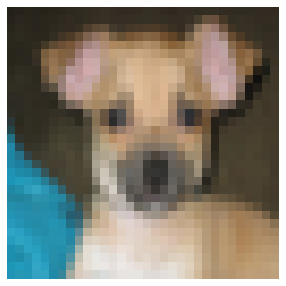

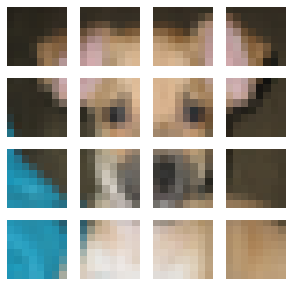

In [29]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import cv2


AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE=32
PATCH_SIZE=8 
NUM_LAYERS=8
NUM_HEADS=16
MLP_DIM=128
lr=1e-3
WEIGHT_DECAY=1e-4
BATCH_SIZE=64
num_patches=IMAGE_SIZE//PATCH_SIZE
epochs=1
ds = tfds.load("cifar10", as_supervised=True)
ds_train = (
    ds["train"]
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
plt.figure(figsize=(5, 5))

for images, labels in ds_train.take(1):
  for i in range(1):
    #ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    plt.axis("off")
patches = tf.image.extract_patches(
            images=images[:1],
            sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
            strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

plt.figure(figsize=(5, 5))

for imgs in patches:
    count = 0
    for r in range(num_patches):
        for c in range(num_patches):
            ax = plt.subplot(num_patches, num_patches, count+1)
            plt.imshow(tf.reshape(imgs[r,c],shape=(PATCH_SIZE,PATCH_SIZE,3)).numpy().astype("uint8"))
            plt.axis("off")
            count += 1



In [90]:
for image, target in ds_test.take(1):
  y = model.predict(image)
  print(np.argmax(y, axis=1), target)

[7 1 6 0 5 1 7 0 3 7 7 4 7 9 3 4 8 8 7 9 4 6 5 5 0 9 2 8 1 8 6 0 7 4 2 0 9
 1 0 2 1 5 0 5 4 0 2 0 5 6 7 4 1 4 2 3 1 4 5 0 7 4 2 1] tf.Tensor(
[7 0 6 9 5 1 7 0 3 2 7 2 7 9 6 8 8 8 7 9 4 2 3 5 0 0 2 8 1 8 2 0 7 2 0 0 9
 1 0 5 1 5 0 3 5 0 2 0 5 3 7 4 1 4 2 5 1 5 2 0 7 2 2 1], shape=(64,), dtype=int64)
